<h1><center>Quora Question Pair Similarity</center></h1>

<h1>1. Business Problem</h1>

<h2>1.1 Description</h2>

<p>Quora is an online platform designed for people to ask questions and share their knowledge on various topics. Its primary goal is to facilitate a collaborative environment where individuals can connect with others who can provide valuable insights and quality answers. The platform attracts over 100 million monthly visitors, emphasizing its popularity and widespread use.</p>

<p>Given the diversity of questions posed on Quora, it's common for users to ask similar or closely related queries. Recognizing that this repetition can potentially create challenges for both those seeking information and those providing answers, Quora places importance on the concept of "canonical questions".</p>

<p>Canonical questions are those that capture the essence of a particular inquiry in the most comprehensive and clear manner. The idea is to encourage users to phrase their questions in a way that minimizes redundancy. By doing so, this approach aims to enhance the overall user experience by making it easier for seekers to find the best answers to their questions and reducing the burden on contributors who might otherwise feel compelled to respond to multiple versions of the same question.</p>

<p>In essence, Quora values the creation of well-structured and definitive questions, as they contribute to a more efficient and beneficial exchange of knowledge among its users. This emphasis on canonical questions is intended to provide a lasting and valuable experience for both those seeking information and those sharing their expertise on the platform.</p>

<br>
<br>
<b>__Problem Statement__:</b>

<li>Identify which questions asked on Quora are duplicates of questions that have already been asked.</li>
<li>This could be useful to instantly provide answers to questions that have already been answered.</li>
<li>We are tasked with predicting whether a pair of questions are duplicates or not.</li>

<h2>1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints</h2>

<ol>
<li><b>High Cost of Mis-classification:</b>
<br>
In the context of question classification or matching, mis-classifying questions can lead to significant consequences. This implies that if the system incorrectly identifies two questions as duplicates or similar when they are not, it could result in undesirable outcomes. For instance, misclassifying questions on a medical forum might lead to incorrect advice being provided, emphasizing the importance of accuracy in question matching.</li>

<li><b>Desire for Probability Information:</b>
<br>
It seems you're highlighting the importance of having a probability associated with the classification of question pairs. This probabilistic measure allows for flexibility in decision-making. Instead of a rigid classification, where a system only says whether questions are duplicates or not, having a probability score allows users to set their own thresholds. This flexibility is valuable for fine-tuning the system to meet specific needs or preferences.</li>

<li><b>No Strict Latency Concerns:</b>
<br>
This suggests that the speed or response time of the system is not a critical factor. In some applications, especially real-time systems, low latency is crucial. However, in this context, it's implied that the system doesn't need to prioritize quick responses, allowing for more complex or resource-intensive processes to improve accuracy without compromising speed.</li>

<li><b>Partial Importance of Interpretability:</b>
<br>
Interpretability refers to the ease with which a human can understand and make sense of the decisions made by a machine learning model. The statement indicates that while it's important for the system to be interpretable to some extent, it's not an absolute priority. This balance between interpretability and other factors suggests a nuanced approach, where the model's decisions can be understood to a degree, but other considerations may take precedence.</li>
</ol>

<h1>2. Machine Learning Problem</h1>

<h2>2.1 Data</h2>

<h3>2.1.1 Data Overview</h3>

<li>Data will be in a file Train.csv</li>
<li>Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate</li>
<li>Size of Train.csv - 60MB</li>
<li>Number of rows in Train.csv = 404,290</li>

<h3>2.1.2 Example Data point</h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2>2.2 Mapping the real world problem to an ML problem<h2>

<h3>2.2.1 Type of Machine Leaning Problem</h3>

It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not.

<h3>2.2.2 Performance Metric.</h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h2>2.3 Train and Test Construction</h2>

We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with.

<h1>3. Exploratory Data Analysis</h1>

In [1]:
import os
import re
import time
import csv
import gc
import langid
import string
import distance
import nltk
import contractions
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz
from subprocess import check_output
from nltk.corpus import stopwords, words
from nltk.stem import PorterStemmer
from langdetect import detect
from googletrans import Translator
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
from tqdm import tqdm
from translate import Translator
from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from deep_translator import GoogleTranslator
from prettytable import PrettyTable
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
py.init_notebook_mode(connected=True)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SachinKapoor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SachinKapoor\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\SachinKapoor\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

<h2> 3.1 Reading data and basic stats </h2>

In [2]:
try:
    df = pd.read_csv('train.csv')
    
    # Randomly select 5000 rows
    df = df.sample(n=5000, random_state=42)
    
    # Reset the index
    df = df.reset_index(drop=True)
except FileNotFoundError:
    print("Please check the path of CSV file.")
else:
    print("Succesfully load the data")

Succesfully load the data


In [3]:
df.head()

id    qid1    qid2                                          question1  \
0    8067   15738   15739                 How do I play Pokémon GO in Korea?   
1  368101   12736  104117  What are some of the best side dishes for crab...   
2   70497  121486  121487  Which is more advisable and better material fo...   
3  226567  254474  258192       How do I improve logical programming skills?   
4   73186   48103    3062             How close we are to see 3rd world war?   

                                           question2  is_duplicate  
0                 How do I play Pokémon GO in China?             0  
1  What are some good side dishes for buffalo chi...             0  
2      What is the best server setup for buddypress?             0  
3  How can I improve my logical skills for progra...             1  
4                      How close is a World War III?             1

In [4]:
print(f"we have {df.shape[0]} rows and {df.shape[1]} columns. ")

we have 5000 rows and 6 columns. 


In [5]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

In [6]:
print(f"we have {df.shape[0]} rows and {df.shape[1]} columns. ")

we have 5000 rows and 6 columns. 


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            5000 non-null   int64 
 1   qid1          5000 non-null   int64 
 2   qid2          5000 non-null   int64 
 3   question1     5000 non-null   object
 4   question2     5000 non-null   object
 5   is_duplicate  5000 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 234.5+ KB


<b>Observations: </b>

<li>id: This appears to be a simple row ID, likely used for indexing or identification purposes.</li>

<li>qid{1, 2}: These seem to be unique IDs associated with each question in a pair.</li>

<li>question{1, 2}: These columns contain the actual textual contents of the questions.</li>

<li>is_duplicate: This is the label you are trying to predict, indicating whether the two questions in a pair are duplicates of each other.</li>

<li>Null values: There is one null value in the 'question1' column and two null values in the 'question2' column. Handling null values is important for many machine learning tasks, and you might consider imputing or removing them based on your specific needs.</li>

<h3> 3.2.1 Distribution of data points among output classes</h3>

In [8]:
# Calculate the percentage of each class label
class_percentages = df['is_duplicate'].value_counts(normalize=True) * 100

# Create an interactive bar chart
fig = px.bar(x=['Not Duplicate', 'Duplicate'],
             y=class_percentages.values,
             text=[f'{v:.2f}%' for v in class_percentages.values],
             title='Percentage Distribution of Class Labels',
             labels={'x': 'Class Label', 'y': 'Percentage'},
             color=['blue', 'orange'],
             )

# Update layout for better aesthetics (optional)
fig.update_layout(
    showlegend=False,  # Optional: set to True if you want to display legend
)

# Add percentage labels on top of each bar
fig.update_traces(textposition='outside')

# Show the plot
fig.show()

In [9]:
total_rows = df.shape[0]
not_duplicate_count = df.groupby('is_duplicate')['id'].count()[0]
duplicate_count = df.groupby('is_duplicate')['id'].count()[1]

print(f"Total rows: {total_rows}")
print(f"Count of 0 (Not duplicate): {not_duplicate_count} ({round(not_duplicate_count/total_rows*100, 2)}%)")
print(f"Count of 1 (Duplicate): {duplicate_count} ({round(duplicate_count/total_rows*100, 2)}%)")

Total rows: 5000
Count of 0 (Not duplicate): 3148 (62.96%)
Count of 1 (Duplicate): 1852 (37.04%)


<h3>3.2.2 Number of unique questions</h3>

In [10]:
# Combine 'qid1' and 'qid2' columns into a single Series
total_qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
print("Total questions: ", len(total_qids))

# Calculate the total number of unique ids
unique_qids = len(total_qids.unique())
print(f"Total unique questions: {unique_qids} ({round(unique_qids/len(total_qids)*100, 2)}%)")

# Count the occurrences of each id
count_qids = total_qids.value_counts()

# Filter out ids that are not unique (occurs more than once)
not_unique_qids_counts = count_qids[count_qids > 1]
print(f"Number of unique questions that appear more than one time: {len(not_unique_qids_counts)} ({round(len(not_unique_qids_counts)/len(total_qids)*100, 2)}%)")

print("Max number of times a single question is repeated: ", max(count_qids))

print(f"The question which occured most no of times is: {df[df['qid1'] == 2559]['question1'].unique()}")

Total questions:  10000
Total unique questions: 9826 (98.26%)
Number of unique questions that appear more than one time: 154 (1.54%)
Max number of times a single question is repeated:  4
The question which occured most no of times is: ['What are the best ways to lose weight?']


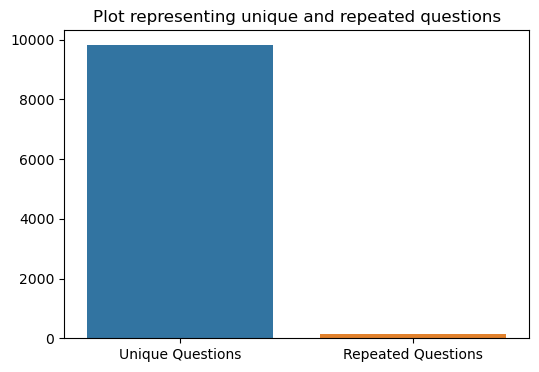

In [11]:
x = ["Unique Questions", "Repeated Questions"]
y = [unique_qids, len(not_unique_qids_counts)]

plt.figure(figsize=(6, 4))
plt.title("Plot representing unique and repeated questions")
sns.barplot(x=x, y=y)
plt.show()

<h3>3.2.3 Checking for Duplicates </h3>

In [12]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


<h3> 3.2.4 Number of occurrences of each question </h3>

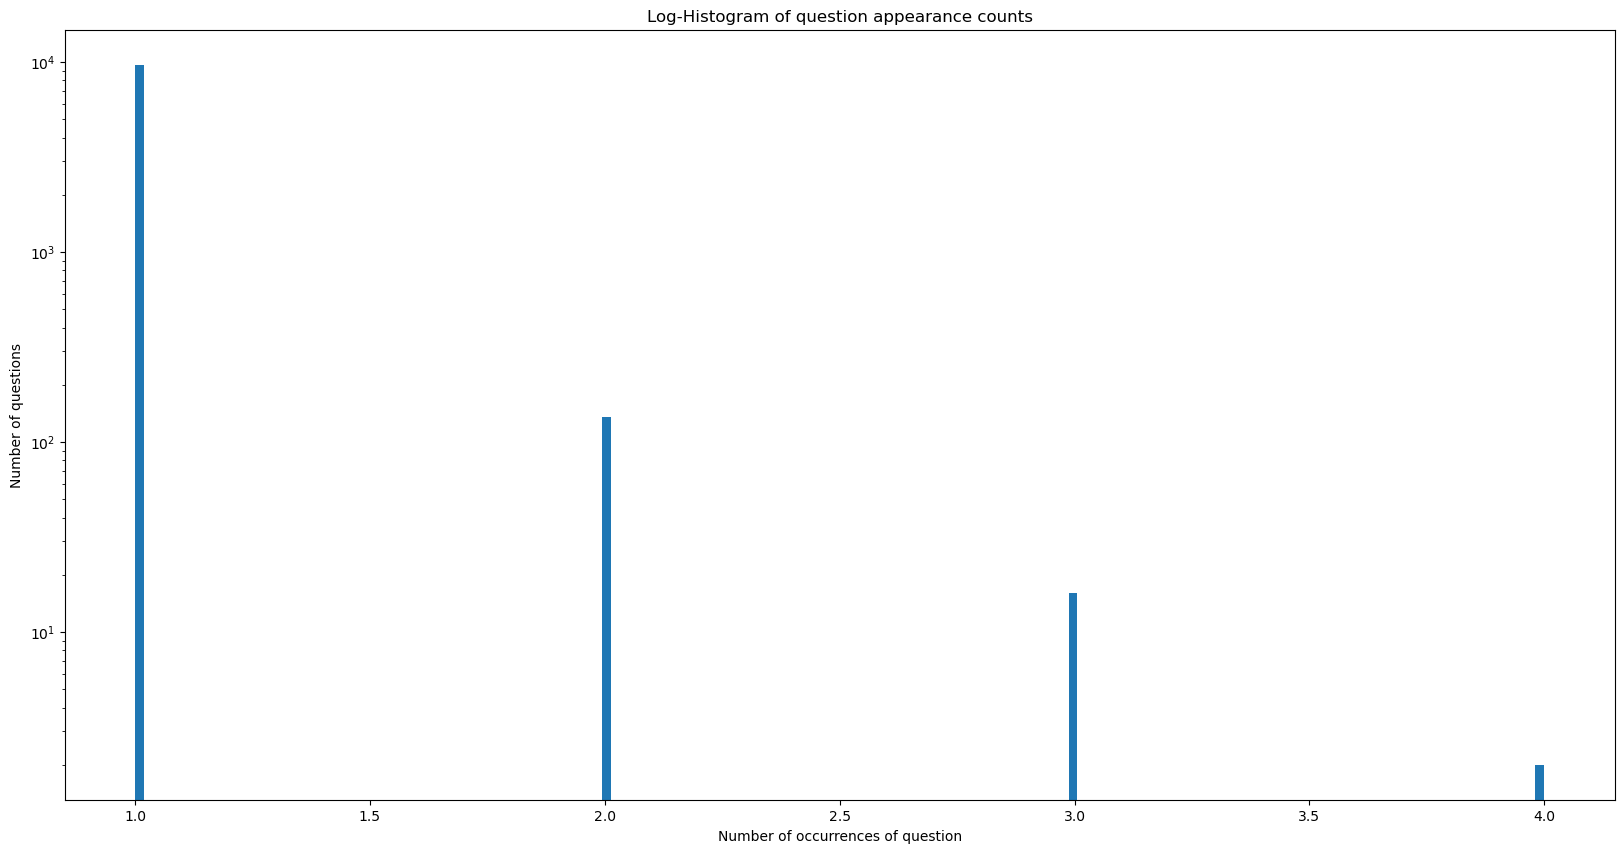

In [13]:
plt.figure(figsize=(20, 10))

# Assuming total_qids is your Series
counts = total_qids.value_counts()
plt.hist(counts, bins=160)

plt.yscale('log')

plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurrences of question')
plt.ylabel('Number of questions')
plt.show()

<h3> 3.2.5 Checking for NULL values </h3>

In [14]:
null_count_question1 = df["question1"].isnull().sum()
print("Total no. of rows where we have null value in question1: ", null_count_question1)
rows_with_nulls = df[df["question1"].isnull()]
rows_with_nulls

Total no. of rows where we have null value in question1:  0


Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []

In [15]:
null_count_question2 = df["question2"].isnull().sum()
print("Total no. of rows where we have null value in question2: ", null_count_question2)
rows_with_nulls = df[df["question2"].isnull()]
rows_with_nulls

Total no. of rows where we have null value in question2:  0


Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []

In [16]:
df = df.dropna(subset=['question1'])
df = df.dropna(subset=['question2'])
print("After deleting the rows where we have null values: ",df.shape[0])

After deleting the rows where we have null values:  5000


<h2>3.3 Basic Feature Extraction (before cleaning) </h2>

<h3>3.3.1 Convert the non english text to english text</h3>

In [17]:
# def translate_text(text, target_language='en'):
#     try:
#         translator = Translator(to_lang=target_language)
#         translation = translator.translate(text)
#         return translation
#     except Exception as e:
#         return f"An error occurred: {str(e)}"

# # Assuming df is your DataFrame
# # Apply translation function to each row in the DataFrame using tqdm for progress tracking
# tqdm.pandas(desc="Translating", unit="row")

# # Create new columns for translated text
# df['question1'] = df['question1'].progress_apply(translate_text)
# df['question2'] = df['question2'].progress_apply(translate_text)

<h3>3.3.2 Check the text belongs to english or not</h3>

In [18]:
# # Function to check if any non-English word is present in a given text
# def has_non_english_word(text):
#     words = text.split()
#     for word in words:
#         if langid.classify(word)[0] != 'en':  # 'en' represents English language
#             print(word)
#             return True
#     return False

# # Apply the function to each row in the DataFrame with tqdm
# non_english_rows = []
# for index, row in tqdm(df.iterrows(), total=len(df), desc="Checking rows"):
#     if has_non_english_word(row['question1']) or has_non_english_word(row['question2']):
#         non_english_rows.append(index)

In [19]:
# # Print the rows with non-English words
# print("Rows with non-English words:")
# print("Total rows where question1 and question2 text does not belong to english: ", df.loc[non_english_rows].shape[0])
# df.loc[non_english_rows]

In [20]:
# # Drop the rows with non-English words from the original DataFrame
# df.drop(non_english_rows, inplace=True)

# # Display the updated DataFrame
# print(f"we have {df.shape[0]} rows and {df.shape[1]} columns. ")
# print("\nDataFrame after removing rows with non-English words:")
# df

<h3>3.3.3 Simple Feature extractor</h3>

Let us now construct a few features like:
<ul>
<b>Frequency Features:</b>
<br>
<li>freq_qid1: How often Question 1 appears in your dataset.</li>
<li>freq_qid2: How often Question 2 appears in your dataset.</li>
<li>freq_q1+freq_q2: Sum of the frequencies of both questions, indicating their combined prevalence.</li>
<li>freq_q1-freq_q2: Absolute difference of their frequencies, highlighting how much more frequent one question is compared to the other.</li>
    
<b>Length Features:</b>

<li>q1len: Number of characters in Question 1.</li>
<li>q2len: Number of characters in Question 2.</li>
    <br>
<b>Word Features:</b>
<br>
<li>q1_n_words: Number of words in Question 1.</li>
<li>q2_n_words: Number of words in Question 2.</li>
<li>word_Common: Number of unique words that appear in both Question 1 and Question 2, suggesting shared vocabulary.</li>
<li>word_Total: Total number of words across both questions (q1_n_words + q2_n_words).</li>
<li>word_share: Proportion of common words compared to the total number of words in both questions (word_common / word_total), indicating lexical overlap.</li>
</ul>

In [21]:
# Calculate the frequency of occurrence for each question in 'qid1' and 'qid2'
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')

# Calculate the length (number of characters) of each question in 'question1' and 'question2'
df['q1len'] = df['question1'].str.len()
df['q2len'] = df['question2'].str.len()

# Calculate the number of words in each question in 'question1' and 'question2'
df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

# Function to calculate the number of common words between two questions
def normalized_word_common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return len(w1.intersection(w2))

# Create a new feature 'word_common' by applying the function to each row
df['word_common'] = df.apply(normalized_word_common, axis=1)

# Function to calculate the total number of unique words in two questions
def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1) + len(w2))

# Create a new feature 'word_Total' by applying the function to each row
df['word_Total'] = df.apply(normalized_word_Total, axis=1)

# Function to calculate the normalized word share between two questions
def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2) / (len(w1) + len(w2))

# Create a new feature 'word_share' by applying the function to each row
df['word_share'] = df.apply(normalized_word_share, axis=1)

# Create a new feature 'freq_q1+q2' representing the sum of frequencies of 'qid1' and 'qid2'
df['freq_q1+q2'] = df['freq_qid1'] + df['freq_qid2']

# Create a new feature 'freq_q1-q2' representing the absolute difference of frequencies between 'qid1' and 'qid2'
df['freq_q1-q2'] = abs(df['freq_qid1'] - df['freq_qid2'])

<h3> 3.3.4 Analysis of some of the extracted features </h3>

<h4> 3.3.4.1 Feature: word_share </h4>

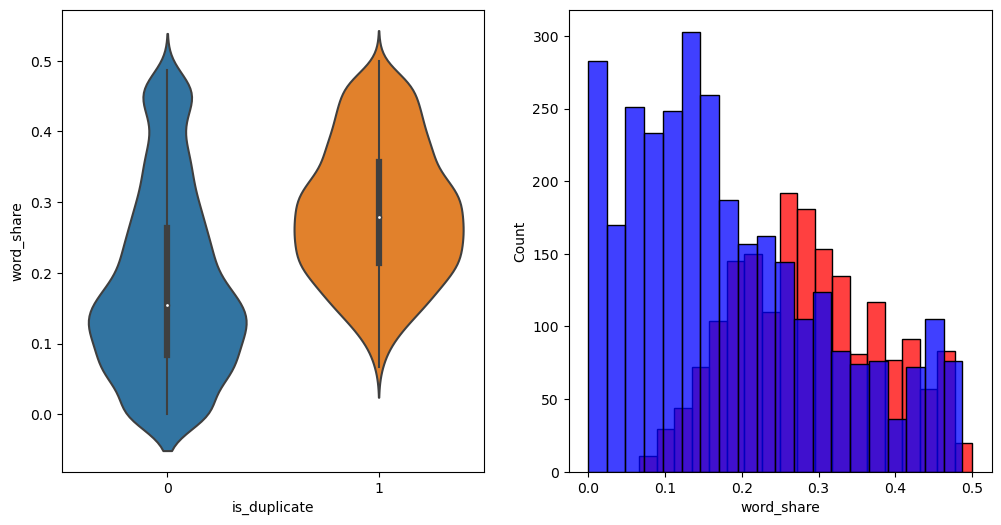

In [22]:
plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.histplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.histplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue')
plt.show()

<h4> 3.3.4.2 Feature: word_Common </h4>

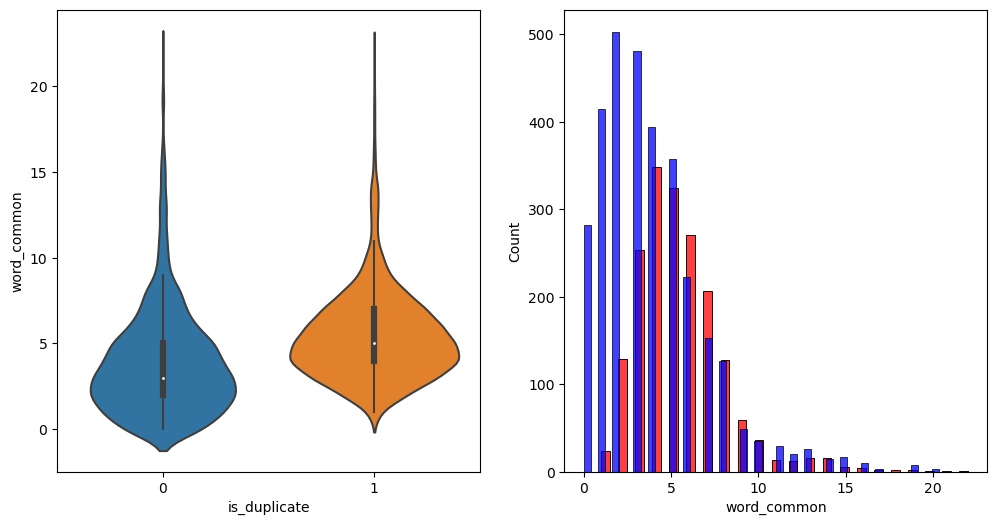

In [23]:
plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_common', data = df[0:])

plt.subplot(1,2,2)
sns.histplot(df[df['is_duplicate'] == 1.0]['word_common'][0:] , label = "1", color = 'red')
sns.histplot(df[df['is_duplicate'] == 0.0]['word_common'][0:] , label = "0" , color = 'blue' )
plt.show()

<h2> 3.5 : EDA: Advanced Feature Extraction.</h2>

<h3> 3.5.1 Preprocessing of Text </h3>

<ol>
<li>
<b>Removing HTML Tags:</b>
    When dealing with text data obtained from web pages, it often contains HTML tags that are used for formatting and styling. Removing these tags ensures that only the actual text content is considered.
</li>

<li>
<b>Removing Punctuations:</b>
    Punctuation marks (e.g., commas, periods, exclamation marks) don't usually carry much semantic meaning in NLP tasks. Removing them simplifies the text and helps in reducing dimensionality in text data.
</li>

<li>
<b>Performing Stemming:</b>
    Stemming involves reducing words to their root or base form. For example, "running" becomes "run." This is done to consolidate words with the same base meaning, reducing the vocabulary size and improving model efficiency.
</li>

<li>
<b>Removing Stopwords:</b>
    Stopwords are common words (e.g., "the," "and," "is") that don't contribute much to the meaning of a text. Removing them helps in focusing on the more meaningful words for analysis.
</li>

<li>
<b>Expanding Contractions:</b>
    Contractions are shortened forms of words (e.g., "don't" for "do not"). Expanding contractions ensures that each word is treated as a separate token, helping the model better understand the text.
</li>

In [24]:
def preprocess_text(text):
    # Remove HTML tags
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()

    # Expand contractions
    text = contractions.fix(text)

    # Remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    # Tokenize and remove stopwords
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    text = ' '.join(filtered_words)

    # Perform stemming
    porter = PorterStemmer()
    words = word_tokenize(text)
    stemmed_words = [porter.stem(word) for word in words]
    text = ' '.join(stemmed_words)

    return text

# Apply tqdm to the DataFrame processing
tqdm.pandas()

# Convert text in 'question1' and 'question2' columns to lowercase
df['question1'] = df['question1'].str.lower()
df['question2'] = df['question2'].str.lower()

# Apply the preprocessing function to 'question1' and 'question2' columns
df['question1'] = df['question1'].progress_apply(preprocess_text)
df['question2'] = df['question2'].progress_apply(preprocess_text)

100%|██████████| 5000/5000 [00:01<00:00, 2772.17it/s]


<h2> 3.6 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [25]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    SAFE_DIV = 0.0001 
    stop_words = set(stopwords.words('english'))

    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in stop_words])
    q2_words = set([word for word in q2_tokens if word not in stop_words])

    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in stop_words])
    q2_stops = set([word for word in q2_tokens if word in stop_words])

    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))

    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))

    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))

    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)

    # Last word of both questions is same or not
    if q1_tokens and q2_tokens:
        token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    else:
        token_features[6] = 0  # or any default value you prefer


    # First word of both question is same or not
    if q1_tokens and q2_tokens:
        token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    else:
        token_features[7] = 0  # or any default value you prefer

    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2

    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    token_features = list(tqdm(df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1), desc="Processing rows", total=len(df)))
    
    df["cwc_min"] = list(map(lambda x: x[0], token_features))
    df["cwc_max"] = list(map(lambda x: x[1], token_features))
    df["csc_min"] = list(map(lambda x: x[2], token_features))
    df["csc_max"] = list(map(lambda x: x[3], token_features))
    df["ctc_min"] = list(map(lambda x: x[4], token_features))
    df["ctc_max"] = list(map(lambda x: x[5], token_features))
    df["last_word_eq"] = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"] = list(map(lambda x: x[8], token_features))
    df["mean_len"] = list(map(lambda x: x[9], token_features))

    # Computing Fuzzy Features and Merging with Dataset
    df["token_set_ratio"] = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    df["token_sort_ratio"] = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"] = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"] = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"] = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    
    return df

df = extract_features(df)
df.head()

Processing rows: 100%|██████████| 5000/5000 [00:00<00:00, 5040019.23it/s]


id    qid1    qid2                                          question1  \
0    8067   15738   15739                              play pokémon go korea   
1  368101   12736  104117                           best side dish crab cake   
2   70497  121486  121487  advis better materi crash test automobil ducti...   
3  226567  254474  258192                         improv logic program skill   
4   73186   48103    3062                            close see 3rd world war   

                        question2  is_duplicate  freq_qid1  freq_qid2  q1len  \
0           play pokémon go china             0          1          1     34   
1  good side dish buffalo chicken             0          1          1     53   
2    best server setup buddypress             0          1          1     96   
3      improv logic skill program             1          2          1     44   
4             close world war iii             1          1          1     38   

   q2len  ...   ctc_max  last_word_eq  first_word_eq  abs_len_diff  mean_len  \
0     34  ...  0.749981             0              1           0.0       4.0   
1     51  ...  0.399992             0              0           0.0       5.0   
2     45  ...  0.000000             0              0           0.0       6.0   
3     52  ...  0.999975             0              1           0.0       4.0   
4     29  ...  0.599988             0              1           0.0       4.5   

   token_set_ratio  token_sort_ratio  fuzz_ratio  fuzz_partial_ratio  \
0               82                70          80                  81   
1               59                56          59                  62   
2               32                32          37                  46   
3              100               100          77                  77   
4               88                76          71                  65   

   longest_substr_ratio  
0              0.727273  
1              0.440000  
2              0.137931  
3              0.481481  
4              0.500000  

[5 rows x 32 columns]

<h3>3.6.1 Analysis of extracted features </h3>

<h4> 3.6.1.1 Plotting Word clouds</h4>

In [26]:
df_duplicate = df[df['is_duplicate']==1]
df_not_duplicate = df[df['is_duplicate']==0]

all_duplicate_question = np.dstack([df_duplicate['question1'], df_duplicate['question2']]).flatten()
all_not_duplicate_question = np.dstack([df_not_duplicate['question1'], df_not_duplicate['question2']]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(all_duplicate_question))
print ("Number of data points in class 0 (non duplicate pairs) :",len(all_not_duplicate_question))

Number of data points in class 1 (duplicate pairs) : 3704
Number of data points in class 0 (non duplicate pairs) : 6296


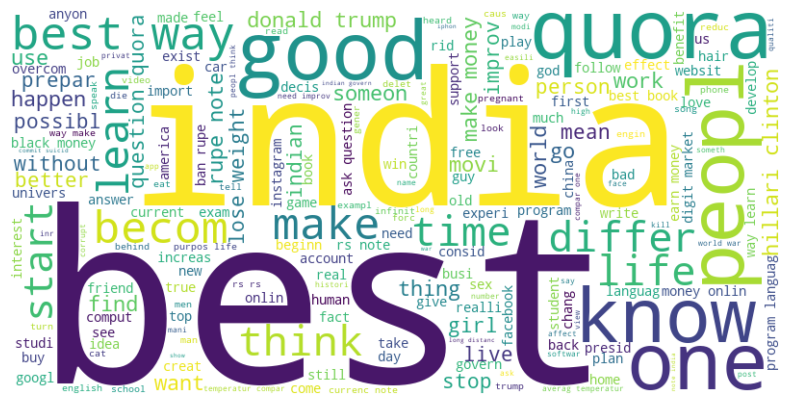

In [27]:
# Combine the sentences into a single string
text = " ".join(all_duplicate_question)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

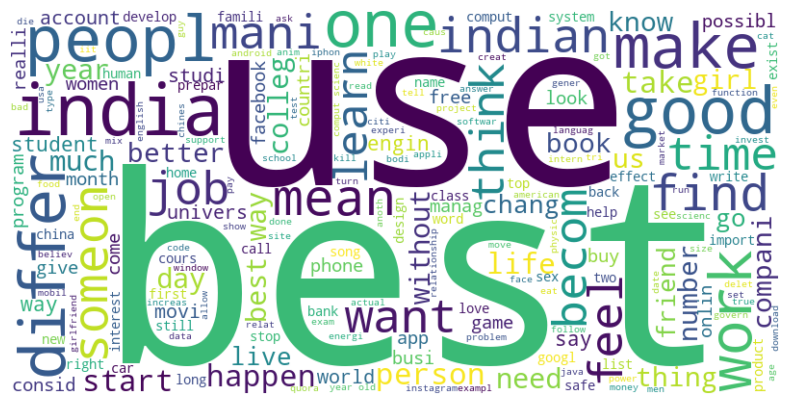

In [28]:
# Combine the sentences into a single string
text = " ".join(all_not_duplicate_question)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

<h4> 3.6.1.2 Plotting pair plot</h4>

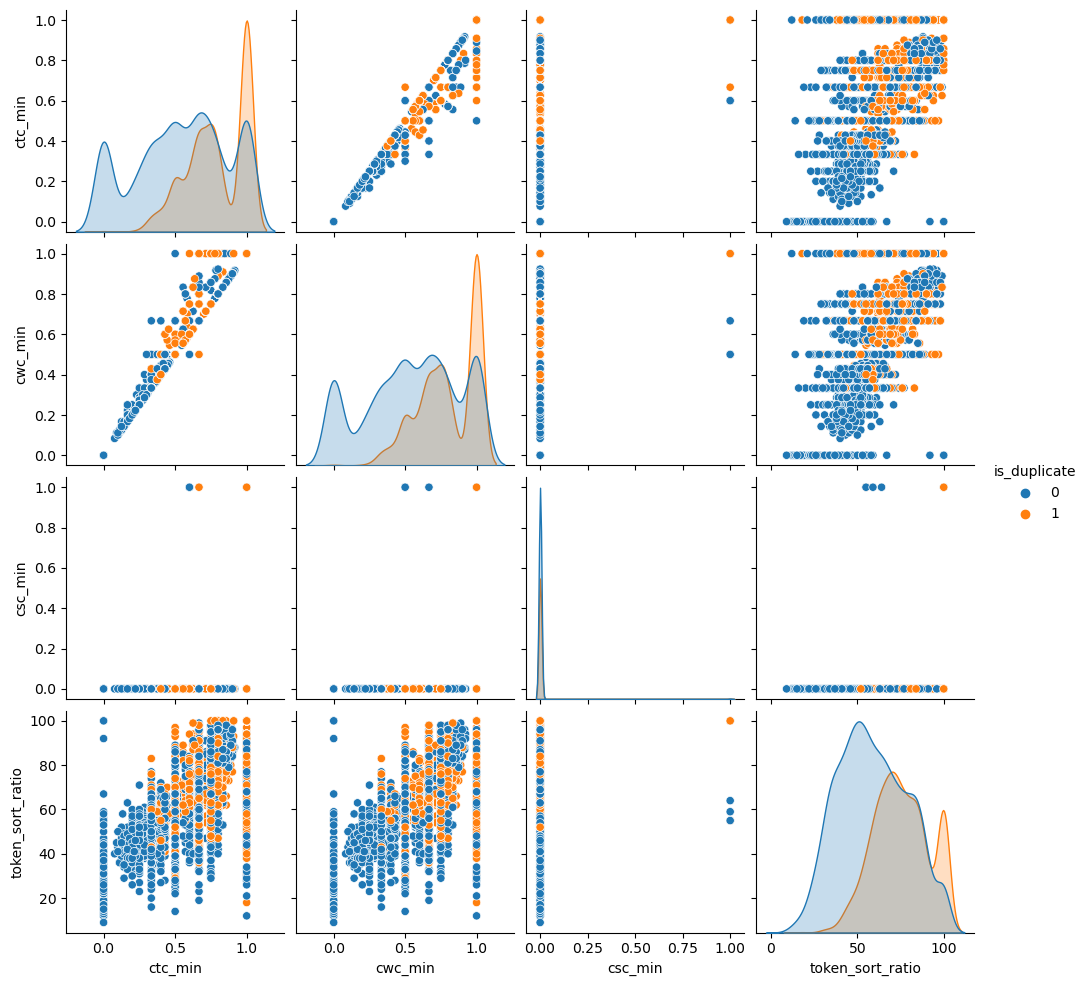

In [29]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

<h4> 3.6.1.3 Plotting violin plot with histogram</h4>

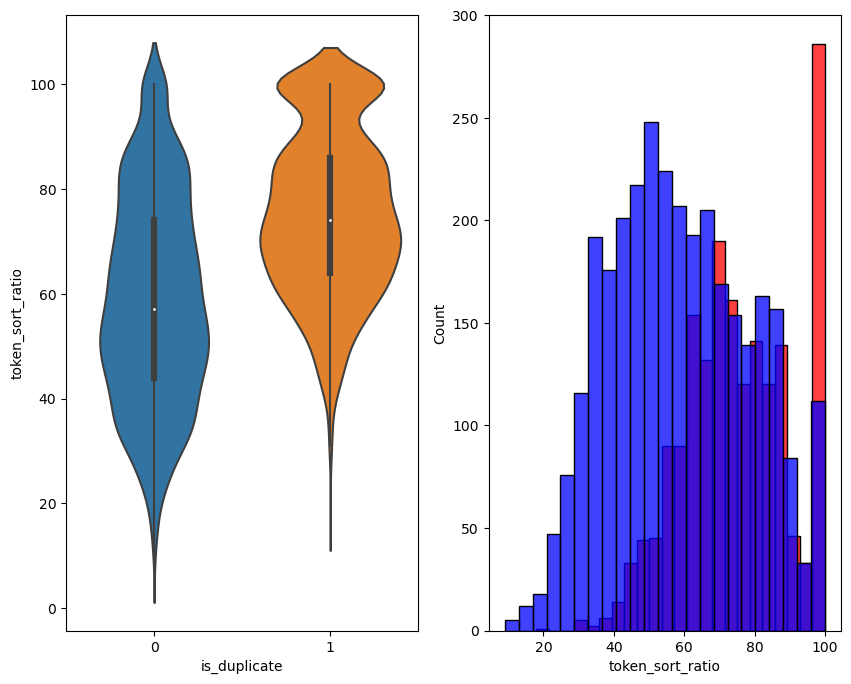

In [30]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.histplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.histplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

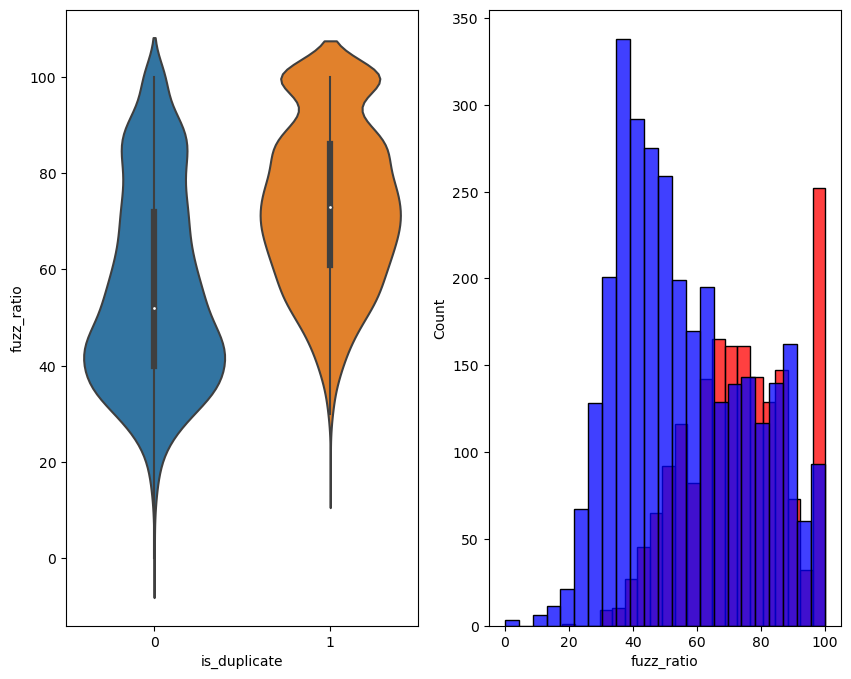

In [31]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.histplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.histplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

<h4> 3.6.1. Preprocessing the text</h4>

In [32]:
# Step 1: Identify rows with empty values
empty_rows = df.applymap(lambda x: len(str(x).strip()) == 0 or str(x).strip().lower() == 'null').any(axis=1)

# Step 2: Drop the rows with empty values
df = df[~empty_rows]

# Step 3: Reset index after dropping rows
df.reset_index(drop=True, inplace=True)

In [33]:
df.to_csv('preprocessed_data.csv', index=False)

In [34]:
try:
    df = pd.read_csv('preprocessed_data.csv')
except FileNotFoundError:
    print("Please check the path of CSV file.")
else:
    print("Succesfully load the data")

Succesfully load the data


In [35]:
df.head()

id    qid1    qid2                                          question1  \
0    8067   15738   15739                              play pokémon go korea   
1  368101   12736  104117                           best side dish crab cake   
2   70497  121486  121487  advis better materi crash test automobil ducti...   
3  226567  254474  258192                         improv logic program skill   
4   73186   48103    3062                            close see 3rd world war   

                        question2  is_duplicate  freq_qid1  freq_qid2  q1len  \
0           play pokémon go china             0          1          1     34   
1  good side dish buffalo chicken             0          1          1     53   
2    best server setup buddypress             0          1          1     96   
3      improv logic skill program             1          2          1     44   
4             close world war iii             1          1          1     38   

   q2len  ...   ctc_max  last_word_eq  first_word_eq  abs_len_diff  mean_len  \
0     34  ...  0.749981             0              1           0.0       4.0   
1     51  ...  0.399992             0              0           0.0       5.0   
2     45  ...  0.000000             0              0           0.0       6.0   
3     52  ...  0.999975             0              1           0.0       4.0   
4     29  ...  0.599988             0              1           0.0       4.5   

   token_set_ratio  token_sort_ratio  fuzz_ratio  fuzz_partial_ratio  \
0               82                70          80                  81   
1               59                56          59                  62   
2               32                32          37                  46   
3              100               100          77                  77   
4               88                76          71                  65   

   longest_substr_ratio  
0              0.727273  
1              0.440000  
2              0.137931  
3              0.481481  
4              0.500000  

[5 rows x 32 columns]

In [36]:
print(f"we have {df.shape[0]} rows and {df.shape[1]} columns. ")

we have 4998 rows and 32 columns. 


In [37]:
X = df.drop(['is_duplicate'], axis=1)
Y = df['is_duplicate']

<h1> 4. Prepare dataset for Model building  </h1>

<h2>4.1 Splitting the data into Train, cv, Test</h2>

In [38]:
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.2)

# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [39]:
print('Number of data points in train data:', X_train.shape)
print('Number of data points in test data:', X_test.shape)
print('Number of data points in cross validation data:', X_cv.shape)

Number of data points in train data: (3198, 31)
Number of data points in test data: (1000, 31)
Number of data points in cross validation data: (800, 31)


In [40]:
X_train_questions_df = X_train[['question1', 'question2']]
X_train_numeric_df   = X_train.drop(['question1', 'question2'], axis=1)

X_test_questions_df  = X_test[['question1', 'question2']]
X_test_numeric_df    = X_test.drop(['question1', 'question2'], axis=1)

X_cv_questions_df    = X_cv[['question1', 'question2']]
X_cv_numeric_df      = X_cv.drop(['question1', 'question2'], axis=1)

<h2> 4.2 Text featurization</h2>

<h3> 4.2.1 Bow featurization </h3>

In [41]:
# Create a CountVectorizer instance with a maximum of 1000 features
bow_vectorizer = CountVectorizer(max_features=1000)

# Combine question1 and question2 columns from training dataset
X_train_questions = list(X_train_questions_df['question1']) + list(X_train_questions_df['question2'])
# Combine question1 and question2 columns from test dataset
X_test_questions  = list(X_test_questions_df['question1']) + list(X_test_questions_df['question2'])
# Combine question1 and question2 columns from cross-validation dataset
X_cv_questions    = list(X_cv_questions_df['question1']) + list(X_cv_questions_df['question2'])

# Transform the combined text data into bag-of-words representation for training data
X_train_q1_arr, X_train_q2_arr = np.vsplit(bow_vectorizer.fit_transform(X_train_questions).toarray(), 2)
# Create DataFrames from the transformed arrays with original indices and feature names
X_train_q1_df1 = pd.DataFrame(X_train_q1_arr, index=X_train_questions_df.index, columns=bow_vectorizer.get_feature_names_out())
X_train_q1_df2 = pd.DataFrame(X_train_q2_arr, index=X_train_questions_df.index, columns=bow_vectorizer.get_feature_names_out())
# Concatenate the created DataFrames along the columns
X_train_bow_questions_df = pd.concat([X_train_q1_df1, X_train_q1_df2], axis=1)
# Concatenate bag-of-words representation with numeric features for training data
X_train_bow = pd.concat([X_train_numeric_df, X_train_bow_questions_df], axis=1)

# Transform the combined text data into bag-of-words representation for test data
X_test_q1_arr, X_test_q2_arr = np.vsplit(bow_vectorizer.transform(X_test_questions).toarray(), 2)
# Create DataFrames from the transformed arrays with original indices and feature names
X_test_q1_df1 = pd.DataFrame(X_test_q1_arr, index=X_test_questions_df.index, columns=bow_vectorizer.get_feature_names_out())
X_test_q1_df2 = pd.DataFrame(X_test_q2_arr, index=X_test_questions_df.index, columns=bow_vectorizer.get_feature_names_out())
# Concatenate the created DataFrames along the columns
X_test_bow_questions_df = pd.concat([X_test_q1_df1, X_test_q1_df2], axis=1)
# Concatenate bag-of-words representation with numeric features for test data
X_test_bow = pd.concat([X_test_numeric_df, X_test_bow_questions_df], axis=1)

# Transform the combined text data into bag-of-words representation for cross-validation data
X_cv_q1_arr, X_cv_q2_arr = np.vsplit(bow_vectorizer.transform(X_cv_questions).toarray(), 2)
# Create DataFrames from the transformed arrays with original indices and feature names
X_cv_q1_df1 = pd.DataFrame(X_cv_q1_arr, index=X_cv_questions_df.index, columns=bow_vectorizer.get_feature_names_out())
X_cv_q1_df2 = pd.DataFrame(X_cv_q2_arr, index=X_cv_questions_df.index, columns=bow_vectorizer.get_feature_names_out())
# Concatenate the created DataFrames along the columns
X_cv_bow_questions_df = pd.concat([X_cv_q1_df1, X_cv_q1_df2], axis=1)
# Concatenate bag-of-words representation with numeric features for cross-validation data
X_cv_bow = pd.concat([X_cv_numeric_df, X_cv_bow_questions_df], axis=1)

In [42]:
print("Total no of features we have generated using BOW is: ", 2*len(bow_vectorizer.get_feature_names_out()))
print('Number of data points in train data:', X_train_bow.shape)
print('Number of data points in test data:', X_test_bow.shape)
print('Number of data points in cross validation data:', X_cv_bow.shape)

Total no of features we have generated using BOW is:  2000
Number of data points in train data: (3198, 2029)
Number of data points in test data: (1000, 2029)
Number of data points in cross validation data: (800, 2029)


<h3> 4.2.2 TF-IDF featurization </h3>

In [43]:
# Create a TF-IDF Vectorizer instance with a maximum of 1000 features
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

# Combine question1 and question2 columns from the training dataset
X_train_questions = list(X_train_questions_df['question1']) + list(X_train_questions_df['question2'])
# Combine question1 and question2 columns from the test dataset
X_test_questions  = list(X_test_questions_df['question1']) + list(X_test_questions_df['question2'])
# Combine question1 and question2 columns from the cross-validation dataset
X_cv_questions    = list(X_cv_questions_df['question1']) + list(X_cv_questions_df['question2'])

# Transform the combined text data into TF-IDF representation for the training data
X_train_q1_arr, X_train_q2_arr = np.vsplit(tfidf_vectorizer.fit_transform(X_train_questions).toarray(), 2)
# Create DataFrames from the transformed arrays with original indices and feature names
X_train_q1_df1 = pd.DataFrame(X_train_q1_arr, index=X_train_questions_df.index, columns=tfidf_vectorizer.get_feature_names_out())
X_train_q1_df2 = pd.DataFrame(X_train_q2_arr, index=X_train_questions_df.index, columns=tfidf_vectorizer.get_feature_names_out())
# Concatenate the created DataFrames along the columns
X_train_tfidf_questions_df = pd.concat([X_train_q1_df1, X_train_q1_df2], axis=1)
# Concatenate TF-IDF representation with numeric features for training data
X_train_tfidf = pd.concat([X_train_numeric_df, X_train_tfidf_questions_df], axis=1)

# Transform the combined text data into TF-IDF representation for the test data
X_test_q1_arr, X_test_q2_arr = np.vsplit(tfidf_vectorizer.transform(X_test_questions).toarray(), 2)
# Create DataFrames from the transformed arrays with original indices and feature names
X_test_q1_df1 = pd.DataFrame(X_test_q1_arr, index=X_test_questions_df.index, columns=tfidf_vectorizer.get_feature_names_out())
X_test_q1_df2 = pd.DataFrame(X_test_q2_arr, index=X_test_questions_df.index, columns=tfidf_vectorizer.get_feature_names_out())
# Concatenate the created DataFrames along the columns
X_test_tfidf_questions_df = pd.concat([X_test_q1_df1, X_test_q1_df2], axis=1)
# Concatenate TF-IDF representation with numeric features for test data
X_test_tfidf = pd.concat([X_test_numeric_df, X_test_tfidf_questions_df], axis=1)

# Transform the combined text data into TF-IDF representation for the cross-validation data
X_cv_q1_arr, X_cv_q2_arr = np.vsplit(tfidf_vectorizer.transform(X_cv_questions).toarray(), 2)
# Create DataFrames from the transformed arrays with original indices and feature names
X_cv_q1_df1 = pd.DataFrame(X_cv_q1_arr, index=X_cv_questions_df.index, columns=tfidf_vectorizer.get_feature_names_out())
X_cv_q1_df2 = pd.DataFrame(X_cv_q2_arr, index=X_cv_questions_df.index, columns=tfidf_vectorizer.get_feature_names_out())
# Concatenate the created DataFrames along the columns
X_cv_tfidf_questions_df = pd.concat([X_cv_q1_df1, X_cv_q1_df2], axis=1)
# Concatenate TF-IDF representation with numeric features for cross-validation data
X_cv_tfidf = pd.concat([X_cv_numeric_df, X_cv_tfidf_questions_df], axis=1)

In [44]:
print("Total no of features we have generated using BOW is: ", 2*len(tfidf_vectorizer.get_feature_names_out()))
print('Number of data points in train data:', X_train_tfidf.shape)
print('Number of data points in test data:', X_test_tfidf.shape)
print('Number of data points in cross validation data:', X_cv_tfidf.shape)

Total no of features we have generated using BOW is:  2000
Number of data points in train data: (3198, 2029)
Number of data points in test data: (1000, 2029)
Number of data points in cross validation data: (800, 2029)


<h3> 4.2.3 W2V featurization </h3>

In [45]:
# Combine questions for training, testing, and cross-validation sets
X_train_questions = list(X_train_questions_df['question1']) + list(X_train_questions_df['question2'])
X_test_questions  = list(X_test_questions_df['question1']) + list(X_test_questions_df['question2'])
X_cv_questions    = list(X_cv_questions_df['question1']) + list(X_cv_questions_df['question2'])

# Tokenize the sentences into words
X_train_tokens = [nltk.word_tokenize(sent) for sent in X_train_questions]
X_test_tokens = [nltk.word_tokenize(sent) for sent in X_test_questions]
X_cv_tokens = [nltk.word_tokenize(sent) for sent in X_cv_questions]

# Create Word2Vec model
w2v_model = Word2Vec(sentences=X_train_tokens + X_test_tokens + X_cv_tokens, vector_size=300, window=5, min_count=1, workers=4)

# Function to convert a sentence to the average Word2Vec representation
def sentence_to_avg_w2v(sentence, model):
    words = word_tokenize(sentence)
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        # If none of the words in the sentence are in the vocabulary
        return np.zeros(model.vector_size)

# Convert questions to Word2Vec representations for training data
X_train_w2v_arr = np.array([sentence_to_avg_w2v(sentence, w2v_model) for sentence in X_train_questions])
X_train_q1_arr, X_train_q2_arr = np.vsplit(X_train_w2v_arr, 2)
X_train_q1_df1 = pd.DataFrame(X_train_q1_arr, index=X_train_questions_df.index)
X_train_q1_df2 = pd.DataFrame(X_train_q2_arr, index=X_train_questions_df.index)
X_train_w2v_questions_df = pd.concat([X_train_q1_df1, X_train_q1_df2], axis=1)
X_train_w2v = pd.concat([X_train_numeric_df, X_train_w2v_questions_df], axis=1)

# Convert questions to Word2Vec representations for test data
X_test_w2v_arr = np.array([sentence_to_avg_w2v(sentence, w2v_model) for sentence in X_test_questions])
X_test_q1_arr, X_test_q2_arr = np.vsplit(X_test_w2v_arr, 2)
X_test_q1_df1 = pd.DataFrame(X_test_q1_arr, index=X_test_questions_df.index)
X_test_q1_df2 = pd.DataFrame(X_test_q2_arr, index=X_test_questions_df.index)
X_test_w2v_questions_df = pd.concat([X_test_q1_df1, X_test_q1_df2], axis=1)
X_test_w2v = pd.concat([X_test_numeric_df, X_test_w2v_questions_df], axis=1)

# Convert questions to Word2Vec representations for cross-validation data
X_cv_w2v_arr = np.array([sentence_to_avg_w2v(sentence, w2v_model) for sentence in X_cv_questions])
X_cv_q1_arr, X_cv_q2_arr = np.vsplit(X_cv_w2v_arr, 2)
X_cv_q1_df1 = pd.DataFrame(X_cv_q1_arr, index=X_cv_questions_df.index)
X_cv_q1_df2 = pd.DataFrame(X_cv_q2_arr, index=X_cv_questions_df.index)
X_cv_w2v_questions_df = pd.concat([X_cv_q1_df1, X_cv_q1_df2], axis=1)
X_cv_w2v = pd.concat([X_cv_numeric_df, X_cv_w2v_questions_df], axis=1)

In [46]:
print('Number of data points in train data:', X_train_w2v.shape)
print('Number of data points in test data:', X_test_w2v.shape)
print('Number of data points in cross validation data:', X_cv_w2v.shape)

Number of data points in train data: (3198, 629)
Number of data points in test data: (1000, 629)
Number of data points in cross validation data: (800, 629)


<h3> 4.2.4 TF-IDF W2V featurization </h3>

<h2> 4.3 Model building </h2>

<h3> 4.3.1 Model performance visualize</h3>

In [47]:
# Define a function to evaluate the performance of a classification model
def model_performance_metrics(y_test, y_pred):
    # Print a separator line for better visibility
    print("*" * 15 + "Performance metric" + "*" * 15)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    
    # Calculate the confusion matrix
    C = confusion_matrix(y_test, y_pred)
    
    # Calculate precision matrix by normalizing each column of the confusion matrix
    A = (((C.T) / (C.sum(axis=1))).T)
    
    # Calculate recall matrix by normalizing each row of the confusion matrix
    B = (C / C.sum(axis=0))
    
    # Define class labels
    labels = [1, 2]
    
    # Plot confusion matrix heatmap
    print("-" * 20, "Confusion matrix", "-" * 20)
    plt.figure(figsize=(3, 3))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    # Print and plot precision matrix
    print("-" * 20, "Precision matrix (Column Sum=1)", "-" * 20)
    precision = precision_score(y_test, y_pred)
    print(f"Precision: {precision:.4f}")
    plt.figure(figsize=(3, 3))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # Print and plot recall matrix
    print("-" * 20, "Recall matrix (Row Sum=1)", "-" * 20)
    recall = recall_score(y_test, y_pred)
    print(f"Recall: {recall:.4f}")
    plt.figure(figsize=(3, 3))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # Print F1 Score
    print("-" * 20, "F1 Score", "-" * 20)
    f1 = f1_score(y_test, y_pred)
    print(f"F1 Score: {f1:.4f}")
    
    # Return calculated metrics
    return accuracy, precision, recall, f1

<h3>4.3.2 KNN Algorithm</h3>

In [48]:
# def knn_model(X_train, y_train, X_cv, y_cv, X_test, y_test, k_list):
#     # Step 1: Define a list of even values for k up to max_k
#     k_values = k_list
#     # Initialize an array to store log loss for each value of k
#     cv_log_error_array = []

#     # Step 2: Loop through each value of k
#     for k in k_values:
#         # Initialize KNN classifier with the current value of k
#         knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
#         # Fit the KNN model on the training data
#         knn.fit(X_train, y_train)
#         # Calibrate the model using sigmoid calibration
#         sig_clf_knn = CalibratedClassifierCV(knn, method="sigmoid")
#         sig_clf_knn.fit(X_train, y_train)
#         # Predict probabilities on the cross-validation set
#         sig_clf_probs_cv = sig_clf_knn.predict_proba(X_cv)

#         # Calculate log loss and append to the array
#         cv_log_error_array.append(log_loss(y_cv, sig_clf_probs_cv, labels=knn.classes_, eps=1e-15))

#         # Print log loss for the current value of k
#         print('For value of k =', k, 'The log loss is:', log_loss(y_cv, sig_clf_probs_cv))

#     # Step 3: Plot the cross-validation error for each value of k
#     fig, ax = plt.subplots()
#     ax.plot(k_values, cv_log_error_array, c='g')
#     for i, txt in enumerate(np.round(cv_log_error_array, 3)):
#         ax.annotate((k_values[i], np.round(txt, 3)), (k_values[i], cv_log_error_array[i]))
#     plt.grid()
#     plt.title("Cross Validation Error for each k")
#     plt.xlabel("K (Number of Neighbors)")
#     plt.ylabel("Log Loss")
#     plt.show()
    
#     # Step 4: Identify the best k based on minimum log loss
#     best_k = k_values[np.argmin(cv_log_error_array)]
#     best_knn = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
#     best_knn.fit(X_train, y_train)

#     # Calibrate the best model using sigmoid calibration
#     best_sig_clf_knn = CalibratedClassifierCV(best_knn, method="sigmoid")
#     best_sig_clf_knn.fit(X_train, y_train)

#     # Predict probabilities on the training set for the best model
#     predict_y_train = best_sig_clf_knn.predict_proba(X_train)
#     knn_train_log_loss = log_loss(y_train, predict_y_train, labels=best_knn.classes_, eps=1e-15)
#     # Print log loss on the training set for the best model
#     print('For values of best k =', best_k, "The train log loss is:", knn_train_log_loss)

#     # Predict probabilities on the cross-validation set for the best model
#     predict_y_cv = best_sig_clf_knn.predict_proba(X_cv)
#     knn_cv_log_loss = log_loss(y_cv, predict_y_cv, labels=best_knn.classes_, eps=1e-15)
#     # Print log loss on the cross-validation set for the best model
#     print('For values of best k =', best_k, "The cv log loss is:", knn_cv_log_loss)

#     # Predict probabilities on the test set for the best model
#     predict_y_test = best_sig_clf_knn.predict_proba(X_test)
#     knn_test_log_loss = log_loss(y_test, predict_y_test, labels=best_knn.classes_, eps=1e-15)
#     # Print log loss on the test set for the best model
#     print('For values of best k =', best_k, "The test log loss is:", knn_test_log_loss)
    
#     # Calculate and print the number of misclassified points
#     predict_y = best_sig_clf_knn.predict(X_test)
#     knn_misclassified_points = np.count_nonzero((predict_y - y_test) != 0) / y_test.shape[0]
#     print("Number of misclassified points:", knn_misclassified_points)

    
#     # Print additional model performance metrics
#     knn_accuracy, knn_precision, knn_recall, knn_f1 = model_performance_metrics(y_test, predict_y)
    
#     return knn_accuracy, knn_precision, knn_recall, knn_f1, knn_train_log_loss, knn_cv_log_loss, knn_test_log_loss, knn_misclassified_points

In [49]:
# # X_train_bow, y_train, X_cv_bow, y_cv, X_test_bow, y_test are defined earlier
# knn_bow_accuracy, knn_bow_precision, knn_bow_recall, knn_bow_f1, knn_bow_train_log_loss, knn_bow_cv_log_loss, knn_bow_test_log_loss, knn_bow_misclassified_points = knn_model(X_train_bow.values, y_train, X_cv_bow.values, y_cv, X_test_bow.values, y_test, [2, 4, 6, 8])

In [50]:
# # X_train_tfidf, y_train, X_cv_tfidf, y_cv, X_test_tfidf, y_test are defined earlier
# knn_tfidf_accuracy, knn_tfidf_precision, knn_tfidf_recall, knn_tfidf_f1, knn_tfidf_train_log_loss, knn_tfidf_cv_log_loss, knn_tfidf_test_log_loss, knn_tfidf_misclassified_points = knn_model(X_train_tfidf.values, y_train, X_cv_tfidf.values, y_cv, X_test_tfidf.values, y_test, [2, 4, 6, 8])

In [51]:
# # X_train_w2v, y_train, X_cv_w2v, y_cv, X_test_w2v, y_test are defined earlier
# knn_w2v_accuracy, knn_w2v_precision, knn_w2v_recall, knn_w2v_f1, knn_w2v_train_log_loss, knn_w2v_cv_log_loss, knn_w2v_test_log_loss, knn_w2v_misclassified_points = knn_model(X_train_w2v.values, y_train, X_cv_w2v.values, y_cv, X_test_w2v.values, y_test, [2, 4, 6, 8])

<h3>4.3.3 Multinomial Naive bayes Algorithm</h3>

In [52]:
def mnb_model(X_train, y_train, X_cv, y_cv, X_test, y_test, alpha_values):
    # Step 1: Define a list of alpha values
    alpha_list = alpha_values
    # Initialize an array to store log loss for each value of alpha
    cv_log_error_array = []

    # Step 2: Loop through each value of alpha
    for alpha in alpha_list:
        # Initialize Multinomial Naive Bayes classifier with the current value of alpha
        mnb = MultinomialNB(alpha=alpha)
        # Fit the Multinomial Naive Bayes model on the training data
        mnb.fit(X_train, y_train)
        # Calibrate the model using sigmoid calibration
        sig_clf_mnb = CalibratedClassifierCV(mnb, method="sigmoid")
        sig_clf_mnb.fit(X_train, y_train)
        # Predict probabilities on the cross-validation set
        sig_clf_probs_cv = sig_clf_mnb.predict_proba(X_cv)

        # Calculate log loss and append to the array
        cv_log_error_array.append(log_loss(y_cv, sig_clf_probs_cv, labels=mnb.classes_))

        # Print log loss for the current value of alpha
        print('For value of alpha =', alpha, 'The log loss is:', log_loss(y_cv, sig_clf_probs_cv))

    # Step 3: Plot the cross-validation error for each value of alpha
    fig, ax = plt.subplots()
    ax.plot(alpha_list, cv_log_error_array, c='g')
    for i, txt in enumerate(np.round(cv_log_error_array, 3)):
        ax.annotate((alpha_list[i], np.round(txt, 3)), (alpha_list[i], cv_log_error_array[i]))
    plt.grid()
    plt.title("Cross Validation Error for each alpha")
    plt.xlabel("Alpha (Smoothing Parameter)")
    plt.ylabel("Log Loss")
    plt.show()

    # Step 4: Identify the best alpha based on minimum log loss
    best_alpha = alpha_list[np.argmin(cv_log_error_array)]
    best_mnb = MultinomialNB(alpha=best_alpha)
    best_mnb.fit(X_train, y_train)

    # Calibrate the best model using sigmoid calibration
    best_sig_clf_mnb = CalibratedClassifierCV(best_mnb, method="sigmoid")
    best_sig_clf_mnb.fit(X_train, y_train)

    # Predict probabilities on the training set for the best model
    predict_y_train = best_sig_clf_mnb.predict_proba(X_train)
    mnb_train_log_loss = log_loss(y_train, predict_y_train, labels=best_mnb.classes_)
    # Print log loss on the training set for the best model
    print('For values of best alpha =', best_alpha, "The train log loss is:", mnb_train_log_loss)

    # Predict probabilities on the cross-validation set for the best model
    predict_y_cv = best_sig_clf_mnb.predict_proba(X_cv)
    mnb_cv_log_loss = log_loss(y_cv, predict_y_cv, labels=best_mnb.classes_)
    # Print log loss on the cross-validation set for the best model
    print('For values of best alpha =', best_alpha, "The cv log loss is:", mnb_cv_log_loss)

    # Predict probabilities on the test set for the best model
    predict_y_test = best_sig_clf_mnb.predict_proba(X_test)
    mnb_test_log_loss = log_loss(y_test, predict_y_test, labels=best_mnb.classes_)
    # Print log loss on the test set for the best model
    print('For values of best alpha =', best_alpha, "The test log loss is:", mnb_test_log_loss)

    # Calculate and print the number of misclassified points
    predict_y = best_sig_clf_mnb.predict(X_test)
    mnb_misclassified_points = np.count_nonzero((predict_y - y_test) != 0) / y_test.shape[0]
    print("Number of misclassified points:", mnb_misclassified_points)

    # Print additional model performance metrics
    mnb_accuracy, mnb_precision, mnb_recall, mnb_f1 = model_performance_metrics(y_test, predict_y)
    
    return mnb_accuracy, mnb_precision, mnb_recall, mnb_f1, mnb_train_log_loss, mnb_cv_log_loss, mnb_test_log_loss, mnb_misclassified_points

For value of alpha = 0.1 The log loss is: 0.6010879381794879
For value of alpha = 0.5 The log loss is: 0.6010888643651068
For value of alpha = 1.0 The log loss is: 0.6010898027643043
For value of alpha = 2.0 The log loss is: 0.6010911656994811


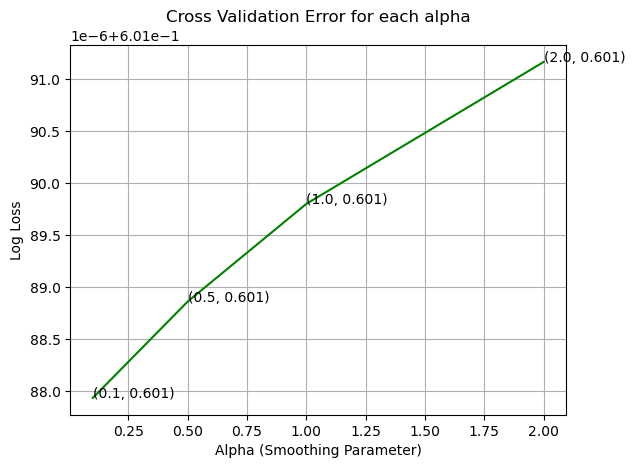

For values of best alpha = 0.1 The train log loss is: 0.611605944933173
For values of best alpha = 0.1 The cv log loss is: 0.6010879381794879
For values of best alpha = 0.1 The test log loss is: 0.6185552512878671
Number of misclassified points: 0.32
***************Performance metric***************
Accuracy: 68.00%
-------------------- Confusion matrix --------------------


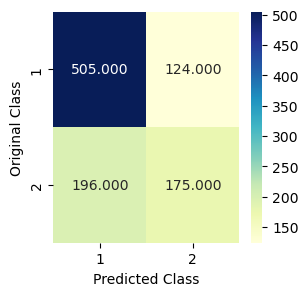

-------------------- Precision matrix (Column Sum=1) --------------------
Precision: 0.5853


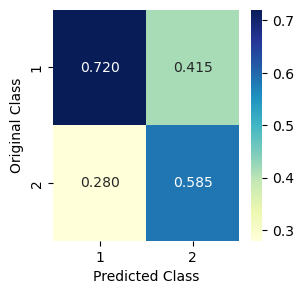

-------------------- Recall matrix (Row Sum=1) --------------------
Recall: 0.4717


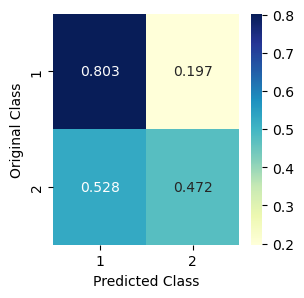

-------------------- F1 Score --------------------
F1 Score: 0.5224


In [53]:
mnb_bow_accuracy, mnb_bow_precision, mnb_bow_recall, mnb_bow_f1, mnb_bow_train_log_loss, mnb_bow_cv_log_loss, mnb_bow_test_log_loss, mnb_bow_misclassified_points = mnb_model(X_train_bow.values, y_train, X_cv_bow.values, y_cv, X_test_bow.values, y_test, [0.1, 0.5, 1.0, 2.0])

For value of alpha = 0.1 The log loss is: 0.6010927671617243
For value of alpha = 0.5 The log loss is: 0.6010929996918557
For value of alpha = 1.0 The log loss is: 0.6010932268569243
For value of alpha = 2.0 The log loss is: 0.601093547306464


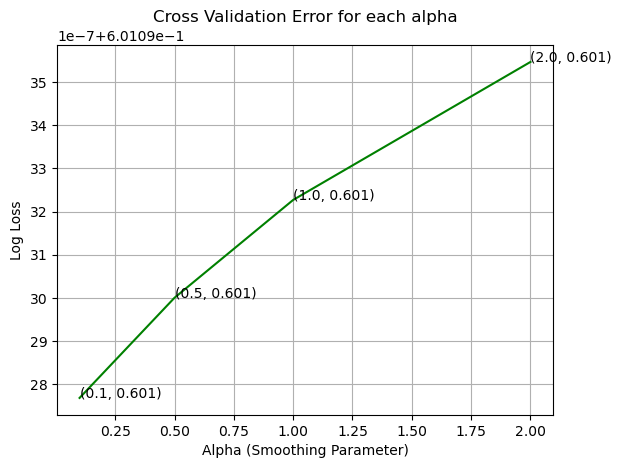

For values of best alpha = 0.1 The train log loss is: 0.6116740335848783
For values of best alpha = 0.1 The cv log loss is: 0.6010927671617243
For values of best alpha = 0.1 The test log loss is: 0.6186742414143291
Number of misclassified points: 0.32
***************Performance metric***************
Accuracy: 68.00%
-------------------- Confusion matrix --------------------


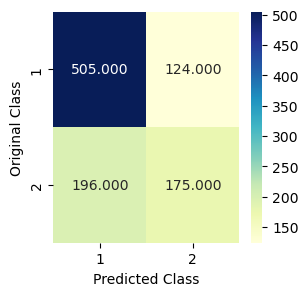

-------------------- Precision matrix (Column Sum=1) --------------------
Precision: 0.5853


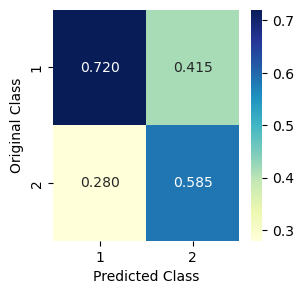

-------------------- Recall matrix (Row Sum=1) --------------------
Recall: 0.4717


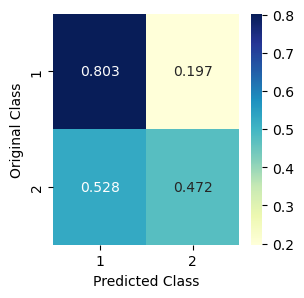

-------------------- F1 Score --------------------
F1 Score: 0.5224


In [54]:
mnb_tfidf_accuracy, mnb_tfidf_precision, mnb_tfidf_recall, mnb_tfidf_f1, mnb_tfidf_train_log_loss, mnb_tfidf_cv_log_loss, mnb_tfidf_test_log_loss, mnb_tfidf_misclassified_points = mnb_model(X_train_tfidf.values, y_train, X_cv_tfidf.values, y_cv, X_test_tfidf.values, y_test, [0.1, 0.5, 1.0, 2.0])

<h3>4.3.4 Logistic Regression Algorithm</h3>

In [55]:
def logistic_regression_sgd_model(X_train, y_train, X_cv, y_cv, X_test, y_test, alpha_values):
    # Step 1: Define a list of alpha values
    alpha_list = alpha_values
    # Initialize an array to store log loss for each value of alpha
    cv_log_error_array = []

    # Step 2: Loop through each value of alpha
    for alpha in alpha_list:
        # Initialize Logistic Regression with SGD classifier with the current value of alpha
        log_reg_sgd = SGDClassifier(loss='log_loss', alpha=alpha, n_jobs=-1)
        # Fit the Logistic Regression with SGD model on the training data
        log_reg_sgd.fit(X_train, y_train)
        # Calibrate the model using sigmoid calibration
        sig_clf_log_reg_sgd = CalibratedClassifierCV(log_reg_sgd, method="sigmoid")
        sig_clf_log_reg_sgd.fit(X_train, y_train)
        # Predict probabilities on the cross-validation set
        sig_clf_probs_cv = sig_clf_log_reg_sgd.predict_proba(X_cv)

        # Calculate log loss and append to the array
        cv_log_error_array.append(log_loss(y_cv, sig_clf_probs_cv, labels=log_reg_sgd.classes_))

        # Print log loss for the current value of alpha
        print('For value of alpha =', alpha, 'The log loss is:', log_loss(y_cv, sig_clf_probs_cv))

    # Step 3: Plot the cross-validation error for each value of alpha
    fig, ax = plt.subplots()
    ax.plot(alpha_list, cv_log_error_array, c='g')
    for i, txt in enumerate(np.round(cv_log_error_array, 3)):
        ax.annotate((alpha_list[i], np.round(txt, 3)), (alpha_list[i], cv_log_error_array[i]))
    plt.grid()
    plt.title("Cross Validation Error for each alpha")
    plt.xlabel("Alpha (Regularization Parameter)")
    plt.ylabel("Log Loss")
    plt.show()

    # Step 4: Identify the best alpha based on minimum log loss
    best_alpha = alpha_list[np.argmin(cv_log_error_array)]
    best_log_reg_sgd = SGDClassifier(loss='log_loss', alpha=best_alpha, n_jobs=-1)
    best_log_reg_sgd.fit(X_train, y_train)

    # Calibrate the best model using sigmoid calibration
    best_sig_clf_log_reg_sgd = CalibratedClassifierCV(best_log_reg_sgd, method="sigmoid")
    best_sig_clf_log_reg_sgd.fit(X_train, y_train)

    # Predict probabilities on the training set for the best model
    predict_y_train = best_sig_clf_log_reg_sgd.predict_proba(X_train)
    log_reg_sgd_train_log_loss = log_loss(y_train, predict_y_train, labels=best_log_reg_sgd.classes_)
    # Print log loss on the training set for the best model
    print('For values of best alpha =', best_alpha, "The train log loss is:", log_loss(y_train, predict_y_train, labels=best_log_reg_sgd.classes_))

    # Predict probabilities on the cross-validation set for the best model
    predict_y_cv = best_sig_clf_log_reg_sgd.predict_proba(X_cv)
    log_reg_sgd_cv_log_loss = log_loss(y_cv, predict_y_cv, labels=best_log_reg_sgd.classes_)
    # Print log loss on the cross-validation set for the best model
    print('For values of best alpha =', best_alpha, "The cv log loss is:", log_reg_sgd_train_log_loss)

    # Predict probabilities on the test set for the best model
    predict_y_test = best_sig_clf_log_reg_sgd.predict_proba(X_test)
    log_reg_sgd_test_log_loss = log_loss(y_test, predict_y_test, labels=best_log_reg_sgd.classes_)
    # Print log loss on the test set for the best model
    print('For values of best alpha =', best_alpha, "The test log loss is:", log_reg_sgd_test_log_loss)

    # Calculate and print the number of misclassified points
    predict_y = best_sig_clf_log_reg_sgd.predict(X_test)
    log_reg_sgd_misclassified_points =  np.count_nonzero((predict_y - y_test) != 0) / y_test.shape[0]
    print("Number of misclassified points:", log_reg_sgd_misclassified_points)

    # Print additional model performance metrics
    log_reg_sgd_accuracy, log_reg_sgd_precision, log_reg_sgd_recall, log_reg_sgd_f1 = model_performance_metrics(y_test, predict_y)
    
    return log_reg_sgd_accuracy, log_reg_sgd_precision, log_reg_sgd_recall, log_reg_sgd_f1, log_reg_sgd_train_log_loss, log_reg_sgd_cv_log_loss, log_reg_sgd_test_log_loss, log_reg_sgd_misclassified_points

For value of alpha = 0.0001 The log loss is: 0.6153699315406171
For value of alpha = 0.001 The log loss is: 0.6128134475172993
For value of alpha = 0.01 The log loss is: 0.5998835432732555
For value of alpha = 0.1 The log loss is: 0.5977175228047638


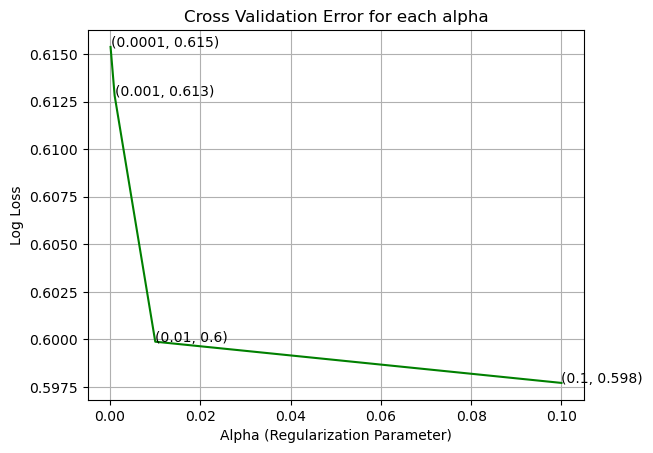

For values of best alpha = 0.1 The train log loss is: 0.6015160298768479
For values of best alpha = 0.1 The cv log loss is: 0.6015160298768479
For values of best alpha = 0.1 The test log loss is: 0.6091220982960316
Number of misclassified points: 0.296
***************Performance metric***************
Accuracy: 70.40%
-------------------- Confusion matrix --------------------


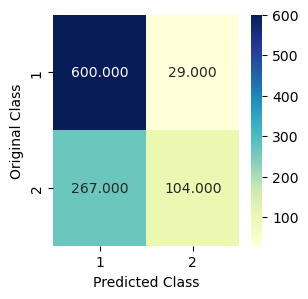

-------------------- Precision matrix (Column Sum=1) --------------------
Precision: 0.7820


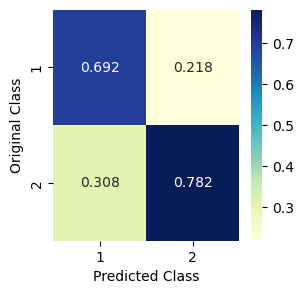

-------------------- Recall matrix (Row Sum=1) --------------------
Recall: 0.2803


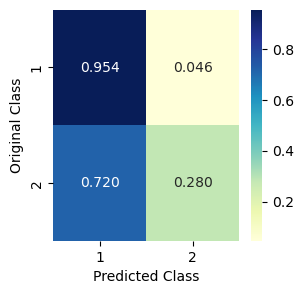

-------------------- F1 Score --------------------
F1 Score: 0.4127


In [56]:
log_reg_sgd_bow_accuracy, log_reg_sgd_bow_precision, log_reg_sgd_bow_recall, log_reg_sgd_bow_f1, log_reg_sgd_bow_train_log_loss, log_reg_sgd_bow_cv_log_loss, log_reg_sgd_bow_test_log_loss, log_reg_sgd_bow_misclassified_points = logistic_regression_sgd_model(X_train_bow.values, y_train, X_cv_bow.values, y_cv, X_test_bow.values, y_test, [0.0001, 0.001, 0.01, 0.1])

For value of alpha = 0.0001 The log loss is: 0.5920082104929679
For value of alpha = 0.001 The log loss is: 0.6025411270076974
For value of alpha = 0.01 The log loss is: 0.5956029032399515
For value of alpha = 0.1 The log loss is: 0.5977427727044842


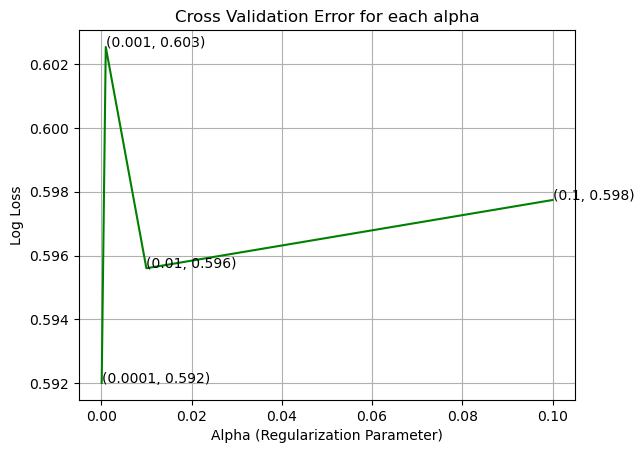

For values of best alpha = 0.0001 The train log loss is: 0.6055008528152033
For values of best alpha = 0.0001 The cv log loss is: 0.6055008528152033
For values of best alpha = 0.0001 The test log loss is: 0.6122542205547967
Number of misclassified points: 0.319
***************Performance metric***************
Accuracy: 68.10%
-------------------- Confusion matrix --------------------


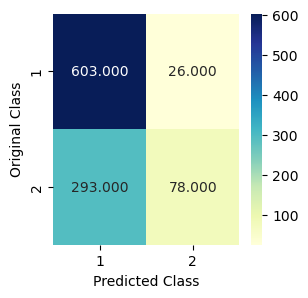

-------------------- Precision matrix (Column Sum=1) --------------------
Precision: 0.7500


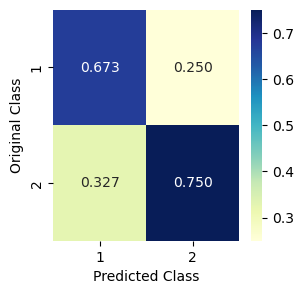

-------------------- Recall matrix (Row Sum=1) --------------------
Recall: 0.2102


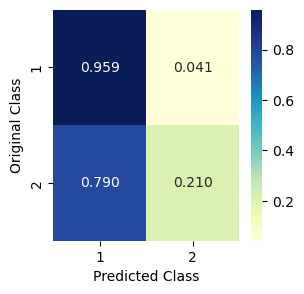

-------------------- F1 Score --------------------
F1 Score: 0.3284


In [57]:
log_reg_sgd_tfidf_accuracy, log_reg_sgd_tfidf_precision, log_reg_sgd_tfidf_recall, log_reg_sgd_tfidf_f1, log_reg_sgd_tfidf_train_log_loss, log_reg_sgd_tfidf_cv_log_loss, log_reg_sgd_tfidf_test_log_loss, log_reg_sgd_tfidf_misclassified_points = logistic_regression_sgd_model(X_train_tfidf.values, y_train, X_cv_tfidf.values, y_cv, X_test_tfidf.values, y_test, [0.0001, 0.001, 0.01, 0.1])

For value of alpha = 0.0001 The log loss is: 0.593604144795866
For value of alpha = 0.001 The log loss is: 0.6129802159929356
For value of alpha = 0.01 The log loss is: 0.6076342632629249
For value of alpha = 0.1 The log loss is: 0.595662693458999


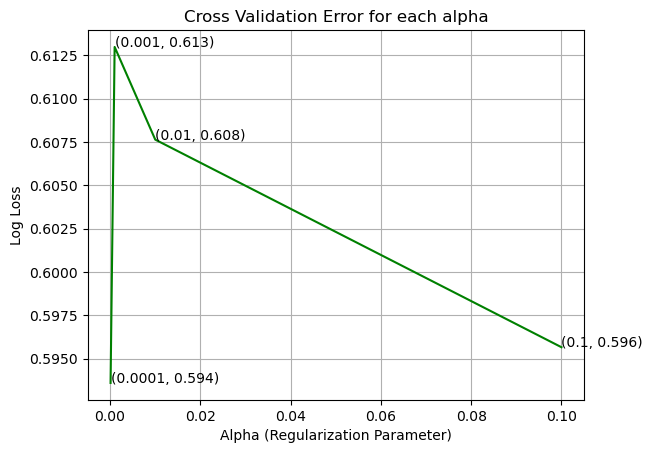

For values of best alpha = 0.0001 The train log loss is: 0.6021900735341313
For values of best alpha = 0.0001 The cv log loss is: 0.6021900735341313
For values of best alpha = 0.0001 The test log loss is: 0.6108311176047988
Number of misclassified points: 0.325
***************Performance metric***************
Accuracy: 67.50%
-------------------- Confusion matrix --------------------


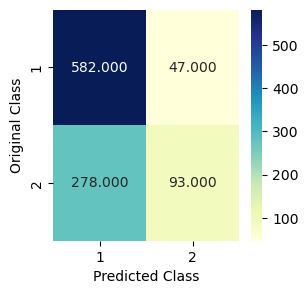

-------------------- Precision matrix (Column Sum=1) --------------------
Precision: 0.6643


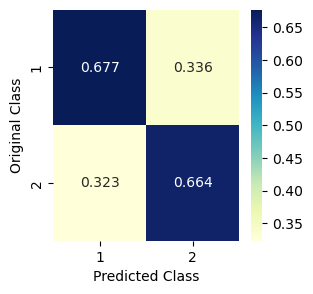

-------------------- Recall matrix (Row Sum=1) --------------------
Recall: 0.2507


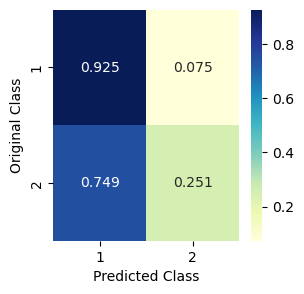

-------------------- F1 Score --------------------
F1 Score: 0.3640


In [58]:
log_reg_sgd_w2v_accuracy, log_reg_sgd_w2v_precision, log_reg_sgd_w2v_recall, log_reg_sgd_w2v_f1, log_reg_sgd_w2v_train_log_loss, log_reg_sgd_w2v_cv_log_loss, log_reg_sgd_w2v_test_log_loss, log_reg_sgd_w2v_misclassified_points = logistic_regression_sgd_model(X_train_w2v.values, y_train, X_cv_w2v.values, y_cv, X_test_w2v.values, y_test, [0.0001, 0.001, 0.01, 0.1])

<h3>4.3.5 Linear SVM Algorithm</h3>

In [59]:
def linear_svm_sgd_model(X_train, y_train, X_cv, y_cv, X_test, y_test, alpha_values):
    # Step 1: Define a list of alpha values
    alpha_list = alpha_values
    # Initialize an array to store log loss for each value of alpha
    cv_log_error_array = []

    # Step 2: Loop through each value of alpha
    for alpha in alpha_list:
        # Initialize Linear SVM with SGD classifier with the current value of alpha
        linear_svm_sgd = SGDClassifier(loss='hinge', alpha=alpha, n_jobs=-1)
        # Fit the Linear SVM with SGD model on the training data
        linear_svm_sgd.fit(X_train, y_train)
        # Calibrate the model using sigmoid calibration
        sig_clf_linear_svm_sgd = CalibratedClassifierCV(linear_svm_sgd, method="sigmoid")
        sig_clf_linear_svm_sgd.fit(X_train, y_train)
        # Predict probabilities on the cross-validation set
        sig_clf_probs_cv = sig_clf_linear_svm_sgd.predict_proba(X_cv)

        # Calculate log loss and append to the array
        cv_log_error_array.append(log_loss(y_cv, sig_clf_probs_cv, labels=linear_svm_sgd.classes_))

        # Print log loss for the current value of alpha
        print('For value of alpha =', alpha, 'The log loss is:', log_loss(y_cv, sig_clf_probs_cv))

    # Step 3: Plot the cross-validation error for each value of alpha
    fig, ax = plt.subplots()
    ax.plot(alpha_list, cv_log_error_array, c='g')
    for i, txt in enumerate(np.round(cv_log_error_array, 3)):
        ax.annotate((alpha_list[i], np.round(txt, 3)), (alpha_list[i], cv_log_error_array[i]))
    plt.grid()
    plt.title("Cross Validation Error for each alpha")
    plt.xlabel("Alpha (Regularization Parameter)")
    plt.ylabel("Log Loss")
    plt.show()

    # Step 4: Identify the best alpha based on minimum log loss
    best_alpha = alpha_list[np.argmin(cv_log_error_array)]
    best_linear_svm_sgd = SGDClassifier(loss='hinge', alpha=best_alpha, n_jobs=-1)
    best_linear_svm_sgd.fit(X_train, y_train)

    # Calibrate the best model using sigmoid calibration
    best_sig_clf_linear_svm_sgd = CalibratedClassifierCV(best_linear_svm_sgd, method="sigmoid")
    best_sig_clf_linear_svm_sgd.fit(X_train, y_train)

    # Predict probabilities on the training set for the best model
    predict_y_train = best_sig_clf_linear_svm_sgd.predict_proba(X_train)
    linear_svm_sgd_train_log_loss = log_loss(y_train, predict_y_train, labels=best_linear_svm_sgd.classes_)
    # Print log loss on the training set for the best model
    print('For values of best alpha =', best_alpha, "The train log loss is:", )

    # Predict probabilities on the cross-validation set for the best model
    predict_y_cv = best_sig_clf_linear_svm_sgd.predict_proba(X_cv)
    linear_svm_sgd_cv_log_loss = log_loss(y_cv, predict_y_cv, labels=best_linear_svm_sgd.classes_)
    # Print log loss on the cross-validation set for the best model
    print('For values of best alpha =', best_alpha, "The cv log loss is:", )

    # Predict probabilities on the test set for the best model
    predict_y_test = best_sig_clf_linear_svm_sgd.predict_proba(X_test)
    linear_svm_sgd_test_log_loss = log_loss(y_test, predict_y_test, labels=best_linear_svm_sgd.classes_)
    # Print log loss on the test set for the best model
    print('For values of best alpha =', best_alpha, "The test log loss is:", )

    # Calculate and print the number of misclassified points
    predict_y = best_sig_clf_linear_svm_sgd.predict(X_test)
    linear_svm_sgd_misclassified_points = np.count_nonzero((predict_y - y_test) != 0) / y_test.shape[0]
    print("Number of misclassified points:", linear_svm_sgd_misclassified_points)

    # Print additional model performance metrics
    linear_svm_sgd_accuracy, linear_svm_sgd_precision, linear_svm_sgd_recall, linear_svm_sgd_f1 = model_performance_metrics(y_test, predict_y)
    
    return linear_svm_sgd_accuracy, linear_svm_sgd_precision, linear_svm_sgd_recall, linear_svm_sgd_f1, linear_svm_sgd_train_log_loss, linear_svm_sgd_cv_log_loss, linear_svm_sgd_test_log_loss, linear_svm_sgd_misclassified_points

For value of alpha = 0.0001 The log loss is: 0.5986488258606478
For value of alpha = 0.001 The log loss is: 0.6007055448097937
For value of alpha = 0.01 The log loss is: 0.5987342827317035
For value of alpha = 0.1 The log loss is: 0.5980221448561105


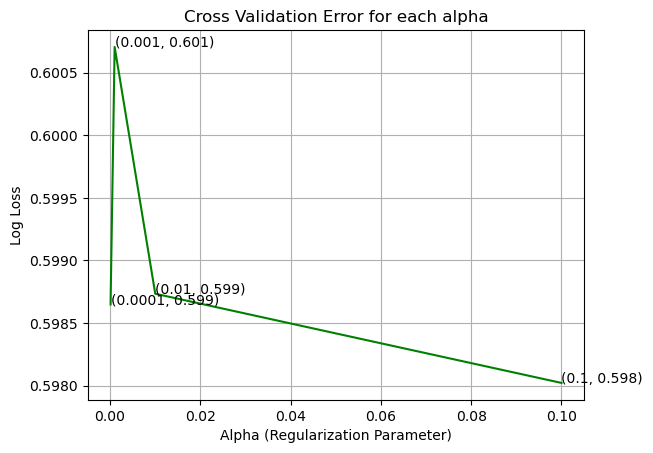

For values of best alpha = 0.1 The train log loss is:
For values of best alpha = 0.1 The cv log loss is:
For values of best alpha = 0.1 The test log loss is:
Number of misclassified points: 0.305
***************Performance metric***************
Accuracy: 69.50%
-------------------- Confusion matrix --------------------


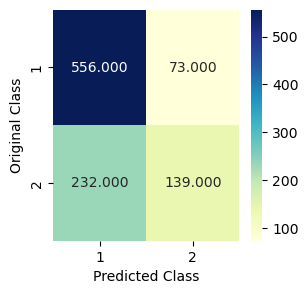

-------------------- Precision matrix (Column Sum=1) --------------------
Precision: 0.6557


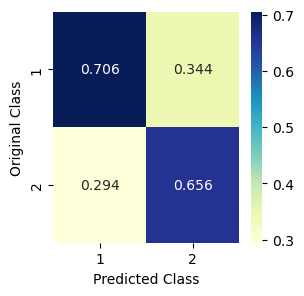

-------------------- Recall matrix (Row Sum=1) --------------------
Recall: 0.3747


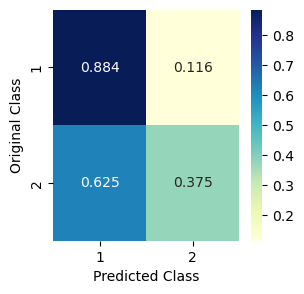

-------------------- F1 Score --------------------
F1 Score: 0.4768


In [60]:
linear_svm_sgd_bow_accuracy, linear_svm_sgd_bow_precision, linear_svm_sgd_bow_recall, linear_svm_sgd_bow_f1, linear_svm_sgd_bow_train_log_loss, linear_svm_sgd_bow_cv_log_loss, linear_svm_sgd_bow_test_log_loss, linear_svm_sgd_bow_misclassified_points = linear_svm_sgd_model(X_train_bow.values, y_train, X_cv_bow.values, y_cv, X_test_bow.values, y_test, [0.0001, 0.001, 0.01, 0.1])

For value of alpha = 0.0001 The log loss is: 0.6015670462296387
For value of alpha = 0.001 The log loss is: 0.5924270280817153
For value of alpha = 0.01 The log loss is: 0.5993728657755468
For value of alpha = 0.1 The log loss is: 0.603337761322949


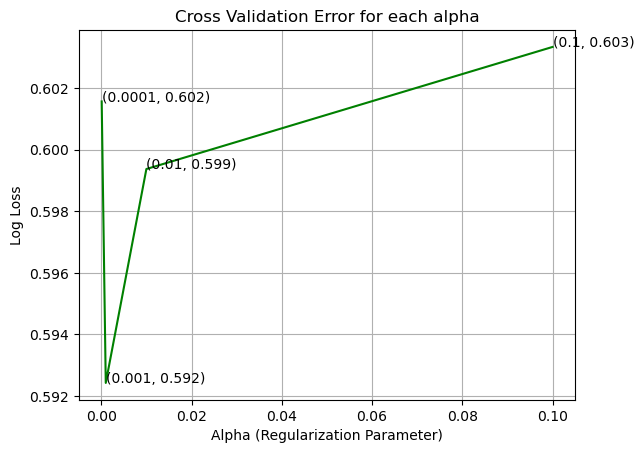

For values of best alpha = 0.001 The train log loss is:
For values of best alpha = 0.001 The cv log loss is:
For values of best alpha = 0.001 The test log loss is:
Number of misclassified points: 0.299
***************Performance metric***************
Accuracy: 70.10%
-------------------- Confusion matrix --------------------


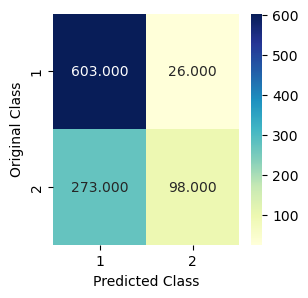

-------------------- Precision matrix (Column Sum=1) --------------------
Precision: 0.7903


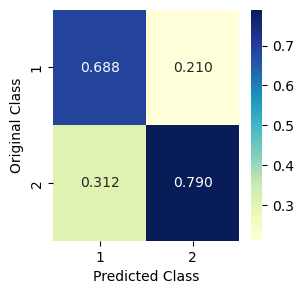

-------------------- Recall matrix (Row Sum=1) --------------------
Recall: 0.2642


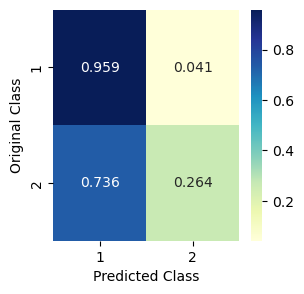

-------------------- F1 Score --------------------
F1 Score: 0.3960


In [61]:
linear_svm_sgd_tfidf_accuracy, linear_svm_sgd_tfidf_precision, linear_svm_sgd_tfidf_recall, linear_svm_sgd_tfidf_f1, linear_svm_sgd_tfidf_train_log_loss, linear_svm_sgd_tfidf_cv_log_loss, linear_svm_sgd_tfidf_test_log_loss, linear_svm_sgd_tfidf_misclassified_points = linear_svm_sgd_model(X_train_tfidf.values, y_train, X_cv_tfidf.values, y_cv, X_test_tfidf.values, y_test, [0.0001, 0.001, 0.01, 0.1])

For value of alpha = 0.0001 The log loss is: 0.5911808085577256
For value of alpha = 0.001 The log loss is: 0.6029624907294567
For value of alpha = 0.01 The log loss is: 0.612533885306867
For value of alpha = 0.1 The log loss is: 0.6127896800994282


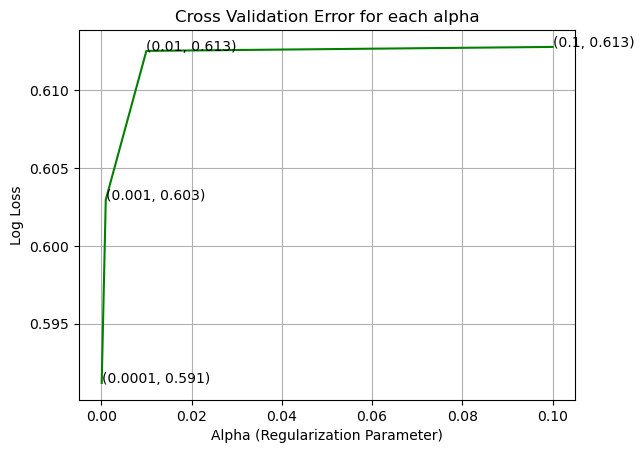

For values of best alpha = 0.0001 The train log loss is:
For values of best alpha = 0.0001 The cv log loss is:
For values of best alpha = 0.0001 The test log loss is:
Number of misclassified points: 0.3
***************Performance metric***************
Accuracy: 70.00%
-------------------- Confusion matrix --------------------


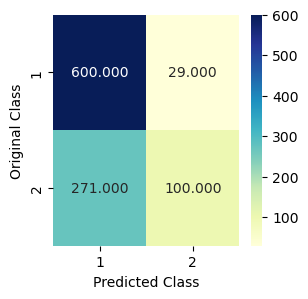

-------------------- Precision matrix (Column Sum=1) --------------------
Precision: 0.7752


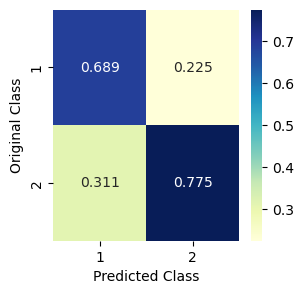

-------------------- Recall matrix (Row Sum=1) --------------------
Recall: 0.2695


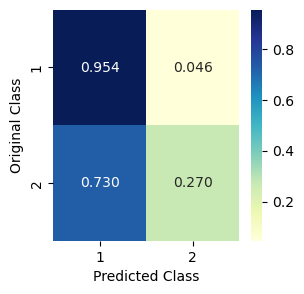

-------------------- F1 Score --------------------
F1 Score: 0.4000


In [62]:
linear_svm_sgd_w2v_accuracy, linear_svm_sgd_w2v_precision, linear_svm_sgd_w2v_recall, linear_svm_sgd_w2v_f1, linear_svm_sgd_w2v_train_log_loss, linear_svm_sgd_w2v_cv_log_loss, linear_svm_sgd_w2v_test_log_loss, linear_svm_sgd_w2v_misclassified_points = linear_svm_sgd_model(X_train_w2v.values, y_train, X_cv_w2v.values, y_cv, X_test_w2v.values, y_test, [0.0001, 0.001, 0.01, 0.1])

<h3>4.3.6 Decision Tree algorithm</h3>

In [63]:
def decision_tree_model(X_train, y_train, X_cv, y_cv, X_test, y_test, max_depth_values, min_samples_split_values, min_samples_leaf_values):
    # Initialize arrays to store log loss for each combination of hyperparameters
    cv_log_error_depth = np.zeros(len(max_depth_values))
    cv_log_error_split = np.zeros(len(min_samples_split_values))
    cv_log_error_leaf = np.zeros(len(min_samples_leaf_values))
    cv_log_error_array = np.zeros((len(max_depth_values), len(min_samples_split_values), len(min_samples_leaf_values)))

    # Step 2: Loop through each value of max_depth
    for i, max_depth in enumerate(max_depth_values):
        # Initialize Decision Tree classifier with the current max_depth value
        dtree = DecisionTreeClassifier(max_depth=max_depth)
        # Fit the Decision Tree model on the training data
        dtree.fit(X_train, y_train)
        # Predict probabilities on the cross-validation set
        sig_clf_dtree = CalibratedClassifierCV(dtree, method="sigmoid")
        sig_clf_dtree.fit(X_train, y_train)
        sig_clf_probs_cv = sig_clf_dtree.predict_proba(X_cv)
        # Calculate log loss and store in the array
        cv_log_error_depth[i] = log_loss(y_cv, sig_clf_probs_cv, labels=dtree.classes_)

    # Plot the cross-validation error for each value of max_depth
    fig, ax = plt.subplots()
    ax.plot(max_depth_values, cv_log_error_depth, marker='o')
    for i, txt in enumerate(np.round(cv_log_error_depth, 3)):
        ax.annotate((max_depth_values[i], np.round(txt, 3)), (max_depth_values[i], cv_log_error_depth[i]))
    plt.grid()
    plt.xlabel('Max Depth')
    plt.ylabel('Log Loss')
    plt.title("Cross Validation Error for each value of max_depth")
    plt.show()

    # Step 3: Loop through each value of min_samples_split
    for i, min_samples_split in enumerate(min_samples_split_values):
        # Initialize Decision Tree classifier with the current min_samples_split value
        dtree = DecisionTreeClassifier(min_samples_split=min_samples_split)
        dtree.fit(X_train, y_train)
        sig_clf_dtree = CalibratedClassifierCV(dtree, method="sigmoid")
        sig_clf_dtree.fit(X_train, y_train)
        sig_clf_probs_cv = sig_clf_dtree.predict_proba(X_cv)
        cv_log_error_split[i] = log_loss(y_cv, sig_clf_probs_cv, labels=dtree.classes_)

    # Plot the cross-validation error for each value of min_samples_split
    fig, ax = plt.subplots()
    ax.plot(min_samples_split_values, cv_log_error_split, marker='o')
    for i, txt in enumerate(np.round(cv_log_error_split, 3)):
        ax.annotate((min_samples_split_values[i], np.round(txt, 3)), (min_samples_split_values[i], cv_log_error_split[i]))
    plt.grid()
    plt.xlabel('Min Samples Split')
    plt.ylabel('Log Loss')
    plt.title("Cross Validation Error for each value of min_samples_split")
    plt.show()

    # Step 4: Loop through each value of min_samples_leaf
    for i, min_samples_leaf in enumerate(min_samples_leaf_values):
        dtree = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
        dtree.fit(X_train, y_train)
        sig_clf_dtree = CalibratedClassifierCV(dtree, method="sigmoid")
        sig_clf_dtree.fit(X_train, y_train)
        sig_clf_probs_cv = sig_clf_dtree.predict_proba(X_cv)
        cv_log_error_leaf[i] = log_loss(y_cv, sig_clf_probs_cv, labels=dtree.classes_)

    # Plot the cross-validation error for each value of min_samples_leaf
    fig, ax = plt.subplots()
    ax.plot(min_samples_leaf_values, cv_log_error_leaf, marker='o')
    for i, txt in enumerate(np.round(cv_log_error_leaf, 3)):
        ax.annotate((min_samples_leaf_values[i], np.round(txt, 3)), (min_samples_leaf_values[i], cv_log_error_leaf[i]))
    plt.grid()
    plt.xlabel('Min Samples Leaf')
    plt.ylabel('Log Loss')
    plt.title("Cross Validation Error for each value of min_samples_leaf")
    plt.show()

    # Step 5: Loop through each combination of hyperparameter values and plot graphs
    fig, axs = plt.subplots(len(max_depth_values), len(min_samples_split_values), figsize=(15, 12))
    for i, max_depth in enumerate(max_depth_values):
        for j, min_samples_split in enumerate(min_samples_split_values):
            cv_log_error_leaf = np.zeros(len(min_samples_leaf_values))
            for k, min_samples_leaf in enumerate(min_samples_leaf_values):
                dtree = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=42)
                dtree.fit(X_train, y_train)
                sig_clf_dtree = CalibratedClassifierCV(dtree, method="sigmoid")
                sig_clf_dtree.fit(X_train, y_train)
                sig_clf_probs_cv = sig_clf_dtree.predict_proba(X_cv)
                cv_log_error_array[i, j, k] = log_loss(y_cv, sig_clf_probs_cv, labels=dtree.classes_)
                cv_log_error_leaf[k] = cv_log_error_array[i, j, k]
                print('For max_depth = {}, min_samples_split = {}, min_samples_leaf = {}, log loss is: {}'.format(max_depth, min_samples_split, min_samples_leaf, cv_log_error_array[i, j, k]))


            axs[i, j].plot(min_samples_leaf_values, cv_log_error_leaf, marker='o')
            axs[i, j].set_title(f'Max Depth: {max_depth}, Min Samples Split: {min_samples_split}')
            axs[i, j].set_xlabel('Min Samples Leaf')
            axs[i, j].set_ylabel('Log Loss')
            axs[i, j].grid()

    plt.tight_layout()
    plt.show()

    # Identify the best hyperparameter values based on minimum log loss
    best_indices = np.unravel_index(np.argmin(cv_log_error_array), cv_log_error_array.shape)
    best_max_depth = max_depth_values[best_indices[0]]
    best_min_samples_split = min_samples_split_values[best_indices[1]]
    best_min_samples_leaf = min_samples_leaf_values[best_indices[2]]

    # Train the best model using the identified hyperparameter values
    best_dtree = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf, random_state=42)
    best_dtree.fit(X_train, y_train)
    best_sig_clf_dtree = CalibratedClassifierCV(best_dtree, method="sigmoid")
    best_sig_clf_dtree.fit(X_train, y_train)
    # Predict probabilities on the training set for the best model
    predict_y_train = best_sig_clf_dtree.predict_proba(X_train)
    dtree_train_log_loss = log_loss(y_train, predict_y_train, labels=best_dtree.classes_)
    # Print log loss on the training set for the best model
    print('For values of best max_depth = {}, min_samples_split = {}, min_samples_leaf = {}, log loss on training set is: {}'.format(best_max_depth, best_min_samples_split, best_min_samples_leaf, dtree_train_log_loss))

    # Predict probabilities on the cross-validation set for the best model
    predict_y_cv = best_dtree.predict_proba(X_cv)
    dtree_cv_log_loss = log_loss(y_cv, predict_y_cv, labels=best_dtree.classes_)
    # Print log loss on the cross-validation set for the best model
    print('For values of best max_depth = {}, min_samples_split = {}, min_samples_leaf = {}, log loss on cross-validation set is: {}'.format(best_max_depth, best_min_samples_split, best_min_samples_leaf, dtree_cv_log_loss))

    # Predict probabilities on the test set for the best model
    predict_y_test = best_dtree.predict_proba(X_test)
    dtree_test_log_loss = log_loss(y_test, predict_y_test, labels=best_dtree.classes_)
    # Print log loss on the test set for the best model
    print('For values of best max_depth = {}, min_samples_split = {}, min_samples_leaf = {}, log loss on test set is: {}'.format(best_max_depth, best_min_samples_split, best_min_samples_leaf, dtree_test_log_loss))

    # Predict on the test set and evaluate model performance
    predict_y = best_sig_clf_dtree.predict(X_test)
    dtree_misclassified_points = np.count_nonzero((best_sig_clf_dtree.predict(X_test) - y_test)) / y_test.shape[0]
    print("Number of misclassified points:", dtree_misclassified_points)
    # Print additional model performance metrics
    dtree_accuracy, dtree_precision, dtree_recall, dtree_f1 = model_performance_metrics(y_test, predict_y)
    
    return dtree_accuracy, dtree_precision, dtree_recall, dtree_f1, dtree_train_log_loss, dtree_cv_log_loss, dtree_test_log_loss, dtree_misclassified_points

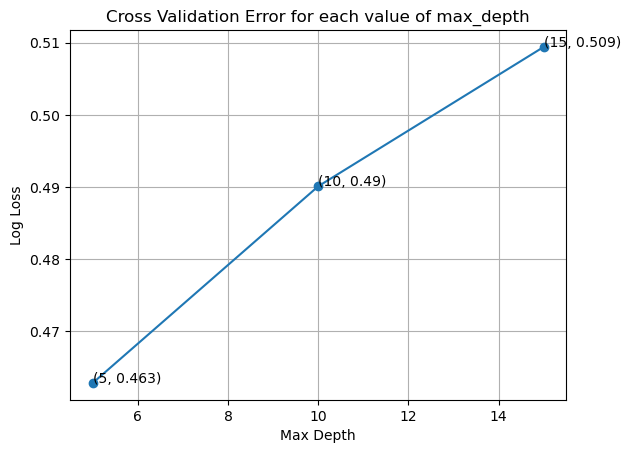

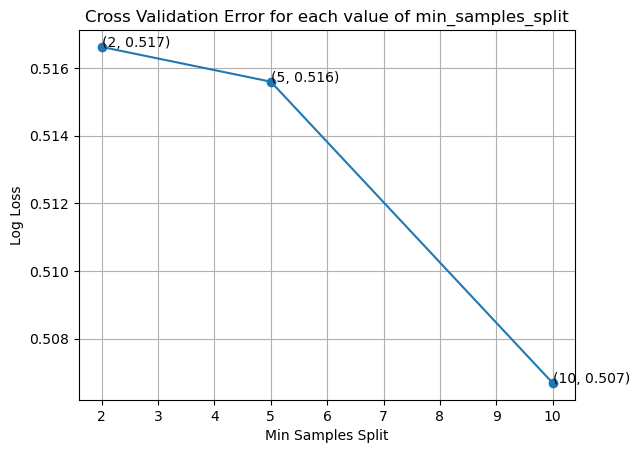

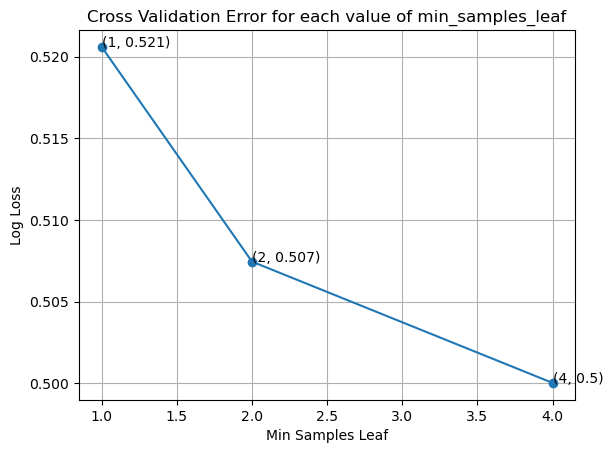

For max_depth = 5, min_samples_split = 2, min_samples_leaf = 1, log loss is: 0.46315427322850605
For max_depth = 5, min_samples_split = 2, min_samples_leaf = 2, log loss is: 0.4600485613937046
For max_depth = 5, min_samples_split = 2, min_samples_leaf = 4, log loss is: 0.4582264483159511
For max_depth = 5, min_samples_split = 5, min_samples_leaf = 1, log loss is: 0.46295857316762024
For max_depth = 5, min_samples_split = 5, min_samples_leaf = 2, log loss is: 0.45988025921187015
For max_depth = 5, min_samples_split = 5, min_samples_leaf = 4, log loss is: 0.4582264483159511
For max_depth = 5, min_samples_split = 10, min_samples_leaf = 1, log loss is: 0.46284796605499345
For max_depth = 5, min_samples_split = 10, min_samples_leaf = 2, log loss is: 0.4598727485200925
For max_depth = 5, min_samples_split = 10, min_samples_leaf = 4, log loss is: 0.458335354492365
For max_depth = 10, min_samples_split = 2, min_samples_leaf = 1, log loss is: 0.49214883270680443
For max_depth = 10, min_samples_

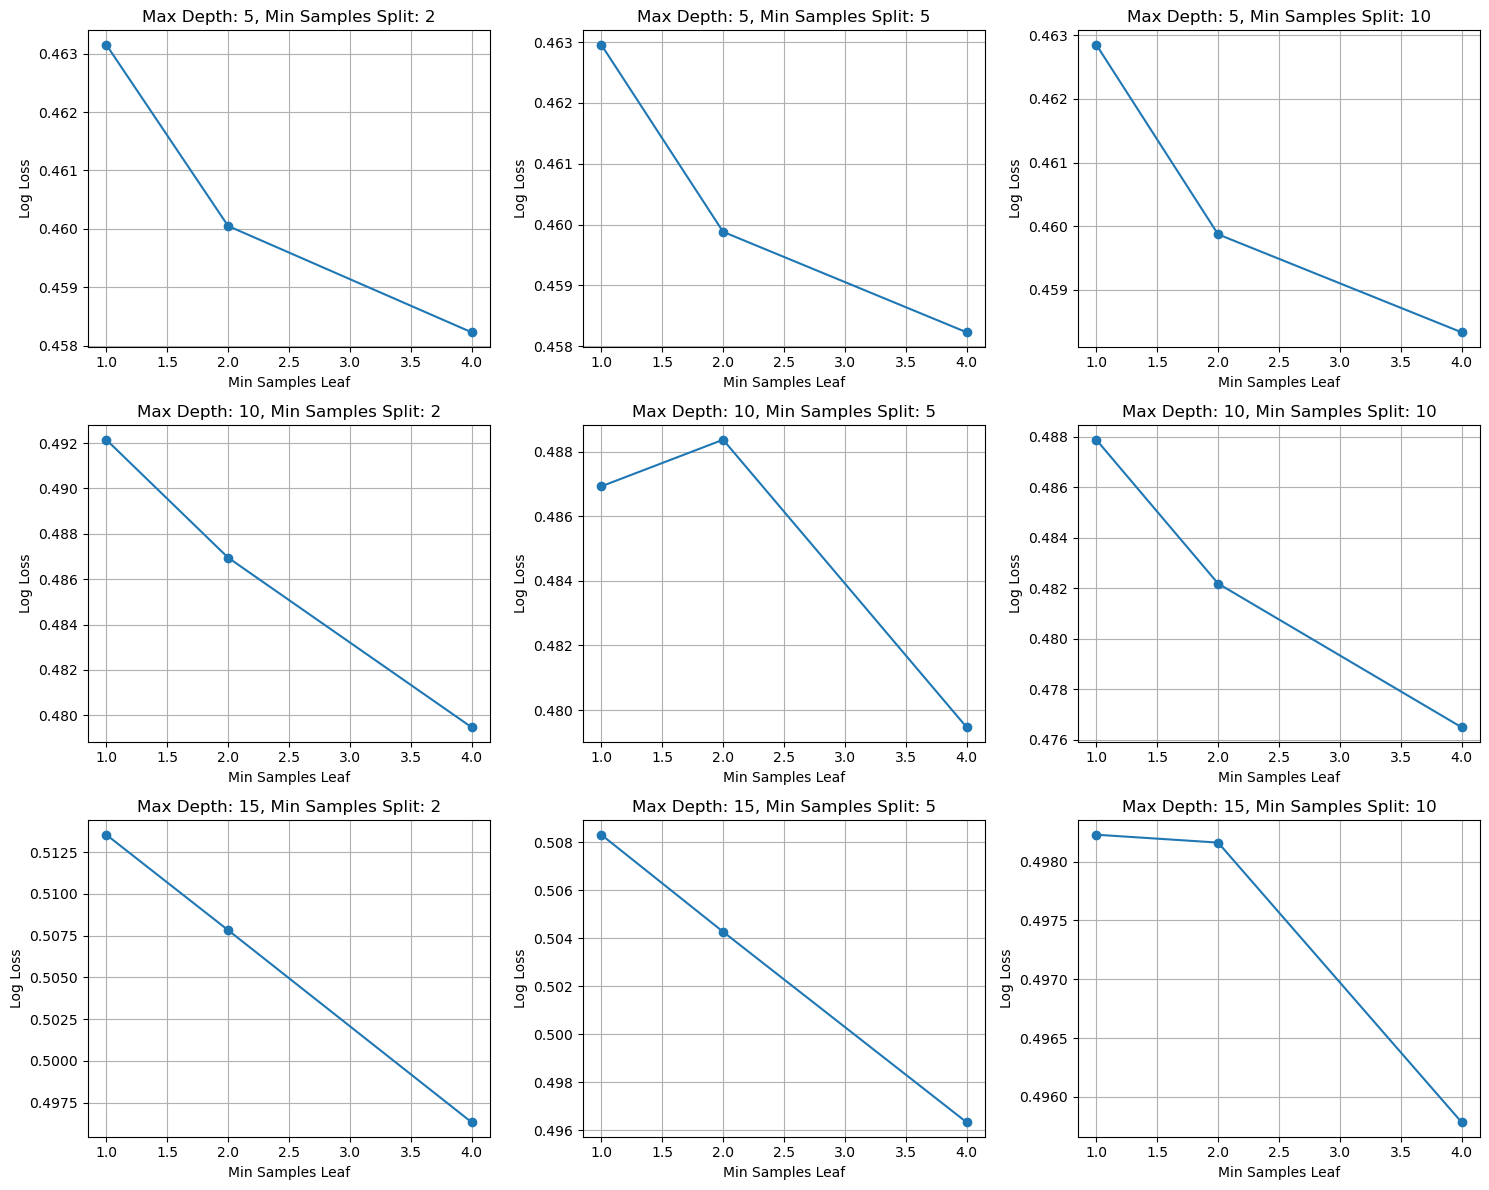

For values of best max_depth = 5, min_samples_split = 2, min_samples_leaf = 4, log loss on training set is: 0.41631549330461554
For values of best max_depth = 5, min_samples_split = 2, min_samples_leaf = 4, log loss on cross-validation set is: 0.46195089562645636
For values of best max_depth = 5, min_samples_split = 2, min_samples_leaf = 4, log loss on test set is: 0.5491908604487363
Number of misclassified points: 0.245
***************Performance metric***************
Accuracy: 75.50%
-------------------- Confusion matrix --------------------


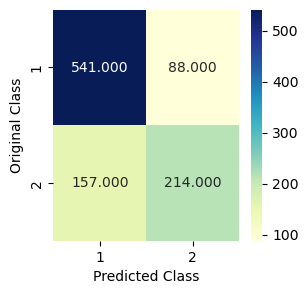

-------------------- Precision matrix (Column Sum=1) --------------------
Precision: 0.7086


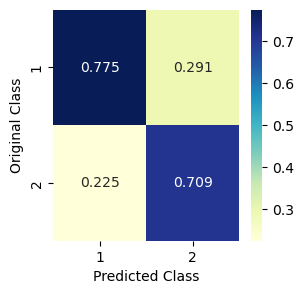

-------------------- Recall matrix (Row Sum=1) --------------------
Recall: 0.5768


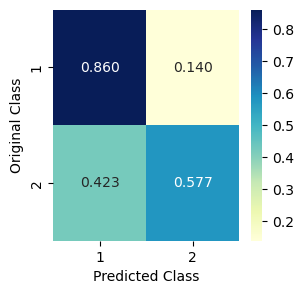

-------------------- F1 Score --------------------
F1 Score: 0.6360


In [64]:
max_depth_values = [5, 10, 15]
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values = [1, 2, 4]

dtree_bow_accuracy, dtree_bow_precision, dtree_bow_recall, dtree_bow_f1, dtree_bow_train_log_loss, dtree_bow_cv_log_loss, dtree_bow_test_log_loss, dtree_bow_misclassified_points = decision_tree_model(X_train_bow.values, y_train, X_cv_bow.values, y_cv, X_test_bow.values, y_test, max_depth_values, min_samples_split_values, min_samples_leaf_values)

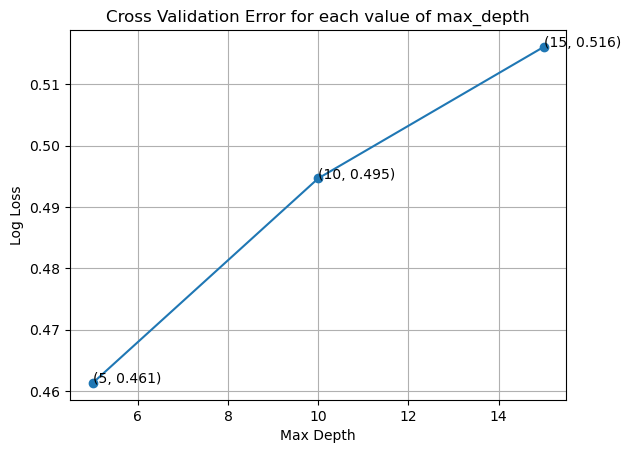

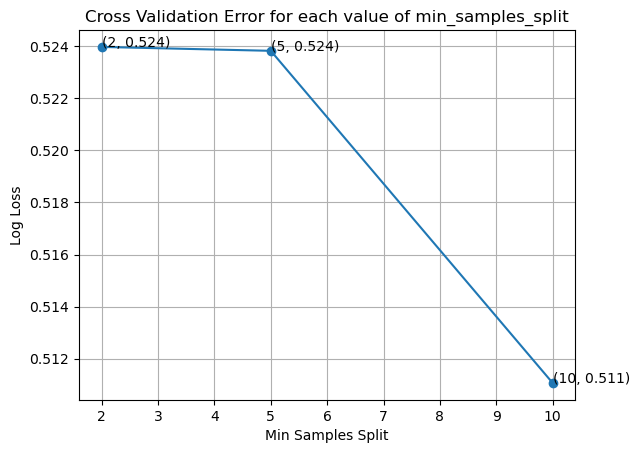

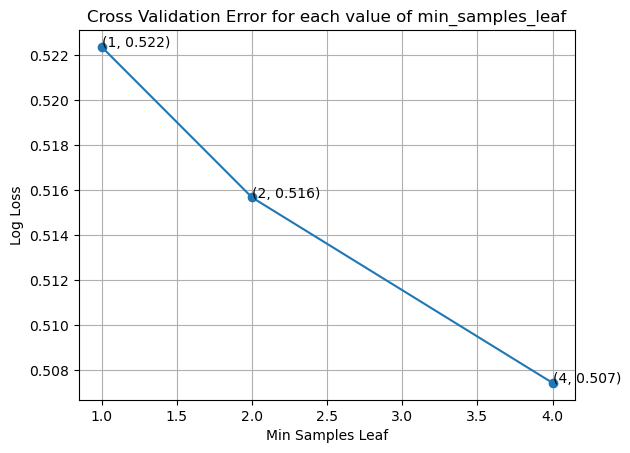

For max_depth = 5, min_samples_split = 2, min_samples_leaf = 1, log loss is: 0.46090937227821144
For max_depth = 5, min_samples_split = 2, min_samples_leaf = 2, log loss is: 0.46079716489638967
For max_depth = 5, min_samples_split = 2, min_samples_leaf = 4, log loss is: 0.45931746972223747
For max_depth = 5, min_samples_split = 5, min_samples_leaf = 1, log loss is: 0.4612528629405767
For max_depth = 5, min_samples_split = 5, min_samples_leaf = 2, log loss is: 0.46144701797910076
For max_depth = 5, min_samples_split = 5, min_samples_leaf = 4, log loss is: 0.45931746972223747
For max_depth = 5, min_samples_split = 10, min_samples_leaf = 1, log loss is: 0.46157646770078387
For max_depth = 5, min_samples_split = 10, min_samples_leaf = 2, log loss is: 0.4613385770911434
For max_depth = 5, min_samples_split = 10, min_samples_leaf = 4, log loss is: 0.4594280894141552
For max_depth = 10, min_samples_split = 2, min_samples_leaf = 1, log loss is: 0.4946051856677788
For max_depth = 10, min_sample

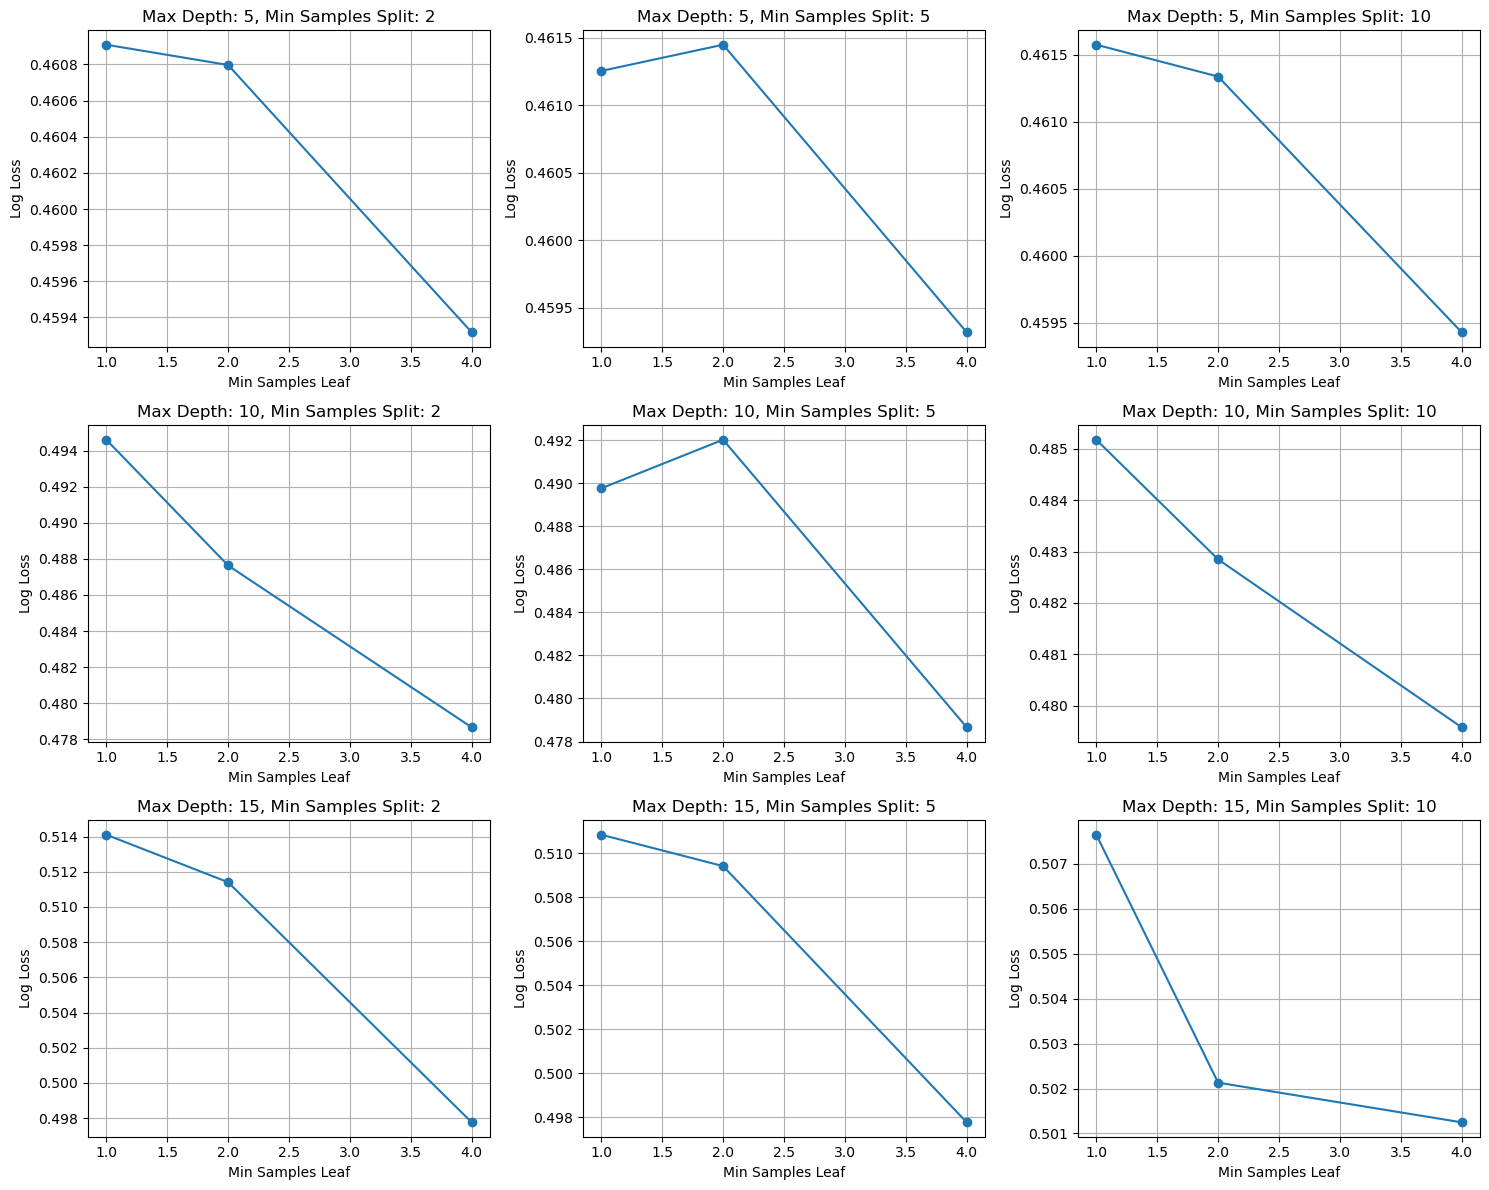

For values of best max_depth = 5, min_samples_split = 2, min_samples_leaf = 4, log loss on training set is: 0.41679947656130595
For values of best max_depth = 5, min_samples_split = 2, min_samples_leaf = 4, log loss on cross-validation set is: 0.4646960702548011
For values of best max_depth = 5, min_samples_split = 2, min_samples_leaf = 4, log loss on test set is: 0.55388938435762
Number of misclassified points: 0.248
***************Performance metric***************
Accuracy: 75.20%
-------------------- Confusion matrix --------------------


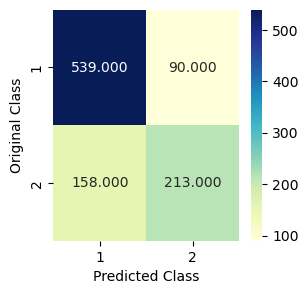

-------------------- Precision matrix (Column Sum=1) --------------------
Precision: 0.7030


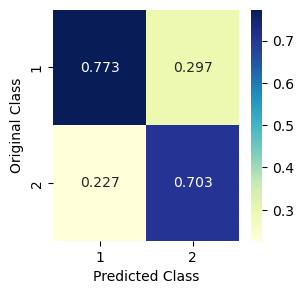

-------------------- Recall matrix (Row Sum=1) --------------------
Recall: 0.5741


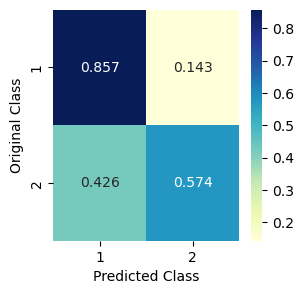

-------------------- F1 Score --------------------
F1 Score: 0.6320


In [65]:
max_depth_values = [5, 10, 15]
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values = [1, 2, 4]

dtree_tfidf_accuracy, dtree_tfidf_precision, dtree_tfidf_recall, dtree_tfidf_f1, dtree_tfidf_train_log_loss, dtree_tfidf_cv_log_loss, dtree_tfidf_test_log_loss, dtree_tfidf_misclassified_points = decision_tree_model(X_train_tfidf.values, y_train, X_cv_tfidf.values, y_cv, X_test_tfidf.values, y_test, max_depth_values, min_samples_split_values, min_samples_leaf_values)

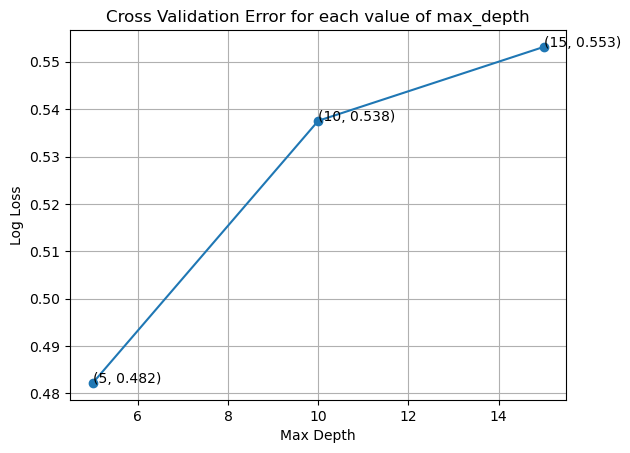

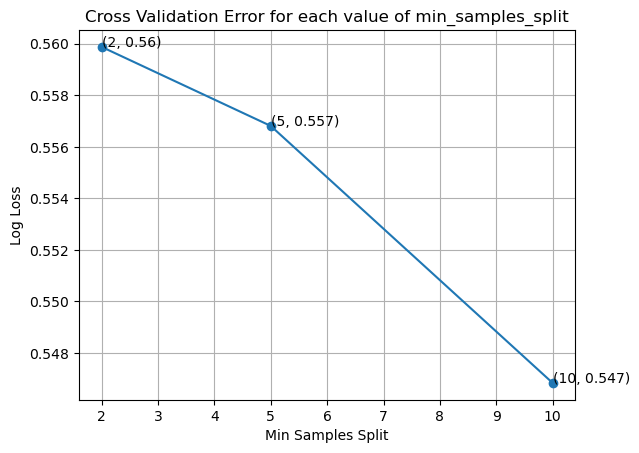

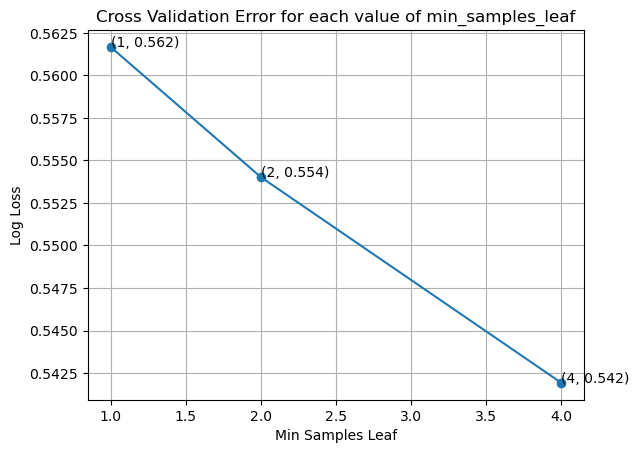

For max_depth = 5, min_samples_split = 2, min_samples_leaf = 1, log loss is: 0.48305787758816676
For max_depth = 5, min_samples_split = 2, min_samples_leaf = 2, log loss is: 0.4822556713760916
For max_depth = 5, min_samples_split = 2, min_samples_leaf = 4, log loss is: 0.4790035087570513
For max_depth = 5, min_samples_split = 5, min_samples_leaf = 1, log loss is: 0.48305787758816676
For max_depth = 5, min_samples_split = 5, min_samples_leaf = 2, log loss is: 0.4822556713760916
For max_depth = 5, min_samples_split = 5, min_samples_leaf = 4, log loss is: 0.4790035087570513
For max_depth = 5, min_samples_split = 10, min_samples_leaf = 1, log loss is: 0.48167473782899334
For max_depth = 5, min_samples_split = 10, min_samples_leaf = 2, log loss is: 0.4811971661291837
For max_depth = 5, min_samples_split = 10, min_samples_leaf = 4, log loss is: 0.4784934022542771
For max_depth = 10, min_samples_split = 2, min_samples_leaf = 1, log loss is: 0.5347233493758842
For max_depth = 10, min_samples_s

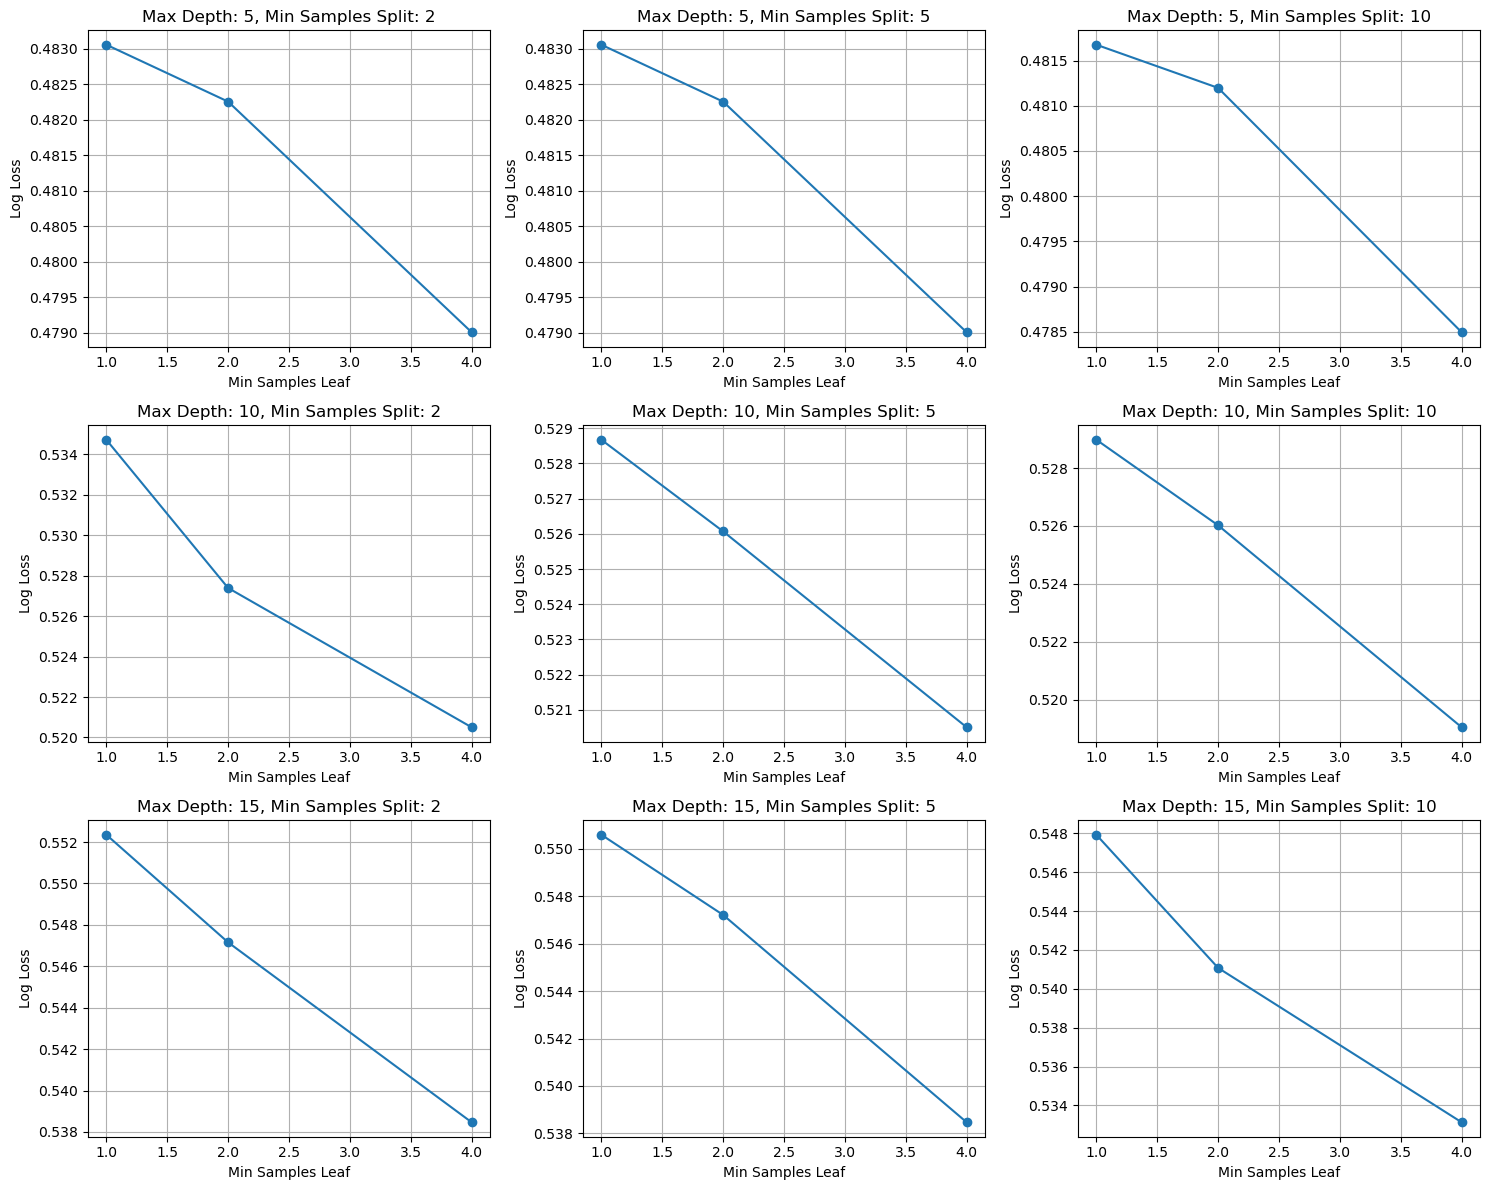

For values of best max_depth = 5, min_samples_split = 10, min_samples_leaf = 4, log loss on training set is: 0.4272086480730635
For values of best max_depth = 5, min_samples_split = 10, min_samples_leaf = 4, log loss on cross-validation set is: 0.5374722430387218
For values of best max_depth = 5, min_samples_split = 10, min_samples_leaf = 4, log loss on test set is: 0.5918081616901635
Number of misclassified points: 0.274
***************Performance metric***************
Accuracy: 72.60%
-------------------- Confusion matrix --------------------


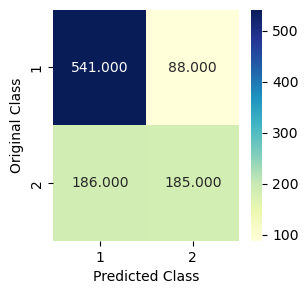

-------------------- Precision matrix (Column Sum=1) --------------------
Precision: 0.6777


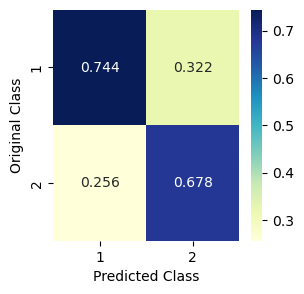

-------------------- Recall matrix (Row Sum=1) --------------------
Recall: 0.4987


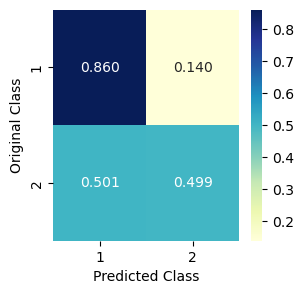

-------------------- F1 Score --------------------
F1 Score: 0.5745


In [66]:
max_depth_values = [5, 10, 15]
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values = [1, 2, 4]

dtree_w2v_accuracy, dtree_w2v_precision, dtree_w2v_recall, dtree_w2v_f1, dtree_w2v_train_log_loss, dtree_w2v_cv_log_loss, dtree_w2v_test_log_loss, dtree_w2v_misclassified_points = decision_tree_model(X_train_w2v.values, y_train, X_cv_w2v.values, y_cv, X_test_w2v.values, y_test, max_depth_values, min_samples_split_values, min_samples_leaf_values)

<h3>4.3.7 Random Forest Algorithm</h3>

In [67]:
def random_forest_model(X_train, y_train, X_cv, y_cv, X_test, y_test, n_estimators_values, max_depth_values, min_samples_split_values, min_samples_leaf_values):
    # Initialize arrays to store log loss for each combination of hyperparameters
    cv_log_error_estimators = np.zeros(len(n_estimators_values))
    cv_log_error_depth = np.zeros(len(max_depth_values))
    cv_log_error_split = np.zeros(len(min_samples_split_values))
    cv_log_error_leaf = np.zeros(len(min_samples_leaf_values))
    cv_log_error_array = np.zeros((len(n_estimators_values), len(max_depth_values), len(min_samples_split_values), len(min_samples_leaf_values)))

    # Step 2: Loop through each value of n_estimators
    for i, n_estimators in enumerate(n_estimators_values):
        # Initialize Random Forest classifier with the current n_estimators value
        rf = RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1)
        # Fit the Random Forest model on the training data
        rf.fit(X_train, y_train)
        # Calibrate the model using sigmoid calibration
        sig_clf_rf = CalibratedClassifierCV(rf, method="sigmoid")
        sig_clf_rf.fit(X_train, y_train)
        # Predict probabilities on the cross-validation set
        sig_clf_probs_cv = sig_clf_rf.predict_proba(X_cv)
        # Calculate log loss and store in the array
        cv_log_error_estimators[i] = log_loss(y_cv, sig_clf_probs_cv, labels=rf.classes_)

    # Plot the cross-validation error for each value of n_estimators
    plt.plot(n_estimators_values, cv_log_error_estimators, marker='o')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Log Loss')
    plt.title("Cross Validation Error for each value of n_estimators")
    plt.show()

    # Step 3: Loop through each value of max_depth
    for i, max_depth in enumerate(max_depth_values):
        # Initialize Random Forest classifier with the current max_depth value
        rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
        rf.fit(X_train, y_train)
        sig_clf_rf = CalibratedClassifierCV(rf, method="sigmoid")
        sig_clf_rf.fit(X_train, y_train)
        sig_clf_probs_cv = sig_clf_rf.predict_proba(X_cv)
        cv_log_error_depth[i] = log_loss(y_cv, sig_clf_probs_cv, labels=rf.classes_)

    # Plot the cross-validation error for each value of max_depth
    plt.plot(max_depth_values, cv_log_error_depth, marker='o')
    plt.xlabel('Max Depth')
    plt.ylabel('Log Loss')
    plt.title("Cross Validation Error for each value of max_depth")
    plt.show()

    # Step 4: Loop through each value of min_samples_split
    for i, min_samples_split in enumerate(min_samples_split_values):
        # Initialize Random Forest classifier with the current min_samples_split value
        rf = RandomForestClassifier(min_samples_split=min_samples_split, n_jobs=-1)
        rf.fit(X_train, y_train)
        sig_clf_rf = CalibratedClassifierCV(rf, method="sigmoid")
        sig_clf_rf.fit(X_train, y_train)
        sig_clf_probs_cv = sig_clf_rf.predict_proba(X_cv)
        cv_log_error_split[i] = log_loss(y_cv, sig_clf_probs_cv, labels=rf.classes_)

    # Plot the cross-validation error for each value of min_samples_split
    plt.plot(min_samples_split_values, cv_log_error_split, marker='o')
    plt.xlabel('Min Samples Split')
    plt.ylabel('Log Loss')
    plt.title("Cross Validation Error for each value of min_samples_split")
    plt.show()

    # Step 5: Loop through each value of min_samples_leaf
    for i, min_samples_leaf in enumerate(min_samples_leaf_values):
        rf = RandomForestClassifier(min_samples_leaf=min_samples_leaf, n_jobs=-1)
        rf.fit(X_train, y_train)
        sig_clf_rf = CalibratedClassifierCV(rf, method="sigmoid")
        sig_clf_rf.fit(X_train, y_train)
        sig_clf_probs_cv = sig_clf_rf.predict_proba(X_cv)
        cv_log_error_leaf[i] = log_loss(y_cv, sig_clf_probs_cv, labels=rf.classes_)

    # Plot the cross-validation error for each value of min_samples_leaf
    plt.plot(min_samples_leaf_values, cv_log_error_leaf, marker='o')
    plt.xlabel('Min Samples Leaf')
    plt.ylabel('Log Loss')
    plt.title("Cross Validation Error for each value of min_samples_leaf")
    plt.show()

    # Step 6: Loop through each combination of hyperparameter values
    for i, n_estimators in enumerate(n_estimators_values):
        for j, max_depth in enumerate(max_depth_values):
            for k, min_samples_split in enumerate(min_samples_split_values):
                for l, min_samples_leaf in enumerate(min_samples_leaf_values):
                    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, n_jobs=-1)
                    rf.fit(X_train, y_train)
                    sig_clf_rf = CalibratedClassifierCV(rf, method="sigmoid")
                    sig_clf_rf.fit(X_train, y_train)
                    sig_clf_probs_cv = sig_clf_rf.predict_proba(X_cv)
                    cv_log_error_array[i, j, k, l] = log_loss(y_cv, sig_clf_probs_cv, labels=rf.classes_)
                    print('For n_estimators = {}, max_depth = {}, min_samples_split = {}, min_samples_leaf = {}, log loss is: {}'.format(n_estimators, max_depth, min_samples_split, min_samples_leaf, cv_log_error_array[i, j, k, l]))

    # Plot the cross-validation error for the best combination of hyperparameters
    fig, axs = plt.subplots(len(n_estimators_values), len(max_depth_values), figsize=(15, 12))
    for idx, n_estimators in enumerate(n_estimators_values):
        for i, max_depth in enumerate(max_depth_values):
            cv_log_error_leaf = np.zeros(len(min_samples_leaf_values))
            for j, min_samples_split in enumerate(min_samples_split_values):
                for k, min_samples_leaf in enumerate(min_samples_leaf_values):
                    cv_log_error_leaf[k] = cv_log_error_array[idx, i, j, k]
            
            axs[idx, i].plot(min_samples_leaf_values, cv_log_error_leaf, marker='o')
            axs[idx, i].set_title(f'Estimators: {n_estimators}, Max Depth: {max_depth}')
            axs[idx, i].set_xlabel('Min Samples Leaf')
            axs[idx, i].set_ylabel('Log Loss')
            axs[idx, i].grid()

    plt.tight_layout()
    plt.show()
    
    # Identify the best hyperparameter values based on minimum log loss
    best_indices = np.unravel_index(np.argmin(cv_log_error_array), cv_log_error_array.shape)
    best_n_estimators = n_estimators_values[best_indices[0]]
    best_max_depth = max_depth_values[best_indices[1]]
    best_min_samples_split = min_samples_split_values[best_indices[2]]
    best_min_samples_leaf = min_samples_leaf_values[best_indices[3]]
    
    # Train the best model using the identified hyperparameter values
    best_rf = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth, min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf, n_jobs=-1)
    best_rf.fit(X_train, y_train)
    best_sig_clf_rf = CalibratedClassifierCV(best_rf, method="sigmoid")
    best_sig_clf_rf.fit(X_train, y_train)
    
    # Predict probabilities on the training set for the best model
    predict_y_train = best_sig_clf_rf.predict_proba(X_train)
    rf_train_log_loss = log_loss(y_train, predict_y_train, labels=best_rf.classes_)
    # Print log loss on the training set for the best model
    print('For values of best n_estimators = {}, max_depth = {}, min_samples_split = {}, min_samples_leaf = {}, log loss on training set is: {}'.format(best_n_estimators, best_max_depth, best_min_samples_split, best_min_samples_leaf, rf_train_log_loss))

    # Predict probabilities on the cross-validation set for the best model
    predict_y_cv = best_rf.predict_proba(X_cv)
    rf_cv_log_loss = log_loss(y_cv, predict_y_cv, labels=best_rf.classes_)
    # Print log loss on the cross-validation set for the best model
    print('For values of best n_estimators = {}, max_depth = {}, min_samples_split = {}, min_samples_leaf = {}, log loss on cross-validation set is: {}'.format(best_n_estimators, best_max_depth, best_min_samples_split, best_min_samples_leaf, rf_cv_log_loss))

    # Predict probabilities on the test set for the best model
    predict_y_test = best_rf.predict_proba(X_test)
    rf_test_log_loss = log_loss(y_test, predict_y_test, labels=best_rf.classes_)
    # Print log loss on the test set for the best model
    print('For values of best n_estimators = {}, max_depth = {}, min_samples_split = {}, min_samples_leaf = {}, log loss on test set is: {}'.format(best_n_estimators, best_max_depth, best_min_samples_split, best_min_samples_leaf, rf_test_log_loss))

    # Predict on the test set and evaluate model performance
    predict_y = best_sig_clf_rf.predict(X_test)
    rf_misclassified_points = np.count_nonzero((best_sig_clf_rf.predict(X_test) - y_test)) / y_test.shape[0]
    print("Number of misclassified points:", rf_misclassified_points)
    # Print additional model performance metrics
    rf_accuracy, rf_precision, rf_recall, rf_f1 = model_performance_metrics(y_test, predict_y)
    
    return rf_accuracy, rf_precision, rf_recall, rf_f1, rf_train_log_loss, rf_cv_log_loss, rf_test_log_loss, rf_misclassified_points

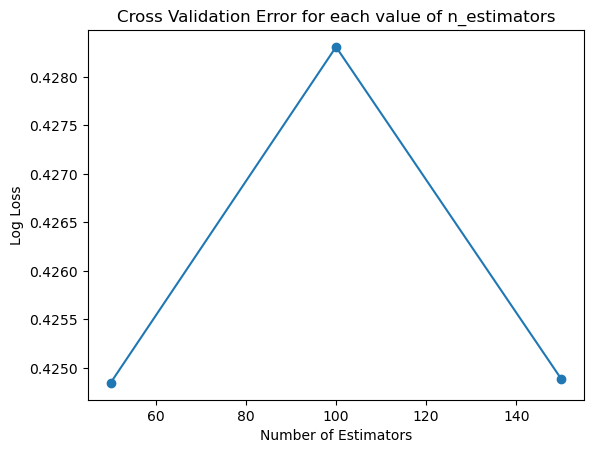

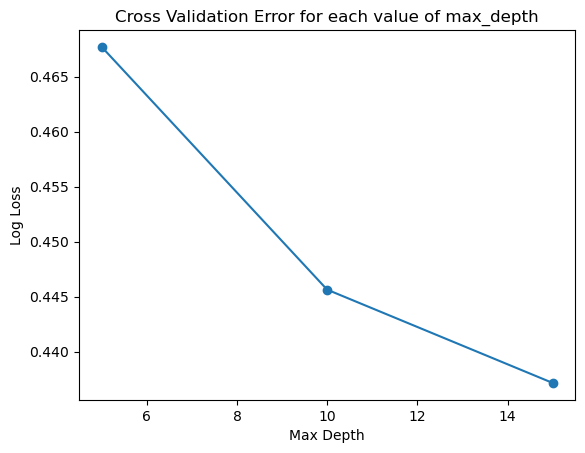

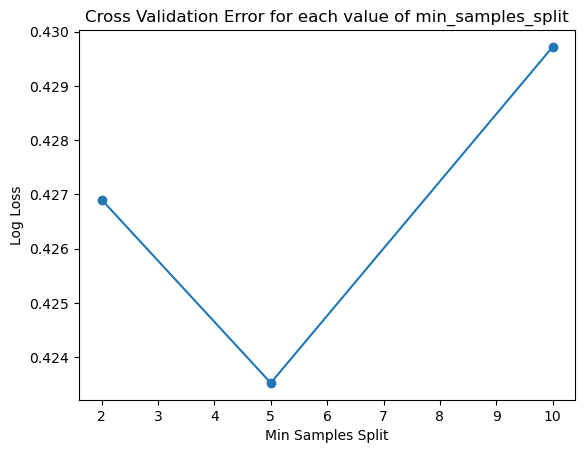

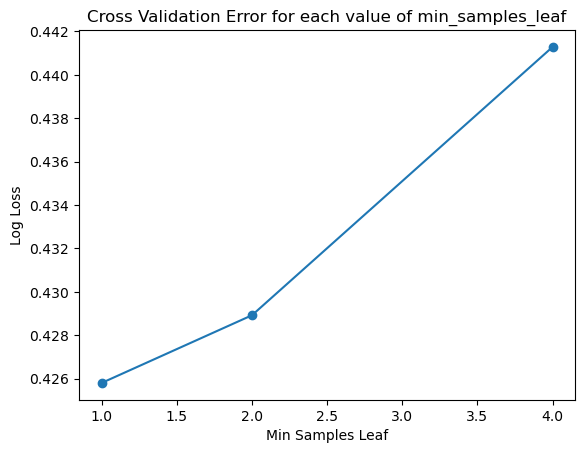

For n_estimators = 50, max_depth = 5, min_samples_split = 2, min_samples_leaf = 1, log loss is: 0.46213078090340515
For n_estimators = 50, max_depth = 5, min_samples_split = 2, min_samples_leaf = 2, log loss is: 0.46870925849369577
For n_estimators = 50, max_depth = 5, min_samples_split = 2, min_samples_leaf = 4, log loss is: 0.4768554849283832
For n_estimators = 50, max_depth = 5, min_samples_split = 5, min_samples_leaf = 1, log loss is: 0.4705042004375575
For n_estimators = 50, max_depth = 5, min_samples_split = 5, min_samples_leaf = 2, log loss is: 0.4633754390471176
For n_estimators = 50, max_depth = 5, min_samples_split = 5, min_samples_leaf = 4, log loss is: 0.47379597410192903
For n_estimators = 50, max_depth = 5, min_samples_split = 10, min_samples_leaf = 1, log loss is: 0.4749556954374037
For n_estimators = 50, max_depth = 5, min_samples_split = 10, min_samples_leaf = 2, log loss is: 0.4615289841760591
For n_estimators = 50, max_depth = 5, min_samples_split = 10, min_samples_l

For n_estimators = 150, max_depth = 10, min_samples_split = 10, min_samples_leaf = 4, log loss is: 0.45245923238882996
For n_estimators = 150, max_depth = 15, min_samples_split = 2, min_samples_leaf = 1, log loss is: 0.4364042568769721
For n_estimators = 150, max_depth = 15, min_samples_split = 2, min_samples_leaf = 2, log loss is: 0.437949739359398
For n_estimators = 150, max_depth = 15, min_samples_split = 2, min_samples_leaf = 4, log loss is: 0.4466809062829688
For n_estimators = 150, max_depth = 15, min_samples_split = 5, min_samples_leaf = 1, log loss is: 0.4353372017526707
For n_estimators = 150, max_depth = 15, min_samples_split = 5, min_samples_leaf = 2, log loss is: 0.43812998412813614
For n_estimators = 150, max_depth = 15, min_samples_split = 5, min_samples_leaf = 4, log loss is: 0.44546758606899245
For n_estimators = 150, max_depth = 15, min_samples_split = 10, min_samples_leaf = 1, log loss is: 0.4369894714932354
For n_estimators = 150, max_depth = 15, min_samples_split = 

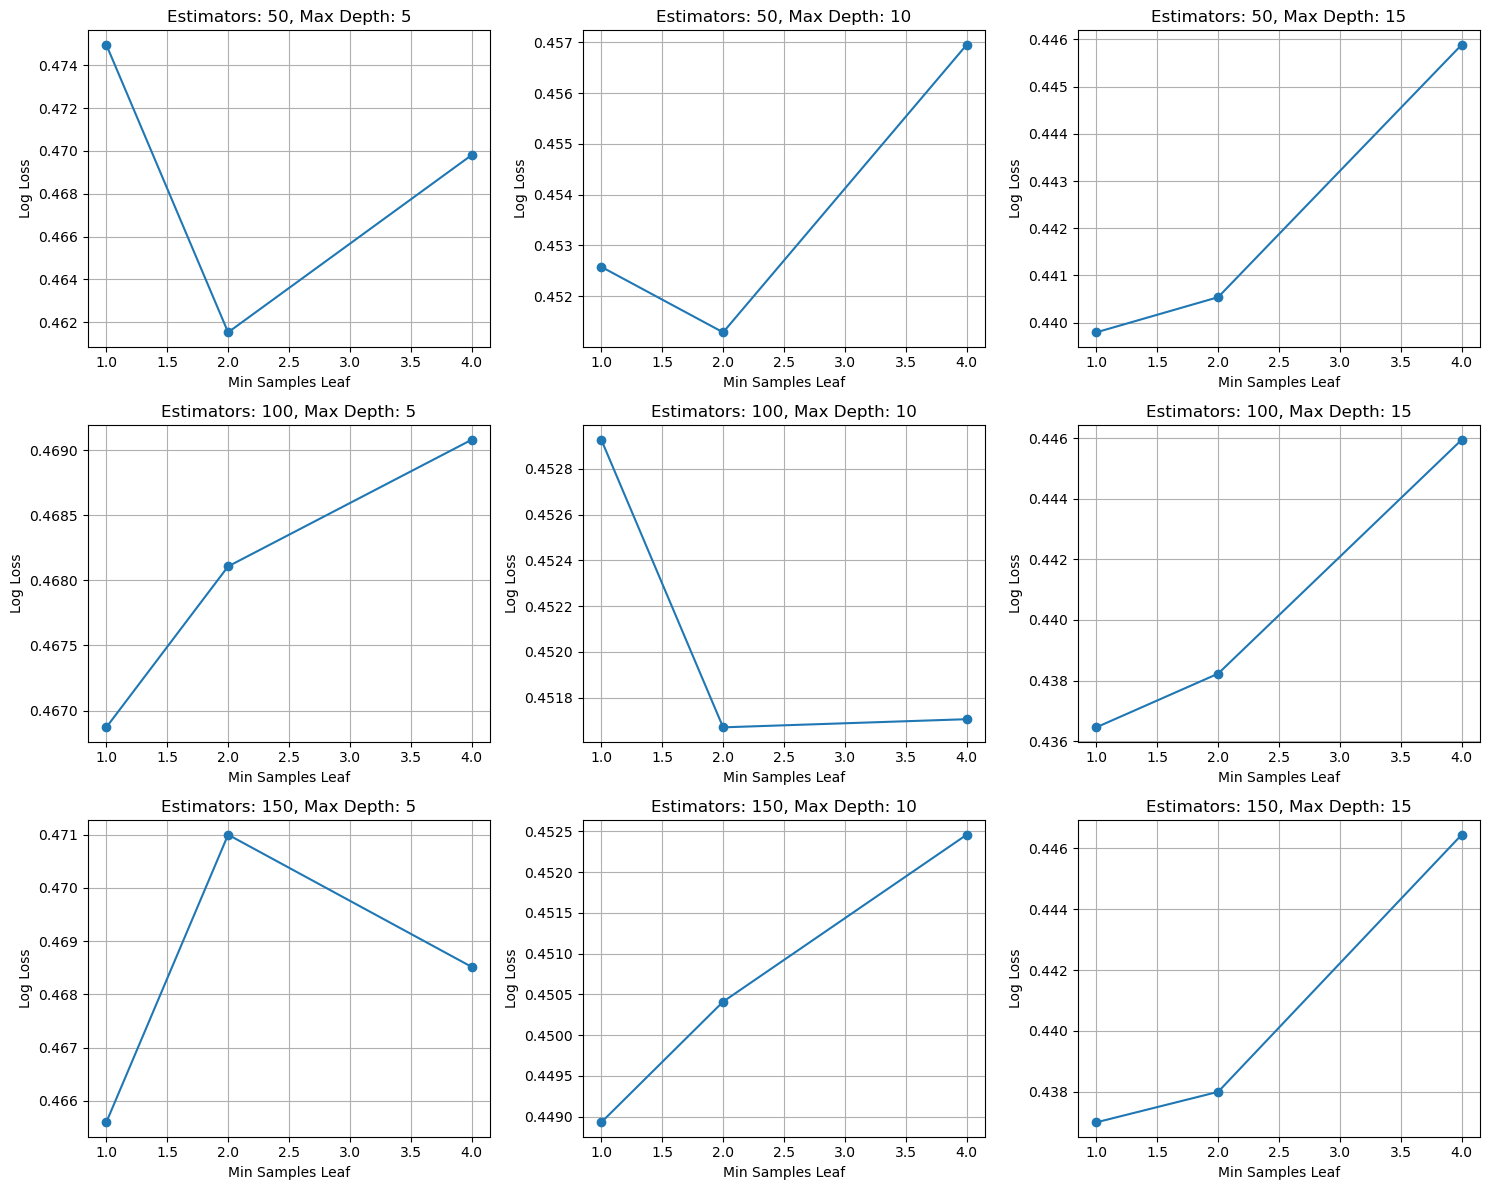

For values of best n_estimators = 150, max_depth = 15, min_samples_split = 5, min_samples_leaf = 1, log loss on training set is: 0.32465474642863007
For values of best n_estimators = 150, max_depth = 15, min_samples_split = 5, min_samples_leaf = 1, log loss on cross-validation set is: 0.4631322306036047
For values of best n_estimators = 150, max_depth = 15, min_samples_split = 5, min_samples_leaf = 1, log loss on test set is: 0.4711930850268484
Number of misclassified points: 0.243
***************Performance metric***************
Accuracy: 75.70%
-------------------- Confusion matrix --------------------


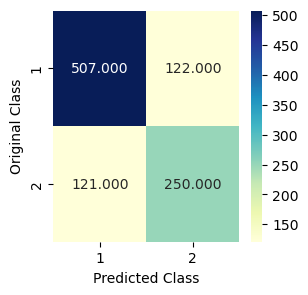

-------------------- Precision matrix (Column Sum=1) --------------------
Precision: 0.6720


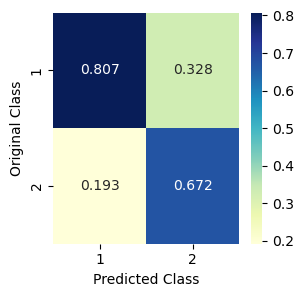

-------------------- Recall matrix (Row Sum=1) --------------------
Recall: 0.6739


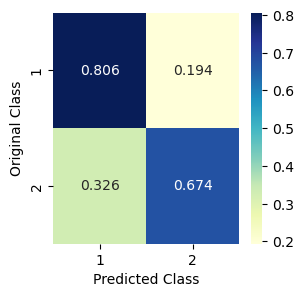

-------------------- F1 Score --------------------
F1 Score: 0.6729


In [68]:
n_estimators_values = [50, 100, 150]
max_depth_values = [5, 10, 15]
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values = [1, 2, 4]

rf_bow_accuracy, rf_bow_precision, rf_bow_recall, rf_bow_f1, rf_bow_train_log_loss, rf_bow_cv_log_loss, rf_bow_test_log_loss, rf_bow_misclassified_points = random_forest_model(X_train_bow.values, y_train, X_cv_bow.values, y_cv, X_test_bow.values, y_test, n_estimators_values, max_depth_values, min_samples_split_values, min_samples_leaf_values)

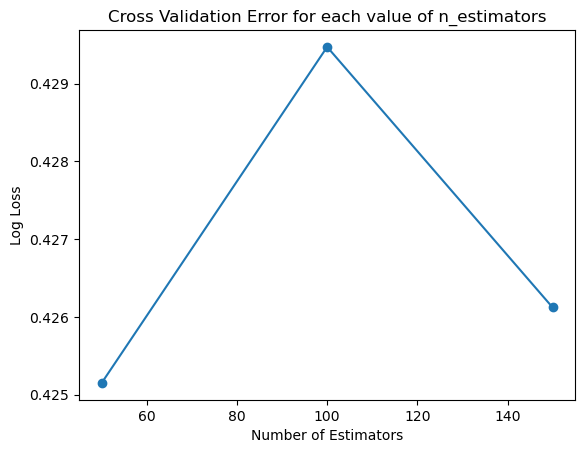

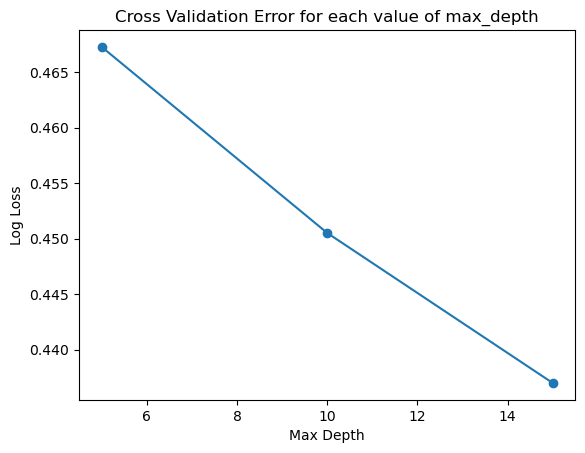

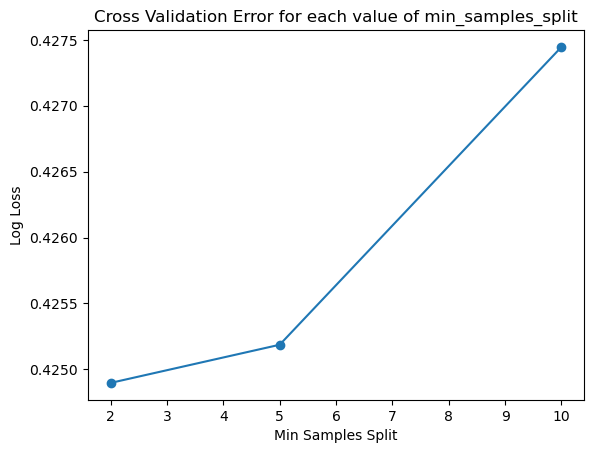

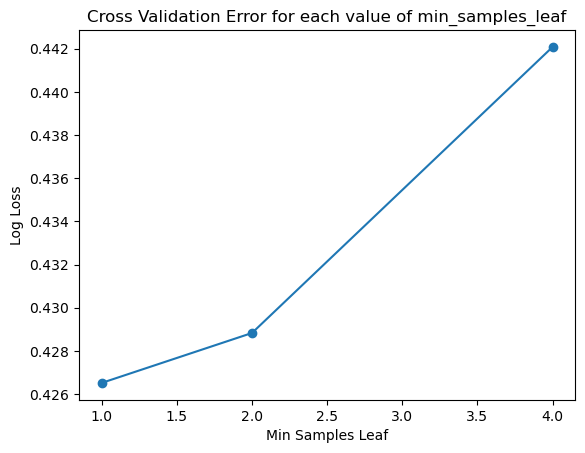

For n_estimators = 50, max_depth = 5, min_samples_split = 2, min_samples_leaf = 1, log loss is: 0.4686406857554408
For n_estimators = 50, max_depth = 5, min_samples_split = 2, min_samples_leaf = 2, log loss is: 0.4694900359728764
For n_estimators = 50, max_depth = 5, min_samples_split = 2, min_samples_leaf = 4, log loss is: 0.473633868075684
For n_estimators = 50, max_depth = 5, min_samples_split = 5, min_samples_leaf = 1, log loss is: 0.4739344904866569
For n_estimators = 50, max_depth = 5, min_samples_split = 5, min_samples_leaf = 2, log loss is: 0.46845921004193286
For n_estimators = 50, max_depth = 5, min_samples_split = 5, min_samples_leaf = 4, log loss is: 0.4682949395512962
For n_estimators = 50, max_depth = 5, min_samples_split = 10, min_samples_leaf = 1, log loss is: 0.47100980162945094
For n_estimators = 50, max_depth = 5, min_samples_split = 10, min_samples_leaf = 2, log loss is: 0.46459408808651825
For n_estimators = 50, max_depth = 5, min_samples_split = 10, min_samples_le

For n_estimators = 150, max_depth = 10, min_samples_split = 10, min_samples_leaf = 4, log loss is: 0.4519192772124507
For n_estimators = 150, max_depth = 15, min_samples_split = 2, min_samples_leaf = 1, log loss is: 0.4378916223567904
For n_estimators = 150, max_depth = 15, min_samples_split = 2, min_samples_leaf = 2, log loss is: 0.4376570728552893
For n_estimators = 150, max_depth = 15, min_samples_split = 2, min_samples_leaf = 4, log loss is: 0.44529118383491556
For n_estimators = 150, max_depth = 15, min_samples_split = 5, min_samples_leaf = 1, log loss is: 0.43624671750089855
For n_estimators = 150, max_depth = 15, min_samples_split = 5, min_samples_leaf = 2, log loss is: 0.4362538655126652
For n_estimators = 150, max_depth = 15, min_samples_split = 5, min_samples_leaf = 4, log loss is: 0.44575533381854726
For n_estimators = 150, max_depth = 15, min_samples_split = 10, min_samples_leaf = 1, log loss is: 0.4361883103463153
For n_estimators = 150, max_depth = 15, min_samples_split =

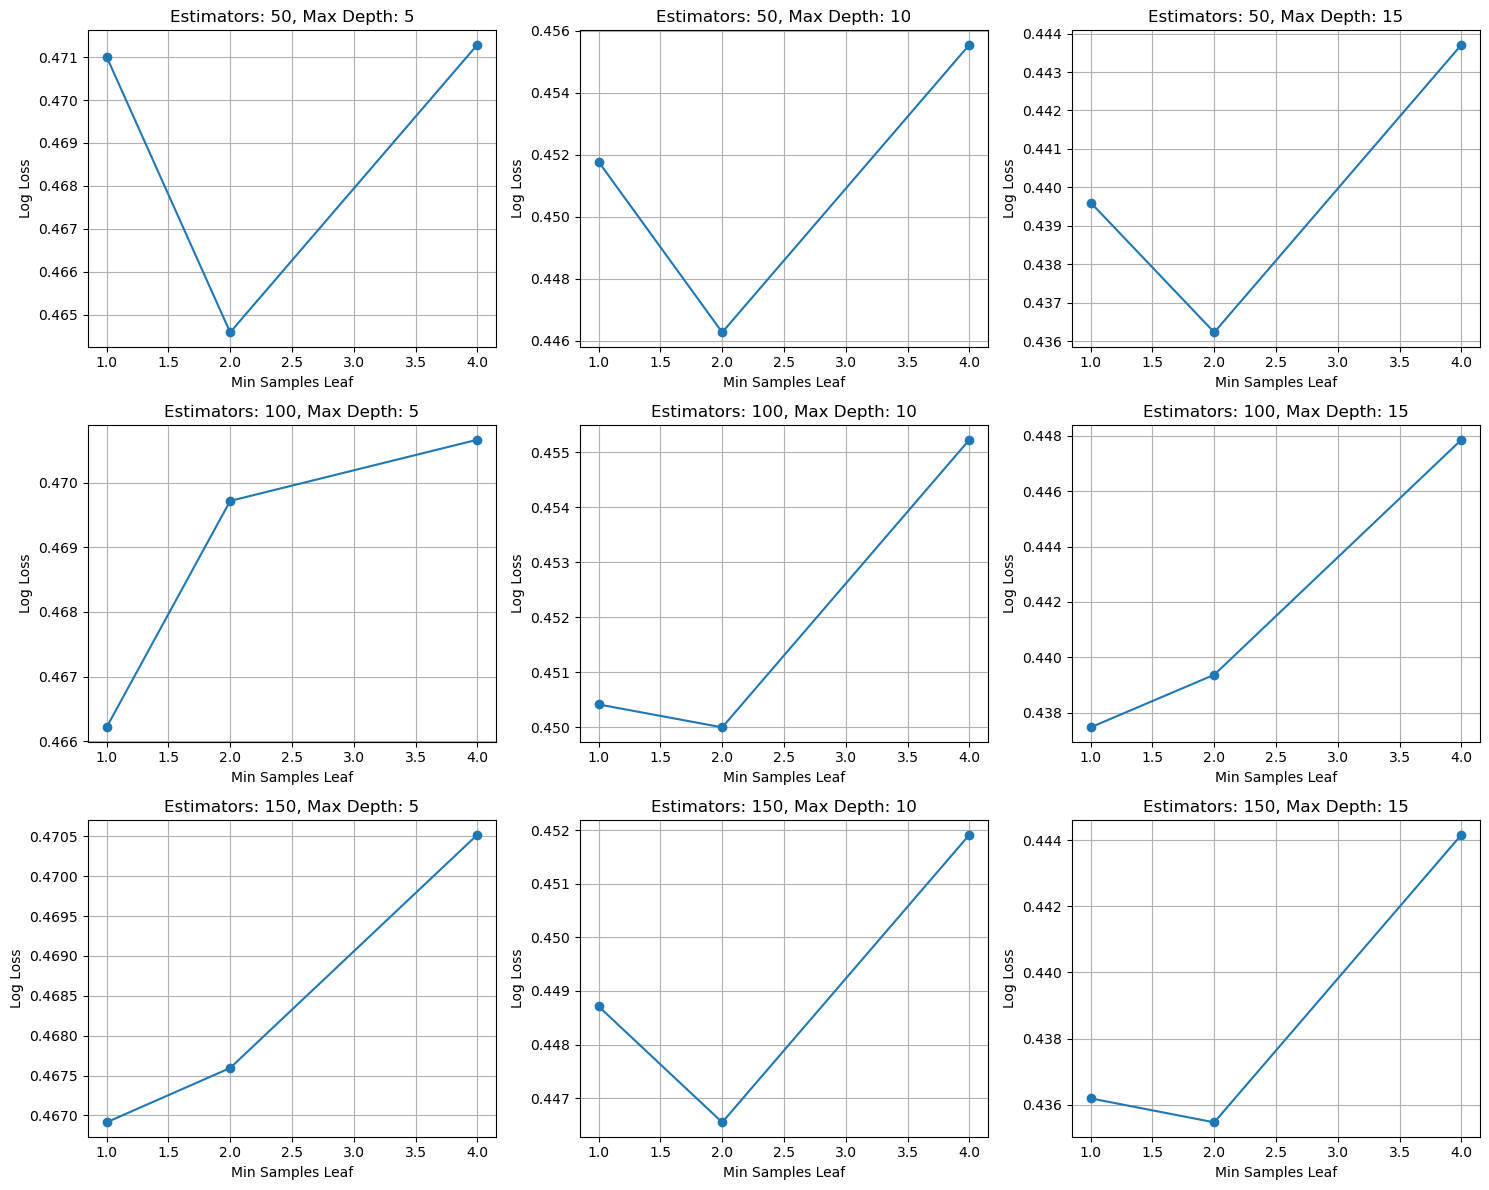

For values of best n_estimators = 50, max_depth = 15, min_samples_split = 2, min_samples_leaf = 1, log loss on training set is: 0.31793862081390206
For values of best n_estimators = 50, max_depth = 15, min_samples_split = 2, min_samples_leaf = 1, log loss on cross-validation set is: 0.46475068195477975
For values of best n_estimators = 50, max_depth = 15, min_samples_split = 2, min_samples_leaf = 1, log loss on test set is: 0.47337918621153674
Number of misclassified points: 0.24
***************Performance metric***************
Accuracy: 76.00%
-------------------- Confusion matrix --------------------


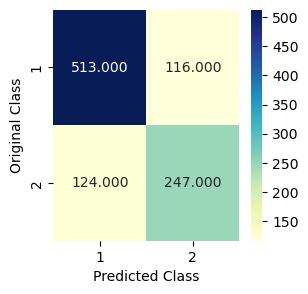

-------------------- Precision matrix (Column Sum=1) --------------------
Precision: 0.6804


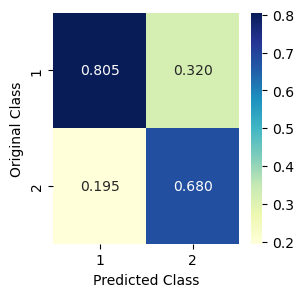

-------------------- Recall matrix (Row Sum=1) --------------------
Recall: 0.6658


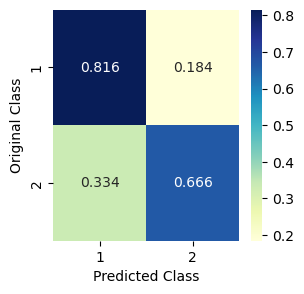

-------------------- F1 Score --------------------
F1 Score: 0.6730


In [69]:
n_estimators_values = [50, 100, 150]
max_depth_values = [5, 10, 15]
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values = [1, 2, 4]

rf_tfidf_accuracy, rf_tfidf_precision, rf_tfidf_recall, rf_tfidf_f1, rf_tfidf_train_log_loss, rf_tfidf_cv_log_loss, rf_tfidf_test_log_loss, rf_tfidf_misclassified_points = random_forest_model(X_train_tfidf.values, y_train, X_cv_tfidf.values, y_cv, X_test_tfidf.values, y_test, n_estimators_values, max_depth_values, min_samples_split_values, min_samples_leaf_values)

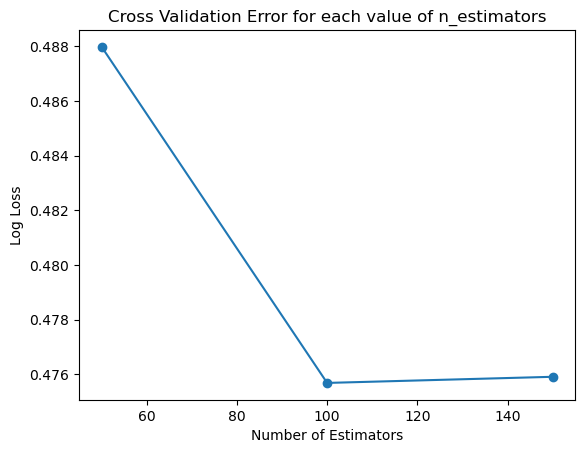

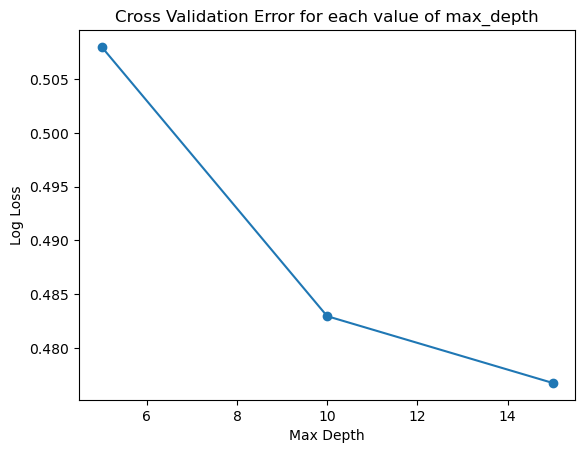

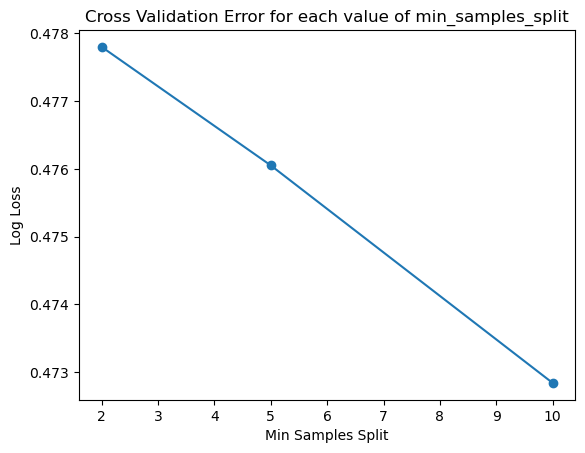

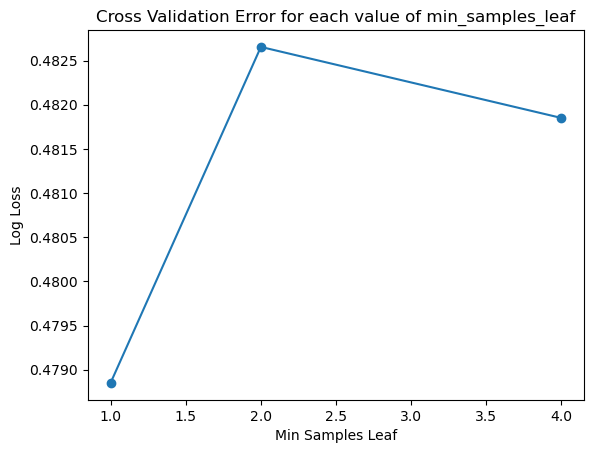

For n_estimators = 50, max_depth = 5, min_samples_split = 2, min_samples_leaf = 1, log loss is: 0.5057423918613766
For n_estimators = 50, max_depth = 5, min_samples_split = 2, min_samples_leaf = 2, log loss is: 0.5085774538060558
For n_estimators = 50, max_depth = 5, min_samples_split = 2, min_samples_leaf = 4, log loss is: 0.5156001376027968
For n_estimators = 50, max_depth = 5, min_samples_split = 5, min_samples_leaf = 1, log loss is: 0.5129270968761506
For n_estimators = 50, max_depth = 5, min_samples_split = 5, min_samples_leaf = 2, log loss is: 0.5097889453306683
For n_estimators = 50, max_depth = 5, min_samples_split = 5, min_samples_leaf = 4, log loss is: 0.5077207671920345
For n_estimators = 50, max_depth = 5, min_samples_split = 10, min_samples_leaf = 1, log loss is: 0.511595388521073
For n_estimators = 50, max_depth = 5, min_samples_split = 10, min_samples_leaf = 2, log loss is: 0.5076141145293122
For n_estimators = 50, max_depth = 5, min_samples_split = 10, min_samples_leaf 

For n_estimators = 150, max_depth = 10, min_samples_split = 10, min_samples_leaf = 4, log loss is: 0.4848375419278545
For n_estimators = 150, max_depth = 15, min_samples_split = 2, min_samples_leaf = 1, log loss is: 0.4754559583270555
For n_estimators = 150, max_depth = 15, min_samples_split = 2, min_samples_leaf = 2, log loss is: 0.479444716648656
For n_estimators = 150, max_depth = 15, min_samples_split = 2, min_samples_leaf = 4, log loss is: 0.47650315261210596
For n_estimators = 150, max_depth = 15, min_samples_split = 5, min_samples_leaf = 1, log loss is: 0.4776691757656031
For n_estimators = 150, max_depth = 15, min_samples_split = 5, min_samples_leaf = 2, log loss is: 0.4784671537641121
For n_estimators = 150, max_depth = 15, min_samples_split = 5, min_samples_leaf = 4, log loss is: 0.4762838085396737
For n_estimators = 150, max_depth = 15, min_samples_split = 10, min_samples_leaf = 1, log loss is: 0.481213285782995
For n_estimators = 150, max_depth = 15, min_samples_split = 10,

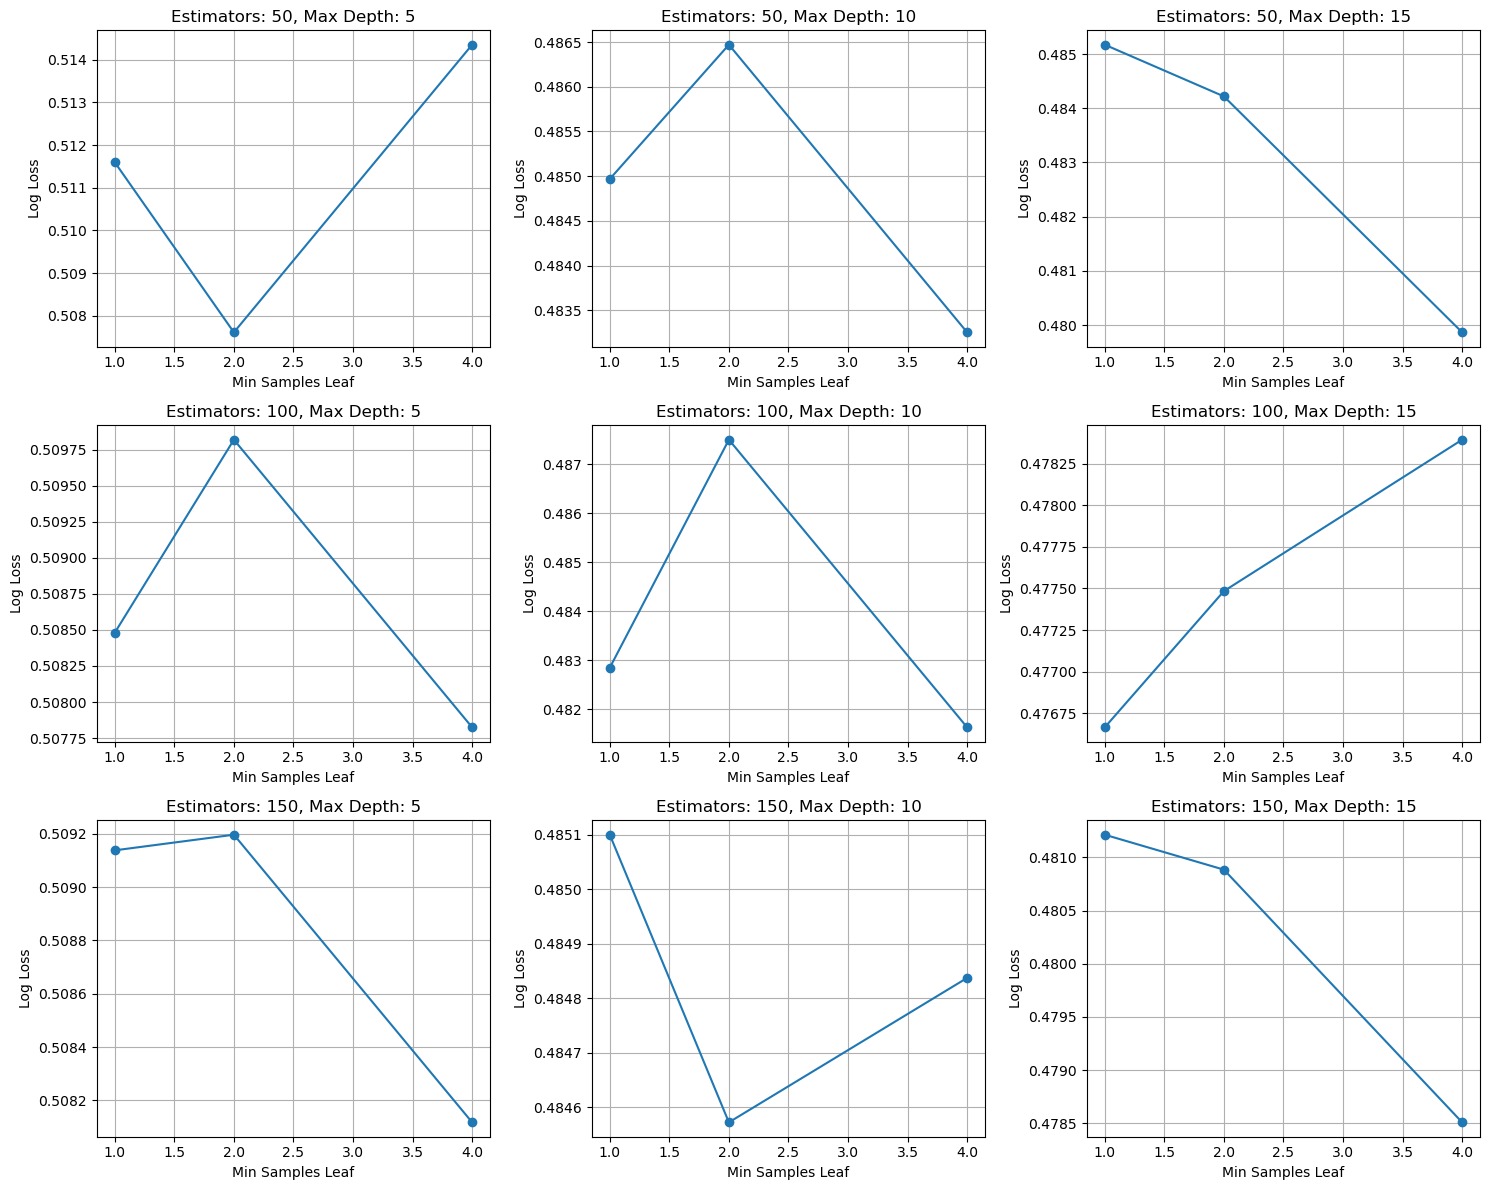

For values of best n_estimators = 100, max_depth = 15, min_samples_split = 2, min_samples_leaf = 2, log loss on training set is: 0.16719927975091717
For values of best n_estimators = 100, max_depth = 15, min_samples_split = 2, min_samples_leaf = 2, log loss on cross-validation set is: 0.48615701986074455
For values of best n_estimators = 100, max_depth = 15, min_samples_split = 2, min_samples_leaf = 2, log loss on test set is: 0.48726929318872053
Number of misclassified points: 0.264
***************Performance metric***************
Accuracy: 73.60%
-------------------- Confusion matrix --------------------


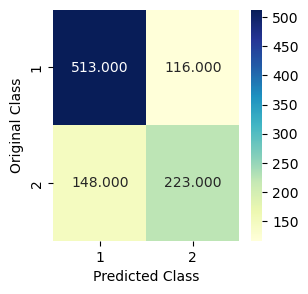

-------------------- Precision matrix (Column Sum=1) --------------------
Precision: 0.6578


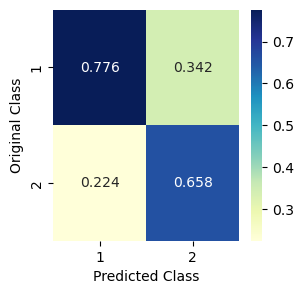

-------------------- Recall matrix (Row Sum=1) --------------------
Recall: 0.6011


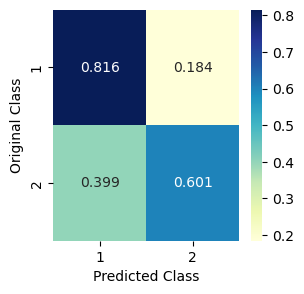

-------------------- F1 Score --------------------
F1 Score: 0.6282


In [70]:
n_estimators_values = [50, 100, 150]
max_depth_values = [5, 10, 15]
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values = [1, 2, 4]

rf_w2v_accuracy, rf_w2v_precision, rf_w2v_recall, rf_w2v_f1, rf_w2v_train_log_loss, rf_w2v_cv_log_loss, rf_w2v_test_log_loss, rf_w2v_misclassified_points = random_forest_model(X_train_w2v.values, y_train, X_cv_w2v.values, y_cv, X_test_w2v.values, y_test, n_estimators_values, max_depth_values, min_samples_split_values, min_samples_leaf_values)

<h3>4.3.8 Adaboost Algorithm</h3>

In [71]:
def adaboost_model(X_train, y_train, X_cv, y_cv, X_test, y_test, n_estimators_values, learning_rate_values):
    # Initialize arrays to store log loss for each combination of hyperparameters
    cv_log_error_estimators = np.zeros(len(n_estimators_values))
    cv_log_error_learning_rate = np.zeros(len(learning_rate_values))
    cv_log_error_array = np.zeros((len(n_estimators_values), len(learning_rate_values)))

    # Step 2: Loop through each value of n_estimators
    for i, n_estimators in enumerate(n_estimators_values):
        # Initialize AdaBoost classifier with the current n_estimators value
        adaboost = AdaBoostClassifier(n_estimators=n_estimators, random_state=42)
        # Fit the AdaBoost model on the training data
        adaboost.fit(X_train, y_train)
        # Calibrate the model using sigmoid calibration
        sig_clf_adaboost = CalibratedClassifierCV(adaboost, method="sigmoid")
        sig_clf_adaboost.fit(X_train, y_train)
        # Predict probabilities on the cross-validation set
        sig_clf_probs_cv = sig_clf_adaboost.predict_proba(X_cv)
        # Calculate log loss and store in the array
        cv_log_error_estimators[i] = log_loss(y_cv, sig_clf_probs_cv, labels=adaboost.classes_)

    # Plot the cross-validation error for each value of n_estimators
    plt.plot(n_estimators_values, cv_log_error_estimators, marker='o')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Log Loss')
    plt.title("Cross Validation Error for each value of n_estimators")
    plt.show()

    # Step 3: Loop through each value of learning_rate
    for i, learning_rate in enumerate(learning_rate_values):
        # Initialize AdaBoost classifier with the current learning_rate value
        adaboost = AdaBoostClassifier(learning_rate=learning_rate, random_state=42)
        adaboost.fit(X_train, y_train)
        sig_clf_adaboost = CalibratedClassifierCV(adaboost, method="sigmoid")
        sig_clf_adaboost.fit(X_train, y_train)
        sig_clf_probs_cv = sig_clf_adaboost.predict_proba(X_cv)
        cv_log_error_learning_rate[i] = log_loss(y_cv, sig_clf_probs_cv, labels=adaboost.classes_)

    # Plot the cross-validation error for each value of learning_rate
    plt.plot(learning_rate_values, cv_log_error_learning_rate, marker='o')
    plt.xlabel('Learning Rate')
    plt.ylabel('Log Loss')
    plt.title("Cross Validation Error for each value of learning_rate")
    plt.show()

    # Step 4: Loop through each combination of hyperparameter values
    for i, n_estimators in enumerate(n_estimators_values):
        for j, learning_rate in enumerate(learning_rate_values):
            adaboost = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
            adaboost.fit(X_train, y_train)
            sig_clf_adaboost = CalibratedClassifierCV(adaboost, method="sigmoid")
            sig_clf_adaboost.fit(X_train, y_train)
            sig_clf_probs_cv = sig_clf_adaboost.predict_proba(X_cv)
            cv_log_error_array[i, j] = log_loss(y_cv, sig_clf_probs_cv, labels=adaboost.classes_)
            print('For n_estimators = {}, learning_rate = {}, log loss is: {}'.format(n_estimators, learning_rate, cv_log_error_array[i, j]))

    # Plot the cross-validation error for the best combination of hyperparameters
    fig, axs = plt.subplots(len(n_estimators_values), len(learning_rate_values), figsize=(15, 12))
    for idx, n_estimators in enumerate(n_estimators_values):
        for i, learning_rate in enumerate(learning_rate_values):
            axs[idx, i].plot(learning_rate_values, cv_log_error_array, marker='o')
            axs[idx, i].set_title(f'Estimators: {n_estimators}, Learning Rate: {learning_rate}')
            axs[idx, i].set_xlabel('Learning Rate')
            axs[idx, i].set_ylabel('Log Loss')
            axs[idx, i].grid()

    plt.tight_layout()
    plt.show()

    # Identify the best hyperparameter values based on minimum log loss
    best_indices = np.unravel_index(np.argmin(cv_log_error_array), cv_log_error_array.shape)
    best_n_estimators = n_estimators_values[best_indices[0]]
    best_learning_rate = learning_rate_values[best_indices[1]]

    # Train the best model using the identified hyperparameter values
    best_adaboost = AdaBoostClassifier(n_estimators=best_n_estimators, learning_rate=best_learning_rate, random_state=42)
    best_adaboost.fit(X_train, y_train)
    best_sig_clf_adaboost = CalibratedClassifierCV(best_adaboost, method="sigmoid")
    best_sig_clf_adaboost.fit(X_train, y_train)

    # Predict probabilities on the training set for the best model
    predict_y_train = best_sig_clf_adaboost.predict_proba(X_train)
    adaboost_train_log_loss = log_loss(y_train, predict_y_train, labels=best_adaboost.classes_)
    # Print log loss on the training set for the best model
    print('For values of best n_estimators = {}, learning_rate = {}, log loss on training set is: {}'.format(best_n_estimators, best_learning_rate, adaboost_train_log_loss))

    # Predict probabilities on the cross-validation set for the best model
    predict_y_cv = best_adaboost.predict_proba(X_cv)
    adaboost_cv_log_loss = log_loss(y_cv, predict_y_cv, labels=best_adaboost.classes_)
    # Print log loss on the cross-validation set for the best model
    print('For values of best n_estimators = {}, learning_rate = {}, log loss on cross-validation set is: {}'.format(best_n_estimators, best_learning_rate, adaboost_cv_log_loss))

    # Predict probabilities on the test set for the best model
    predict_y_test = best_adaboost.predict_proba(X_test)
    adaboost_test_log_loss = log_loss(y_test, predict_y_test, labels=best_adaboost.classes_)
    # Print log loss on the test set for the best model
    print('For values of best n_estimators = {}, learning_rate = {}, log loss on test set is: {}'.format(best_n_estimators, best_learning_rate, adaboost_test_log_loss))

    # Predict on the test set and evaluate model performance
    predict_y = best_sig_clf_adaboost.predict(X_test)
    adaboost_misclassified_points = np.count_nonzero((best_sig_clf_adaboost.predict(X_test) - y_test)) / y_test.shape[0]
    print("Number of misclassified points:", adaboost_misclassified_points)
    # Print additional model peadaboostormance metrics
    adaboost_accuracy, adaboost_precision, adaboost_recall, adaboost_f1 = model_performance_metrics(y_test, predict_y)
    
    return adaboost_accuracy, adaboost_precision, adaboost_recall, adaboost_f1, adaboost_train_log_loss, adaboost_cv_log_loss, adaboost_test_log_loss, adaboost_misclassified_points

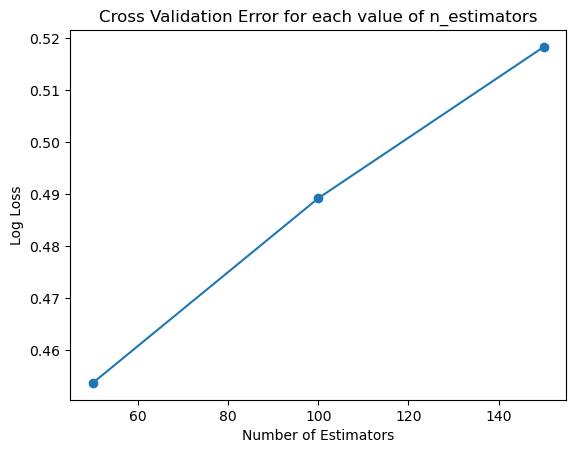

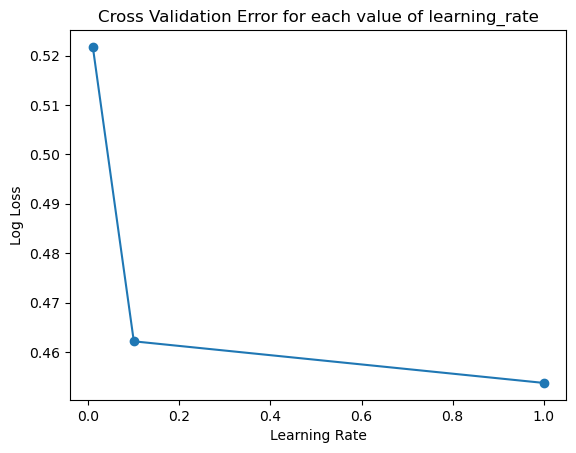

For n_estimators = 50, learning_rate = 0.01, log loss is: 0.521751027120122
For n_estimators = 50, learning_rate = 0.1, log loss is: 0.4621465561362294
For n_estimators = 50, learning_rate = 1.0, log loss is: 0.4537244890821823
For n_estimators = 100, learning_rate = 0.01, log loss is: 0.5131882392982267
For n_estimators = 100, learning_rate = 0.1, log loss is: 0.4442790256140907
For n_estimators = 100, learning_rate = 1.0, log loss is: 0.4892296570199754
For n_estimators = 150, learning_rate = 0.01, log loss is: 0.4988156223214586
For n_estimators = 150, learning_rate = 0.1, log loss is: 0.43910390195366816
For n_estimators = 150, learning_rate = 1.0, log loss is: 0.5183194571856784


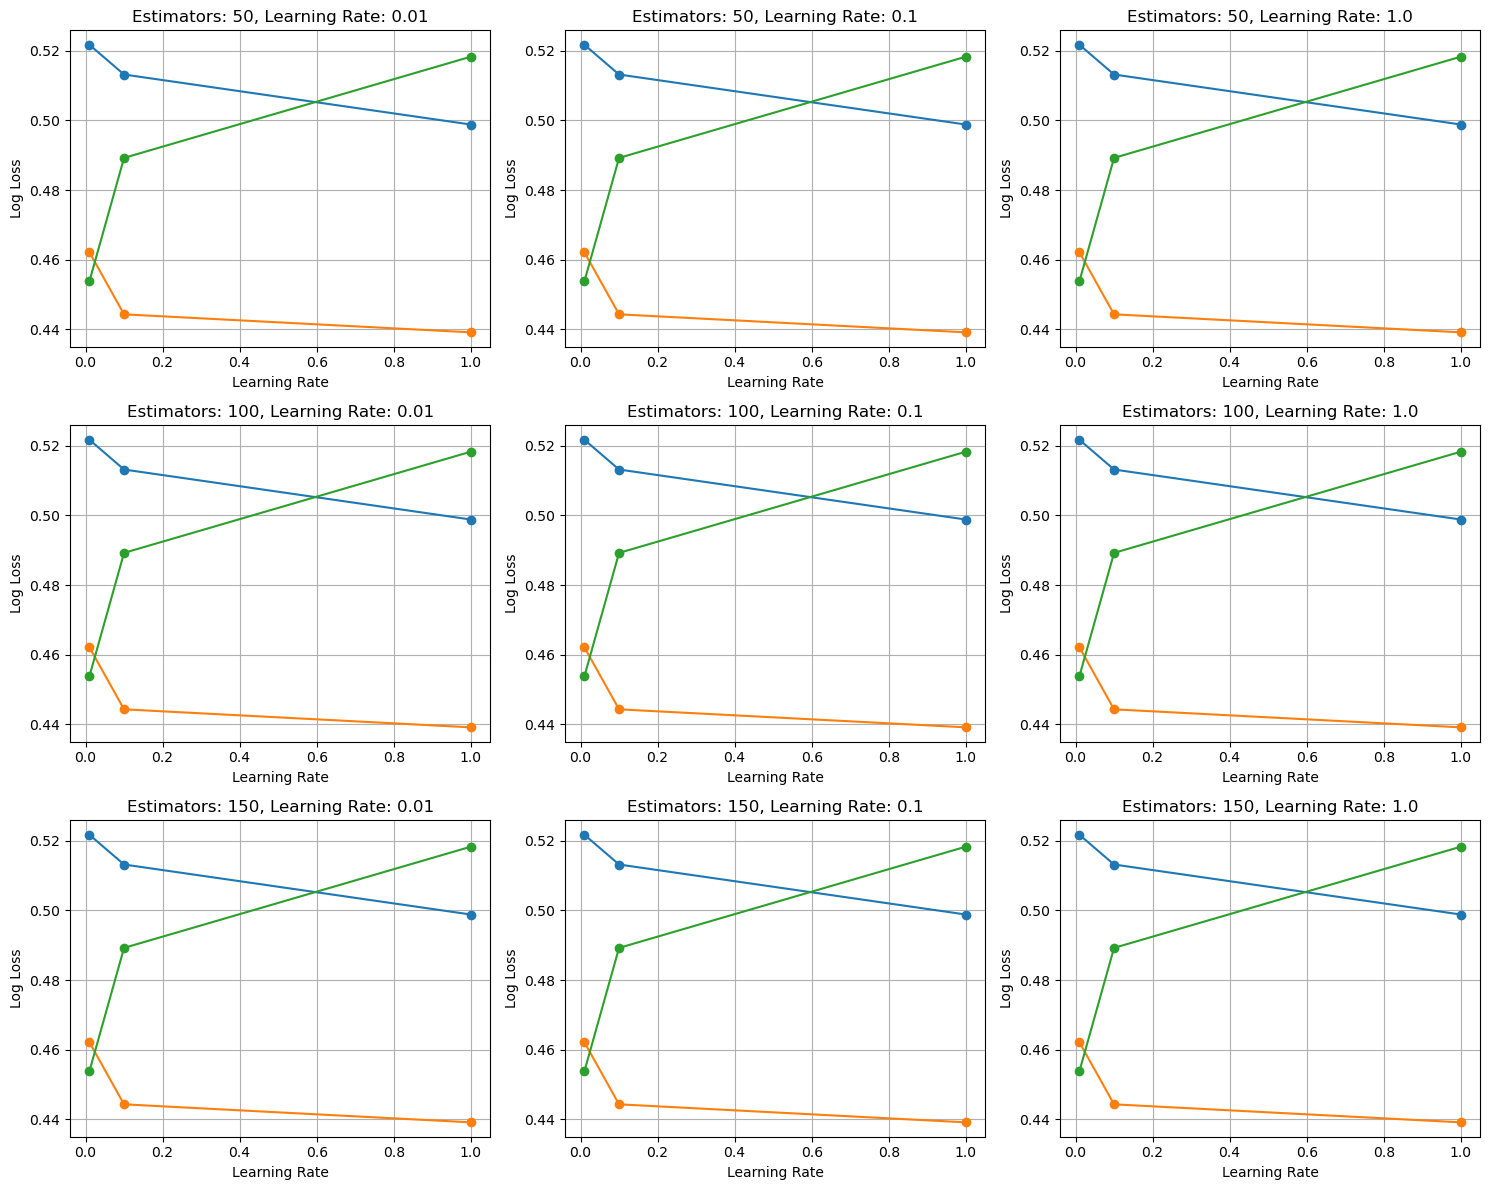

For values of best n_estimators = 150, learning_rate = 0.1, log loss on training set is: 0.4041892027283571
For values of best n_estimators = 150, learning_rate = 0.1, log loss on cross-validation set is: 0.6315897488114482
For values of best n_estimators = 150, learning_rate = 0.1, log loss on test set is: 0.6312300310840299
Number of misclassified points: 0.243
***************Performance metric***************
Accuracy: 75.70%
-------------------- Confusion matrix --------------------


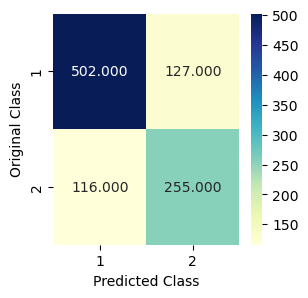

-------------------- Precision matrix (Column Sum=1) --------------------
Precision: 0.6675


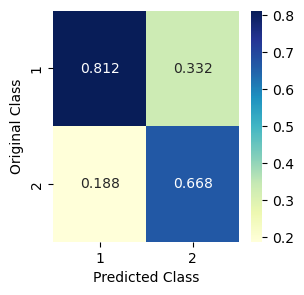

-------------------- Recall matrix (Row Sum=1) --------------------
Recall: 0.6873


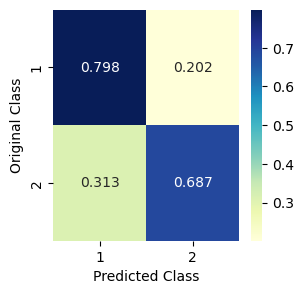

-------------------- F1 Score --------------------
F1 Score: 0.6773


In [72]:
n_estimators_values = [50, 100, 150]
learning_rate_values = [0.01, 0.1, 1.0]

adaboost_bow_accuracy, adaboost_bow_precision, adaboost_bow_recall, adaboost_bow_f1, adaboost_bow_train_log_loss, adaboost_bow_cv_log_loss, adaboost_bow_test_log_loss, adaboost_bow_misclassified_points = adaboost_model(X_train_bow.values, y_train, X_cv_bow.values, y_cv, X_test_bow.values, y_test, n_estimators_values, learning_rate_values)

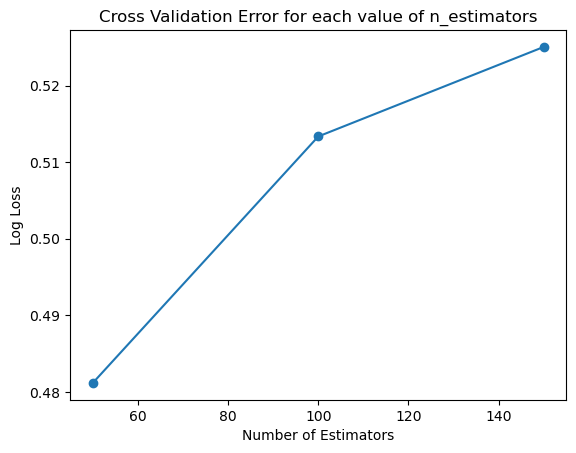

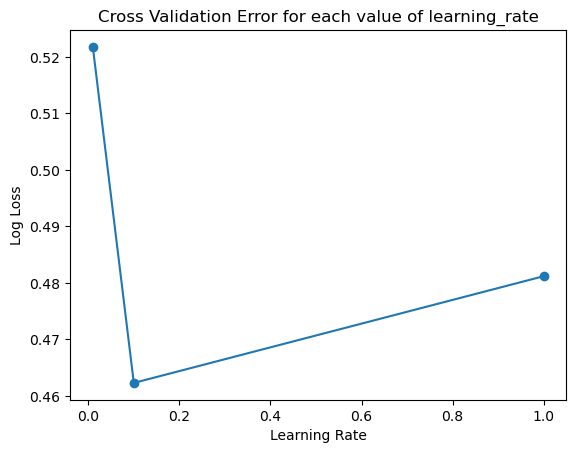

For n_estimators = 50, learning_rate = 0.01, log loss is: 0.521751027120122
For n_estimators = 50, learning_rate = 0.1, log loss is: 0.4622775248619779
For n_estimators = 50, learning_rate = 1.0, log loss is: 0.4811706509438446
For n_estimators = 100, learning_rate = 0.01, log loss is: 0.5131882392982267
For n_estimators = 100, learning_rate = 0.1, log loss is: 0.44458512137693135
For n_estimators = 100, learning_rate = 1.0, log loss is: 0.5133502779861063
For n_estimators = 150, learning_rate = 0.01, log loss is: 0.49881562232145854
For n_estimators = 150, learning_rate = 0.1, log loss is: 0.44162910122311144
For n_estimators = 150, learning_rate = 1.0, log loss is: 0.5250404322789335


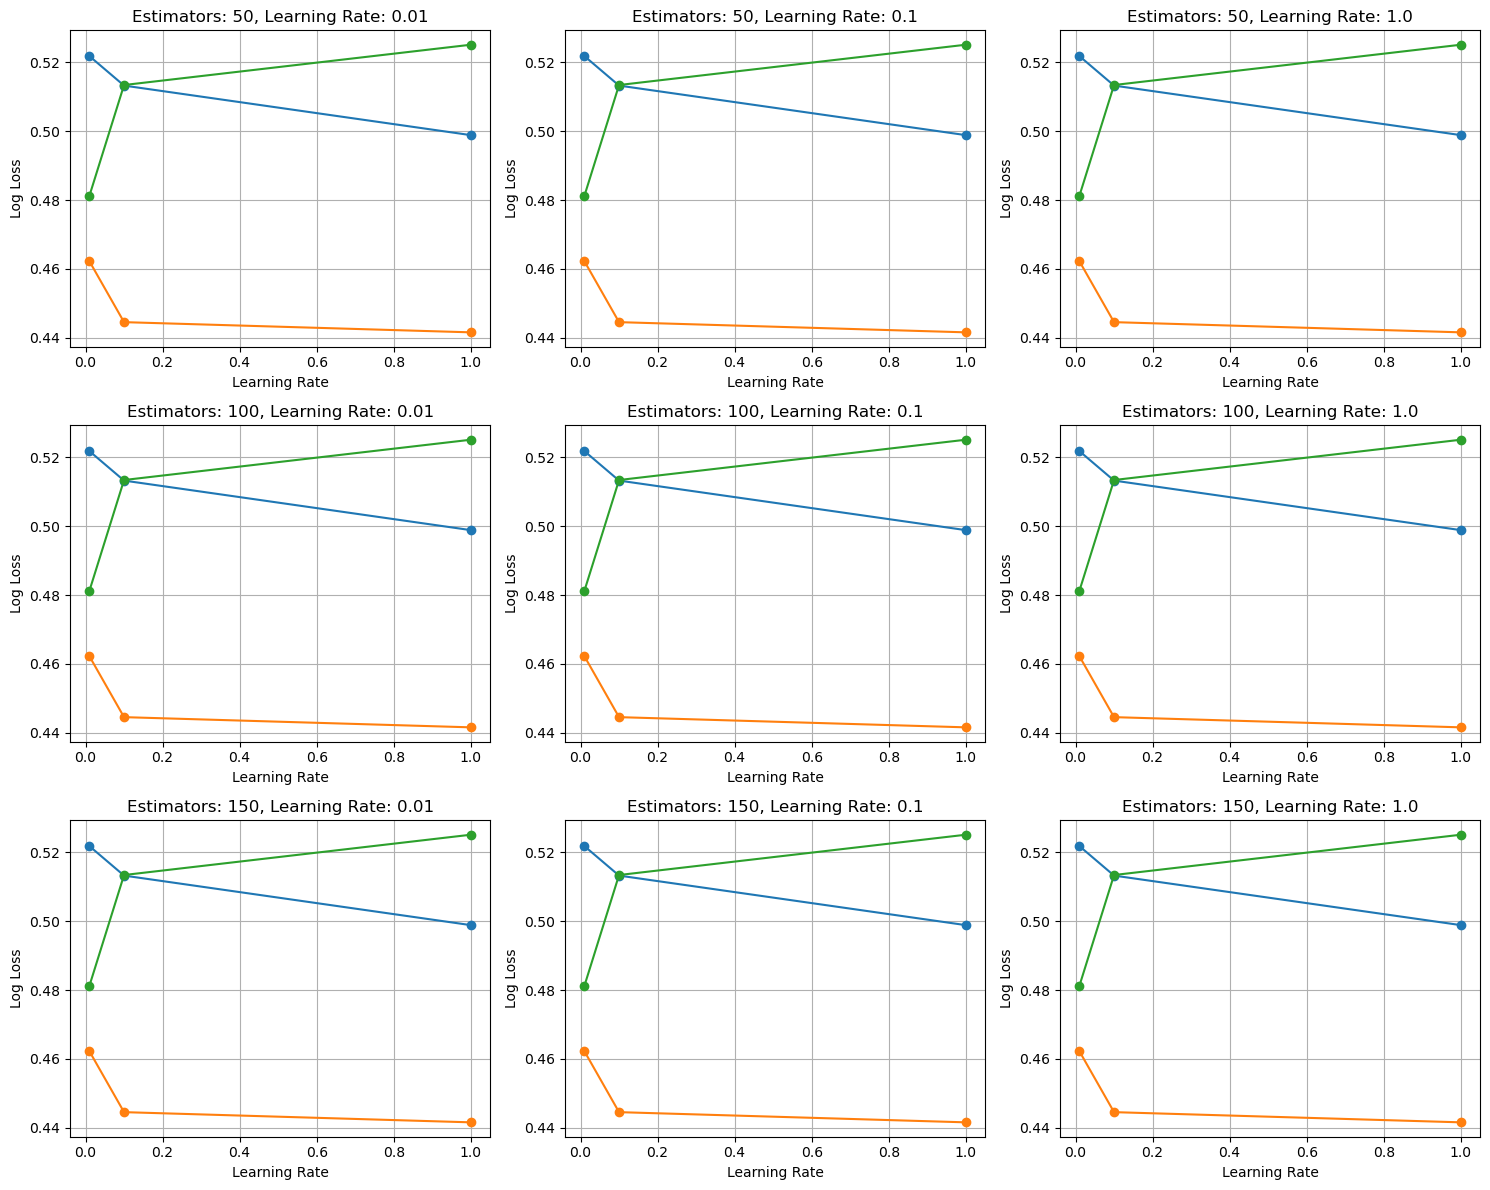

For values of best n_estimators = 150, learning_rate = 0.1, log loss on training set is: 0.40038629331983405
For values of best n_estimators = 150, learning_rate = 0.1, log loss on cross-validation set is: 0.6311156743621354
For values of best n_estimators = 150, learning_rate = 0.1, log loss on test set is: 0.6313608332359701
Number of misclassified points: 0.242
***************Performance metric***************
Accuracy: 75.80%
-------------------- Confusion matrix --------------------


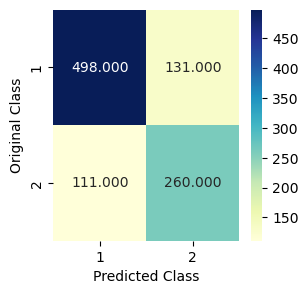

-------------------- Precision matrix (Column Sum=1) --------------------
Precision: 0.6650


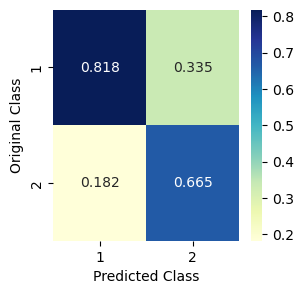

-------------------- Recall matrix (Row Sum=1) --------------------
Recall: 0.7008


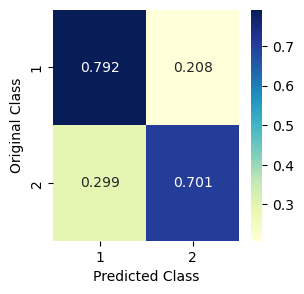

-------------------- F1 Score --------------------
F1 Score: 0.6824


In [73]:
n_estimators_values = [50, 100, 150]
learning_rate_values = [0.01, 0.1, 1.0]

adaboost_tfidf_accuracy, adaboost_tfidf_precision, adaboost_tfidf_recall, adaboost_tfidf_f1, adaboost_tfidf_train_log_loss, adaboost_tfidf_cv_log_loss, adaboost_tfidf_test_log_loss, adaboost_tfidf_misclassified_points = adaboost_model(X_train_tfidf.values, y_train, X_cv_tfidf.values, y_cv, X_test_tfidf.values, y_test, n_estimators_values, learning_rate_values)

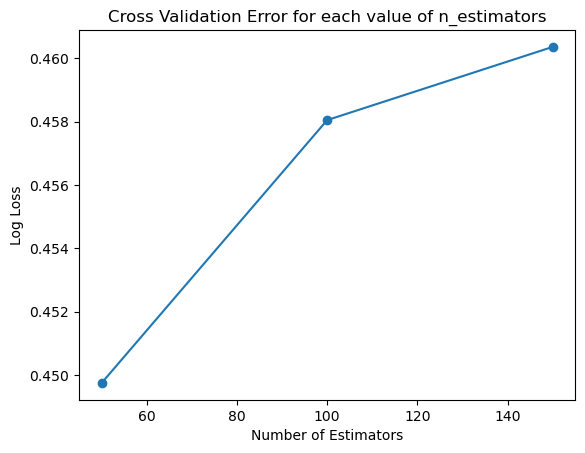

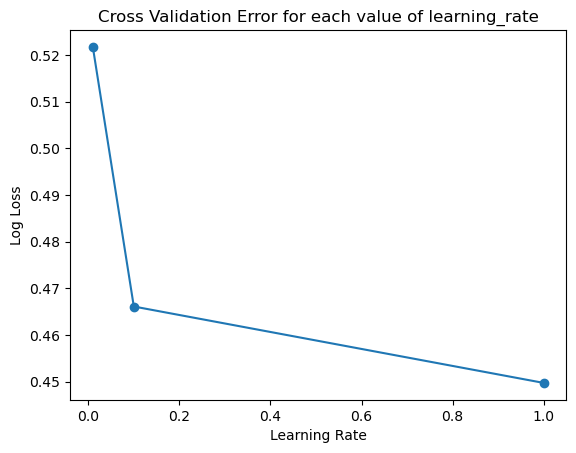

For n_estimators = 50, learning_rate = 0.01, log loss is: 0.5217510271201221
For n_estimators = 50, learning_rate = 0.1, log loss is: 0.4661206514695793
For n_estimators = 50, learning_rate = 1.0, log loss is: 0.4497441023452852
For n_estimators = 100, learning_rate = 0.01, log loss is: 0.5131882392982267
For n_estimators = 100, learning_rate = 0.1, log loss is: 0.4557316572058776
For n_estimators = 100, learning_rate = 1.0, log loss is: 0.4580483026371098
For n_estimators = 150, learning_rate = 0.01, log loss is: 0.4988156223214586
For n_estimators = 150, learning_rate = 0.1, log loss is: 0.45203919981846186
For n_estimators = 150, learning_rate = 1.0, log loss is: 0.46036039968050857


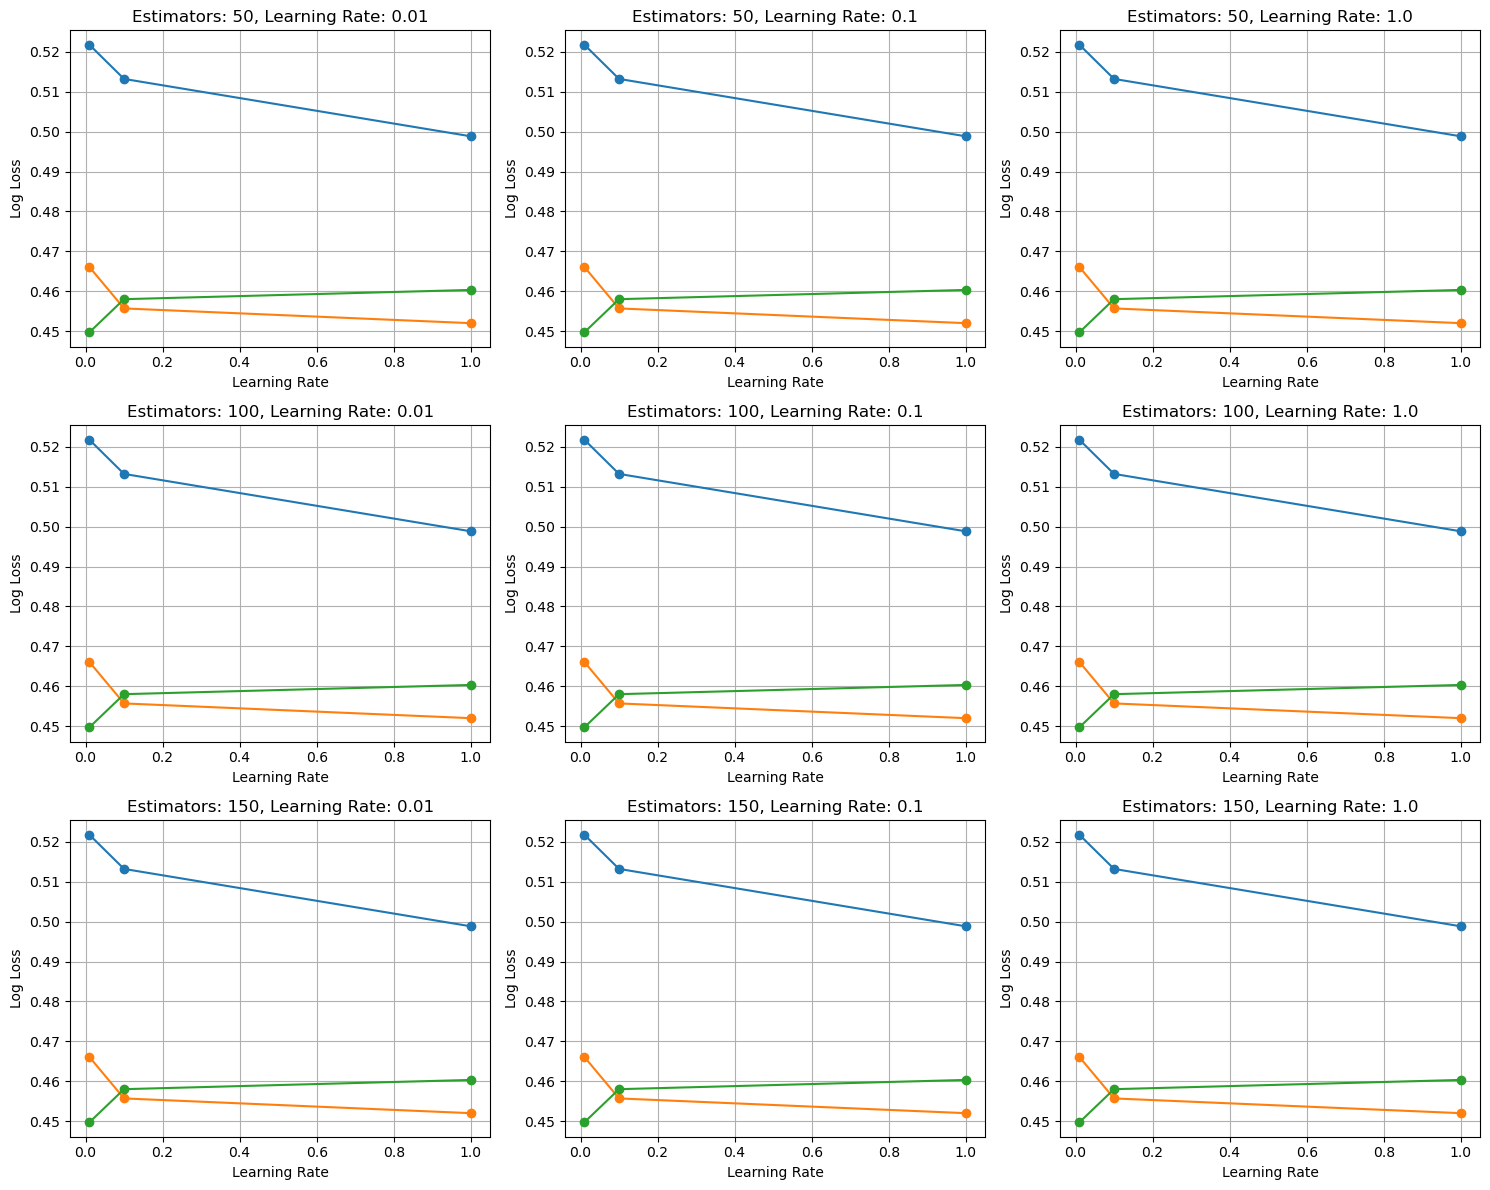

For values of best n_estimators = 50, learning_rate = 1.0, log loss on training set is: 0.3857044786909614
For values of best n_estimators = 50, learning_rate = 1.0, log loss on cross-validation set is: 0.667337785906299
For values of best n_estimators = 50, learning_rate = 1.0, log loss on test set is: 0.6697068269369135
Number of misclassified points: 0.242
***************Performance metric***************
Accuracy: 75.80%
-------------------- Confusion matrix --------------------


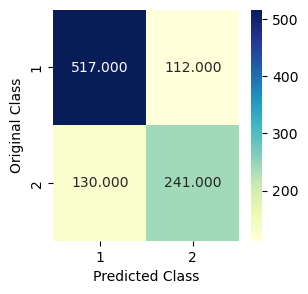

-------------------- Precision matrix (Column Sum=1) --------------------
Precision: 0.6827


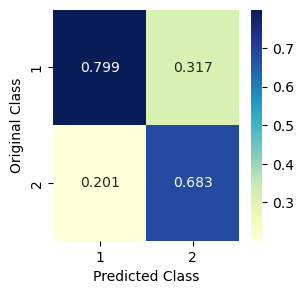

-------------------- Recall matrix (Row Sum=1) --------------------
Recall: 0.6496


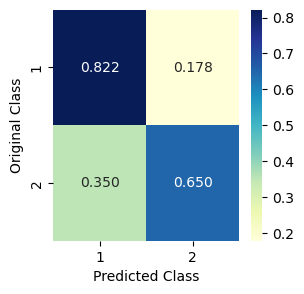

-------------------- F1 Score --------------------
F1 Score: 0.6657


In [74]:
n_estimators_values = [50, 100, 150]
learning_rate_values = [0.01, 0.1, 1.0]

adaboost_w2v_accuracy, adaboost_w2v_precision, adaboost_w2v_recall, adaboost_w2v_f1, adaboost_w2v_train_log_loss, adaboost_w2v_cv_log_loss, adaboost_w2v_test_log_loss, adaboost_w2v_misclassified_points = adaboost_model(X_train_w2v.values, y_train, X_cv_w2v.values, y_cv, X_test_w2v.values, y_test, n_estimators_values, learning_rate_values)

<h3>4.3.9 Gradient boosting </h3>

In [75]:
def gradient_boosting_model(X_train, y_train, X_cv, y_cv, X_test, y_test, n_estimators_list, learning_rate_list, max_depth_list):
    # Initialize arrays to store log loss for each combination of hyperparameters
    cv_log_error_estimators = np.zeros(len(n_estimators_list))
    cv_log_error_learning_rate = np.zeros(len(learning_rate_list))
    cv_log_error_depth = np.zeros(len(max_depth_list))
    cv_log_error_array = np.zeros((len(n_estimators_values), len(learning_rate_list), len(max_depth_list)))

    # Step 2: Loop through each value of n_estimators
    for i, n_estimators in enumerate(n_estimators_values):
        # Initialize Random Forest classifier with the current n_estimators value
        gb = GradientBoostingClassifier(n_estimators=n_estimators)
        # Fit the Random Forest model on the training data
        gb.fit(X_train, y_train)
        # Calibrate the model using sigmoid calibration
        sig_clf_gb = CalibratedClassifierCV(gb, method="sigmoid")
        sig_clf_gb.fit(X_train, y_train)
        # Predict probabilities on the cross-validation set
        sig_clf_probs_cv = sig_clf_gb.predict_proba(X_cv)
        # Calculate log loss and store in the array
        cv_log_error_estimators[i] = log_loss(y_cv, sig_clf_probs_cv, labels=gb.classes_)

    # Plot the cross-validation error for each value of n_estimators
    plt.plot(n_estimators_values, cv_log_error_estimators, marker='o')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Log Loss')
    plt.title("Cross Validation Error for each value of n_estimators")
    plt.show()
    
    # Step 2: Loop through each value of n_estimators
    for i, learning_rate in enumerate(learning_rate_list):
        # Initialize Random Forest classifier with the current n_estimators value
        gb = GradientBoostingClassifier(learning_rate=learning_rate)
        # Fit the Random Forest model on the training data
        gb.fit(X_train, y_train)
        # Calibrate the model using sigmoid calibration
        sig_clf_gb = CalibratedClassifierCV(gb, method="sigmoid")
        sig_clf_gb.fit(X_train, y_train)
        # Predict probabilities on the cross-validation set
        sig_clf_probs_cv = sig_clf_gb.predict_proba(X_cv)
        # Calculate log loss and store in the array
        cv_log_error_learning_rate[i] = log_loss(y_cv, sig_clf_probs_cv, labels=gb.classes_)

    # Plot the cross-validation error for each value of n_estimators
    plt.plot(learning_rate_list, cv_log_error_learning_rate, marker='o')
    plt.xlabel('Number of Learning rate')
    plt.ylabel('Log Loss')
    plt.title("Cross Validation Error for each value of learning_rate")
    plt.show()
    
    # Step 2: Loop through each value of n_estimators
    for i, max_depth in enumerate(max_depth_list):
        # Initialize Random Forest classifier with the current n_estimators value
        gb = GradientBoostingClassifier(max_depth=max_depth)
        # Fit the Random Forest model on the training data
        gb.fit(X_train, y_train)
        # Calibrate the model using sigmoid calibration
        sig_clf_gb = CalibratedClassifierCV(gb, method="sigmoid")
        sig_clf_gb.fit(X_train, y_train)
        # Predict probabilities on the cross-validation set
        sig_clf_probs_cv = sig_clf_gb.predict_proba(X_cv)
        # Calculate log loss and store in the array
        cv_log_error_depth[i] = log_loss(y_cv, sig_clf_probs_cv, labels=gb.classes_)

    # Plot the cross-validation error for each value of n_estimators
    plt.plot(max_depth_list, cv_log_error_depth, marker='o')
    plt.xlabel('Number of Max depth')
    plt.ylabel('Log Loss')
    plt.title("Cross Validation Error for each value of max_depth")
    plt.show()
    
    # Step 2: Loop through each value of n_estimators
    for i, n_estimators in enumerate(n_estimators_list):
        # Step 3: Loop through each value of learning_rate
        for j, learning_rate in enumerate(learning_rate_list):
            # Step 4: Loop through each value of max_depth
            for k, max_depth in enumerate(max_depth_list):
                # Initialize Gradient Boosting classifier with the current hyperparameter values
                gb = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)
                # Fit the Gradient Boosting model on the training data
                gb.fit(X_train, y_train)
                # Calibrate the model using sigmoid calibration
                sig_clf_gb = CalibratedClassifierCV(gb, method="sigmoid")
                sig_clf_gb.fit(X_train, y_train)
                # Predict probabilities on the cross-validation set
                sig_clf_probs_cv = sig_clf_gb.predict_proba(X_cv)
                # Calculate log loss and store in the array
                cv_log_error_array[i, j, k] = log_loss(y_cv, sig_clf_probs_cv, labels=gb.classes_)

    # Plot the cross-validation error for the best combination of hyperparameters
    fig, axs = plt.subplots(len(n_estimators_list), len(learning_rate_list), figsize=(15, 12))
    for idx, n_estimators in enumerate(n_estimators_list):
        for i, learning_rate in enumerate(learning_rate_list):
            cv_log_error_depth = np.zeros(len(max_depth_list))
            for j, max_depth in enumerate(max_depth_list):
                cv_log_error_depth[j] = cv_log_error_array[idx, i, j]
            
            axs[idx, i].plot(max_depth_list, cv_log_error_depth, marker='o')
            axs[idx, i].set_title(f'Estimators: {n_estimators}, Learning Rate: {learning_rate}')
            axs[idx, i].set_xlabel('Max Depth')
            axs[idx, i].set_ylabel('Log Loss')
            axs[idx, i].grid()

    plt.tight_layout()
    plt.show()

    # Identify the best hyperparameter values based on minimum log loss
    best_indices = np.unravel_index(np.argmin(cv_log_error_array), cv_log_error_array.shape)
    best_n_estimators = n_estimators_list[best_indices[0]]
    best_learning_rate = learning_rate_list[best_indices[1]]
    best_max_depth = max_depth_list[best_indices[2]]

    # Train the best model using the identified hyperparameter values
    best_gb = GradientBoostingClassifier(n_estimators=best_n_estimators, learning_rate=best_learning_rate, max_depth=best_max_depth, random_state=42)
    best_gb.fit(X_train, y_train)
    best_sig_clf_gb = CalibratedClassifierCV(best_gb, method="sigmoid")
    best_sig_clf_gb.fit(X_train, y_train)

    # Predict probabilities on the training set for the best model
    predict_y_train = best_sig_clf_gb.predict_proba(X_train)
    gb_train_log_loss = log_loss(y_train, predict_y_train, labels=best_gb.classes_)
    # Print log loss on the training set for the best model
    print('For values of best n_estimators = {}, learning_rate = {}, max_depth = {}, log loss on training set is: {}'.format(best_n_estimators, best_learning_rate, best_max_depth, gb_train_log_loss))

    # Predict probabilities on the cross-validation set for the best model
    predict_y_cv = best_gb.predict_proba(X_cv)
    gb_cv_log_loss = log_loss(y_cv, predict_y_cv, labels=best_gb.classes_)
    # Print log loss on the cross-validation set for the best model
    print('For values of best n_estimators = {}, learning_rate = {}, max_depth = {}, log loss on cross-validation set is: {}'.format(best_n_estimators, best_learning_rate, best_max_depth, gb_cv_log_loss))

    # Predict probabilities on the test set for the best model
    predict_y_test = best_gb.predict_proba(X_test)
    gb_test_log_loss = log_loss(y_test, predict_y_test, labels=best_gb.classes_)
    # Print log loss on the test set for the best model
    print('For values of best n_estimators = {}, learning_rate = {}, max_depth = {}, log loss on test set is: {}'.format(best_n_estimators, best_learning_rate, best_max_depth, gb_test_log_loss))

    # Predict on the test set and evaluate model performance
    predict_y = best_sig_clf_gb.predict(X_test)
    gb_misclassified_points = np.count_nonzero((best_sig_clf_gb.predict(X_test) - y_test)) / y_test.shape[0]
    print("Number of misclassified points:", gb_misclassified_points)
    # Print additional model pegbormance metrics
    gb_accuracy, gb_precision, gb_recall, gb_f1 = model_performance_metrics(y_test, predict_y)
    
    return gb_accuracy, gb_precision, gb_recall, gb_f1, gb_train_log_loss, gb_cv_log_loss, gb_test_log_loss, gb_misclassified_points

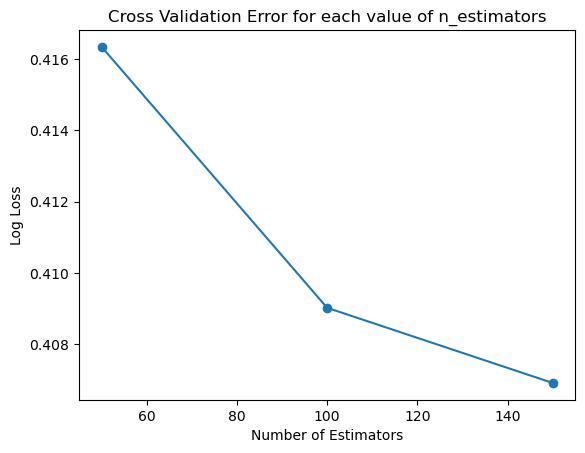

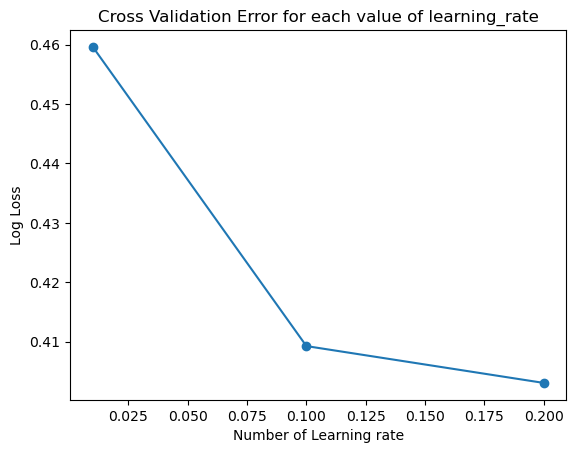

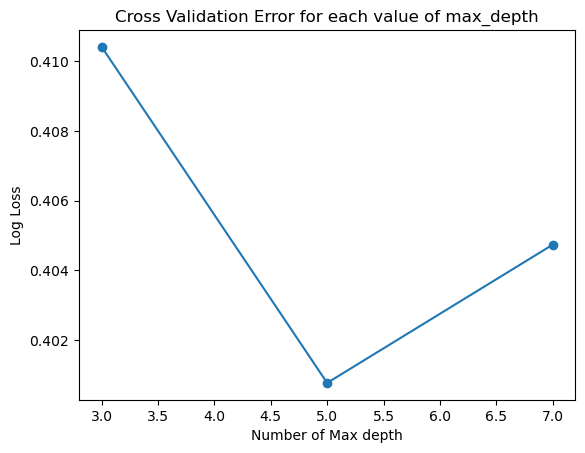

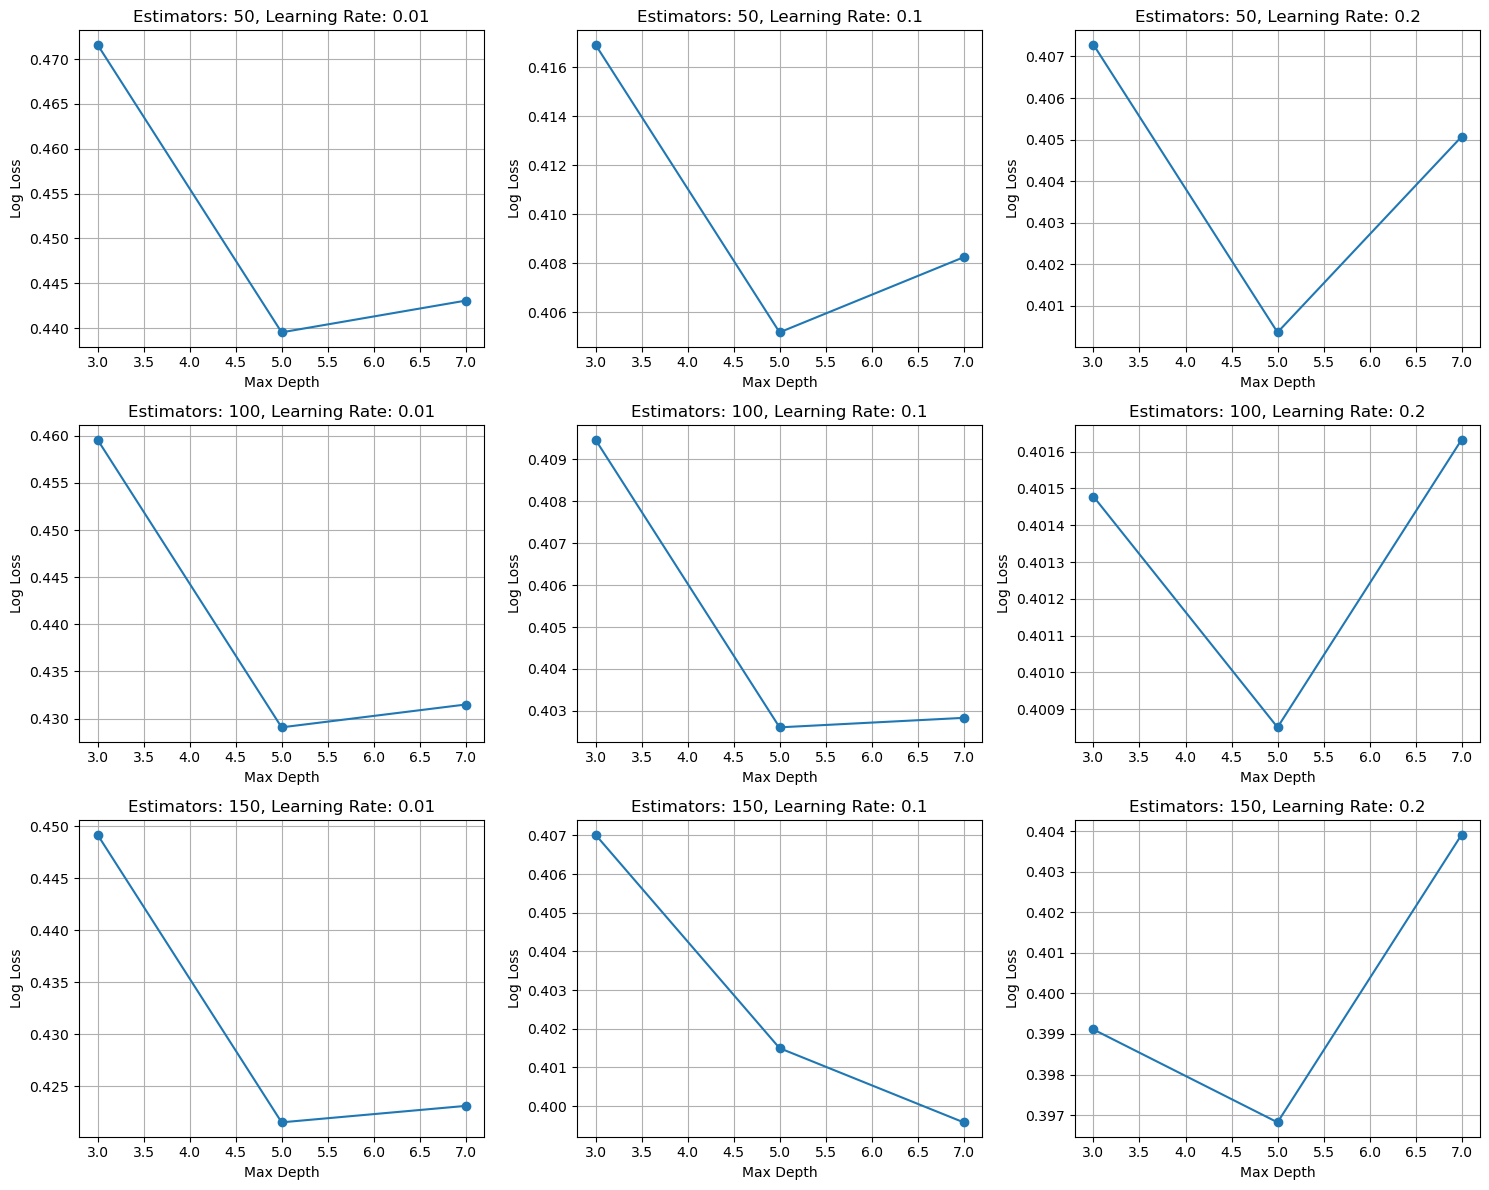

For values of best n_estimators = 150, learning_rate = 0.2, max_depth = 5, log loss on training set is: 0.2234253721542271
For values of best n_estimators = 150, learning_rate = 0.2, max_depth = 5, log loss on cross-validation set is: 0.40227747324695684
For values of best n_estimators = 150, learning_rate = 0.2, max_depth = 5, log loss on test set is: 0.42182795596498746
Number of misclassified points: 0.223
***************Performance metric***************
Accuracy: 77.70%
-------------------- Confusion matrix --------------------


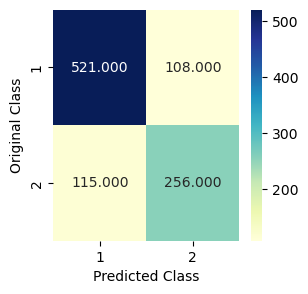

-------------------- Precision matrix (Column Sum=1) --------------------
Precision: 0.7033


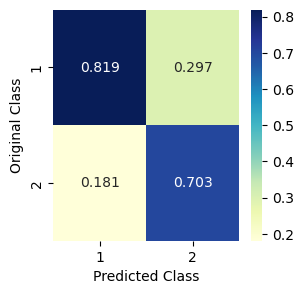

-------------------- Recall matrix (Row Sum=1) --------------------
Recall: 0.6900


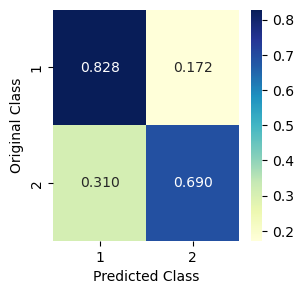

-------------------- F1 Score --------------------
F1 Score: 0.6966


In [76]:
n_estimators_list = [50, 100, 150]
learning_rate_list = [0.01, 0.1, 0.2]
max_depth_list = [3, 5, 7]

gb_bow_accuracy, gb_bow_precision, gb_bow_recall, gb_bow_f1, gb_bow_train_log_loss, gb_bow_cv_log_loss, gb_bow_test_log_loss, gb_bow_misclassified_points = gradient_boosting_model(X_train_bow.values, y_train, X_cv_bow.values, y_cv, X_test_bow.values, y_test, n_estimators_list, learning_rate_list, max_depth_list)

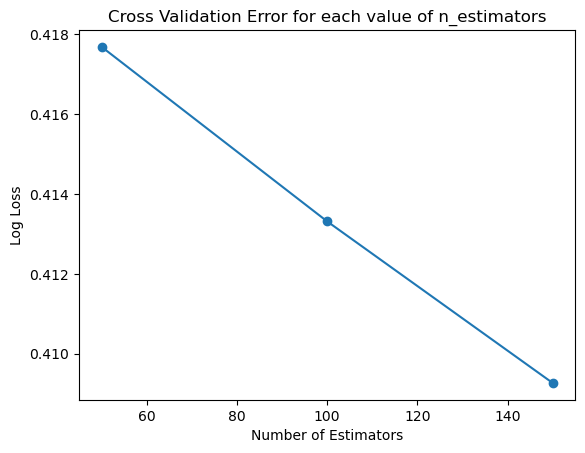

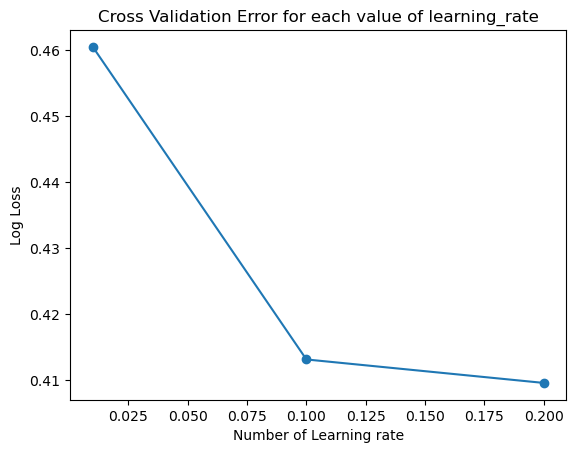

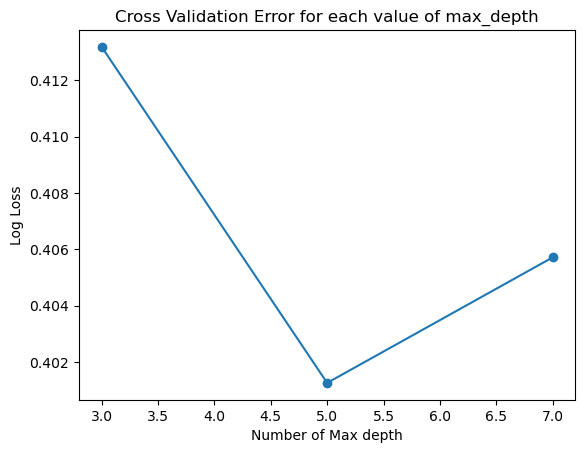

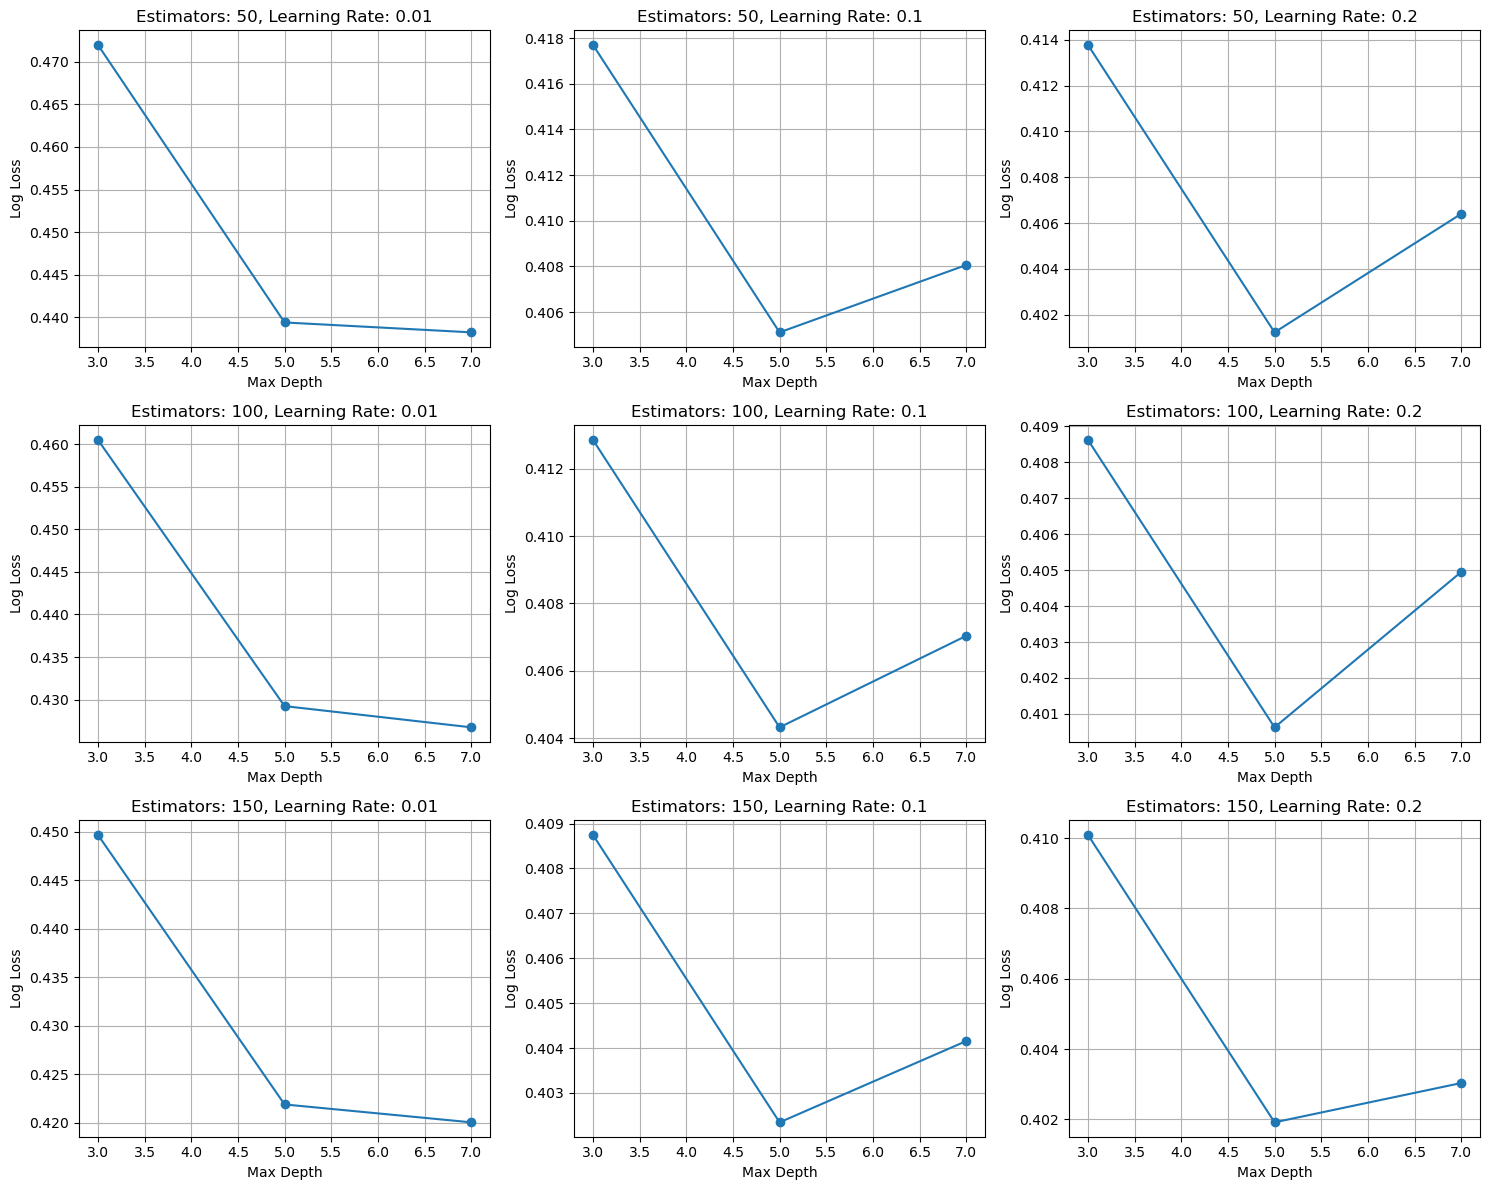

For values of best n_estimators = 100, learning_rate = 0.2, max_depth = 5, log loss on training set is: 0.24261674757157875
For values of best n_estimators = 100, learning_rate = 0.2, max_depth = 5, log loss on cross-validation set is: 0.40903880979447105
For values of best n_estimators = 100, learning_rate = 0.2, max_depth = 5, log loss on test set is: 0.4302041961497932
Number of misclassified points: 0.225
***************Performance metric***************
Accuracy: 77.50%
-------------------- Confusion matrix --------------------


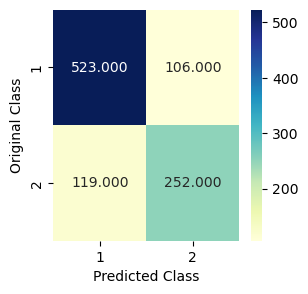

-------------------- Precision matrix (Column Sum=1) --------------------
Precision: 0.7039


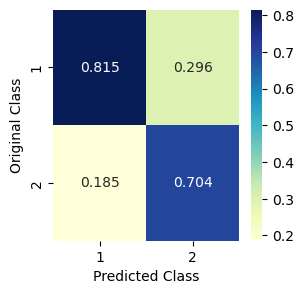

-------------------- Recall matrix (Row Sum=1) --------------------
Recall: 0.6792


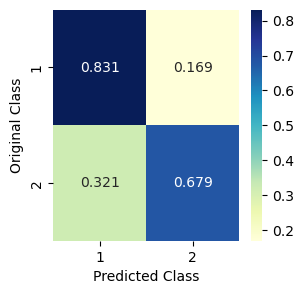

-------------------- F1 Score --------------------
F1 Score: 0.6914


In [77]:
n_estimators_list = [50, 100, 150]
learning_rate_list = [0.01, 0.1, 0.2]
max_depth_list = [3, 5, 7]

gb_tfidf_accuracy, gb_tfidf_precision, gb_tfidf_recall, gb_tfidf_f1, gb_tfidf_train_log_loss, gb_tfidf_cv_log_loss, gb_tfidf_test_log_loss, gb_tfidf_misclassified_points = gradient_boosting_model(X_train_tfidf.values, y_train, X_cv_tfidf.values, y_cv, X_test_tfidf.values, y_test, n_estimators_list, learning_rate_list, max_depth_list)

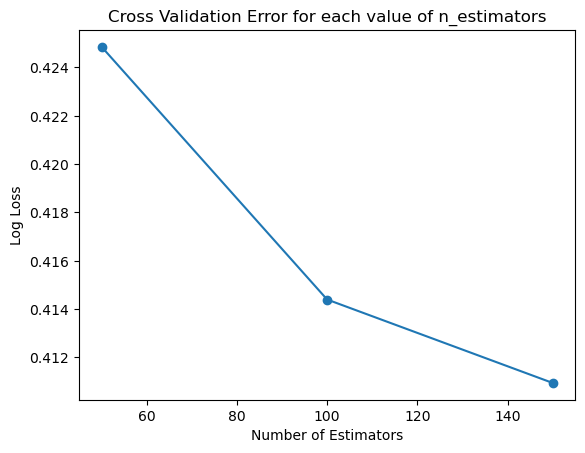

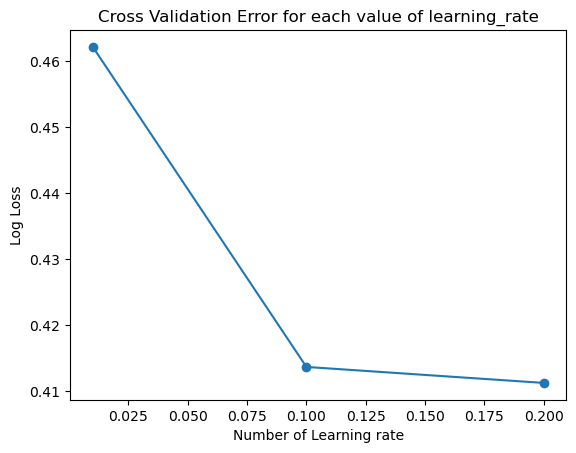

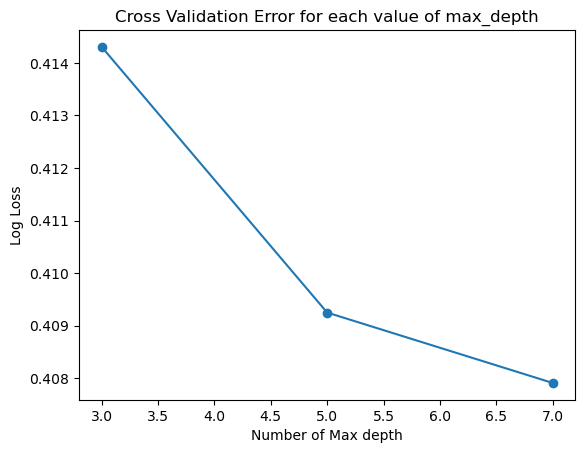

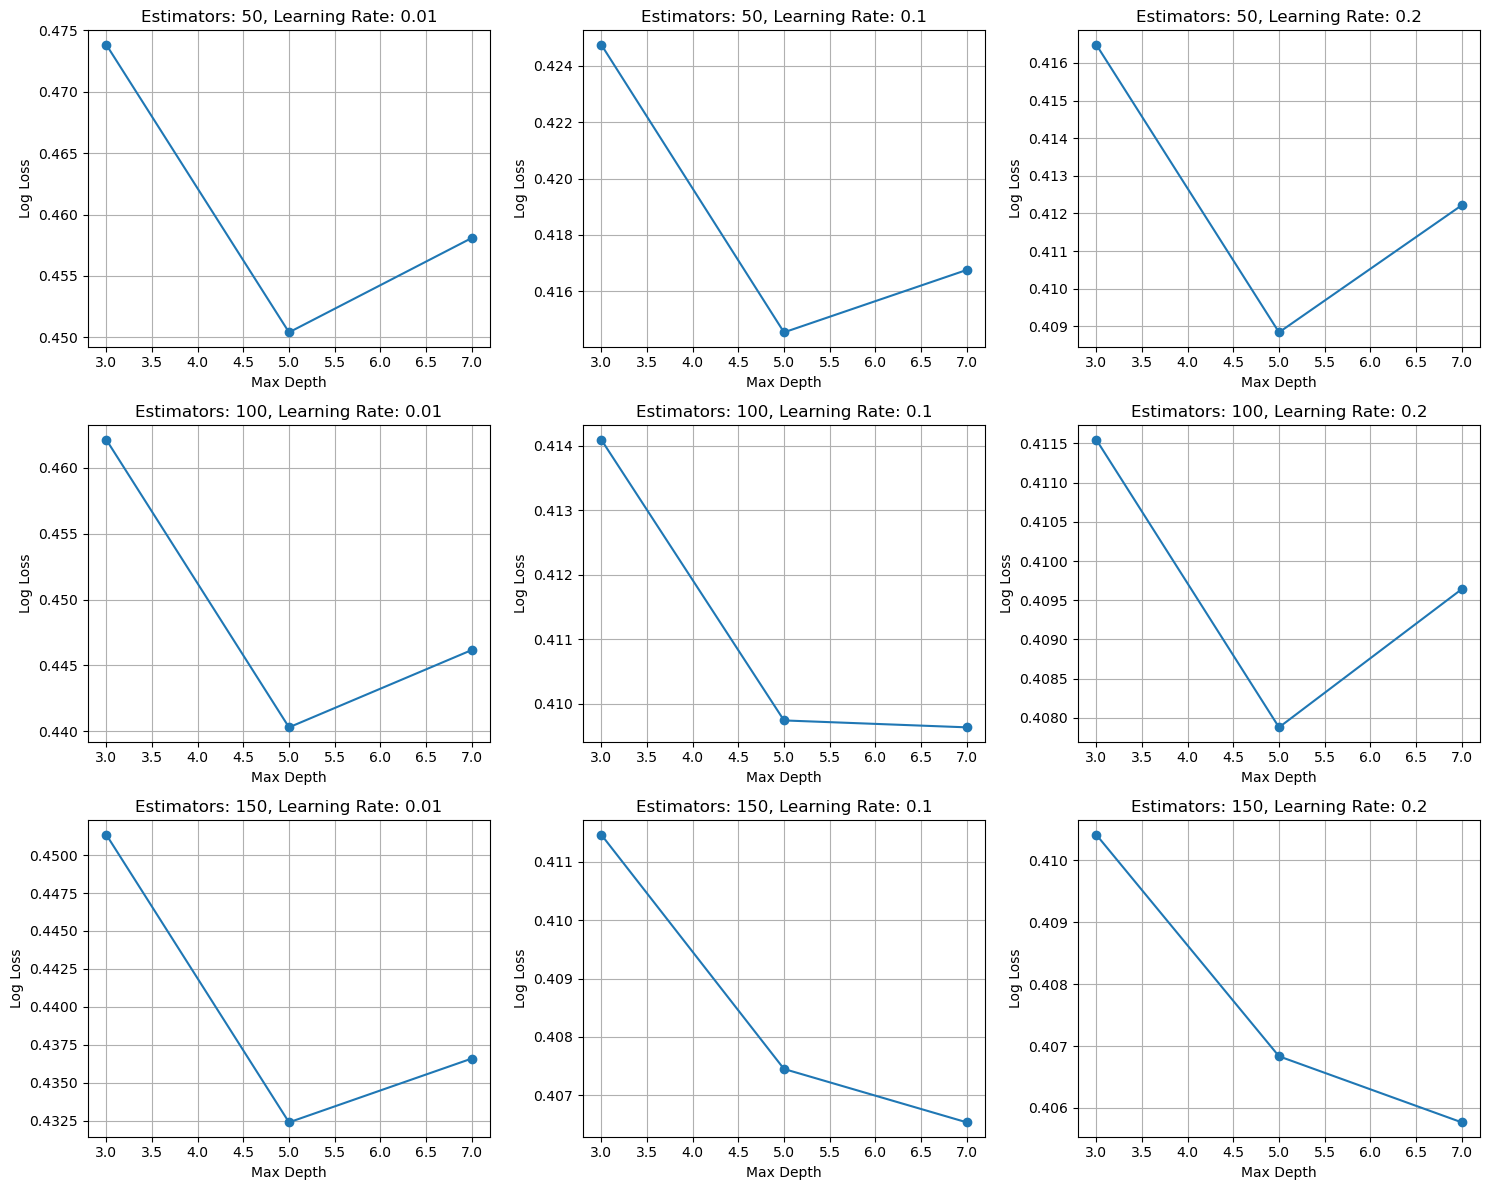

For values of best n_estimators = 150, learning_rate = 0.2, max_depth = 7, log loss on training set is: 0.10997753561624456
For values of best n_estimators = 150, learning_rate = 0.2, max_depth = 7, log loss on cross-validation set is: 0.5554584184622631
For values of best n_estimators = 150, learning_rate = 0.2, max_depth = 7, log loss on test set is: 0.6339191275526309
Number of misclassified points: 0.228
***************Performance metric***************
Accuracy: 77.20%
-------------------- Confusion matrix --------------------


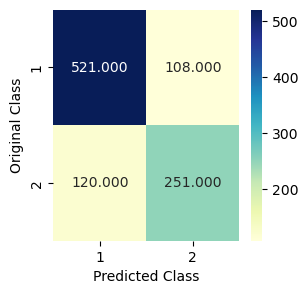

-------------------- Precision matrix (Column Sum=1) --------------------
Precision: 0.6992


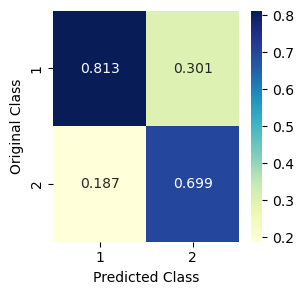

-------------------- Recall matrix (Row Sum=1) --------------------
Recall: 0.6765


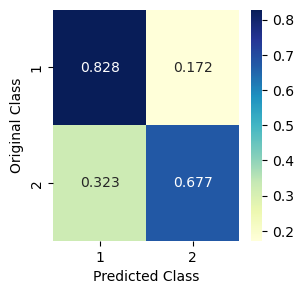

-------------------- F1 Score --------------------
F1 Score: 0.6877


In [78]:
n_estimators_list = [50, 100, 150]
learning_rate_list = [0.01, 0.1, 0.2]
max_depth_list = [3, 5, 7]

gb_w2v_accuracy, gb_w2v_precision, gb_w2v_recall, gb_w2v_f1, gb_w2v_train_log_loss, gb_w2v_cv_log_loss, gb_w2v_test_log_loss, gb_w2v_misclassified_points = gradient_boosting_model(X_train_w2v.values, y_train, X_cv_w2v.values, y_cv, X_test_w2v.values, y_test, n_estimators_list, learning_rate_list, max_depth_list)

<h3>4.3.10 XG boosting</h3>

In [79]:
def xgboost_model(X_train, y_train, X_cv, y_cv, X_test, y_test, n_estimators_values, learning_rate_values, max_depth_values):
    cv_log_error_estimators = np.zeros(len(n_estimators_list))
    cv_log_error_learning_rate = np.zeros(len(learning_rate_list))
    cv_log_error_depth = np.zeros(len(max_depth_list))
    cv_log_error_array = np.zeros((len(n_estimators_list), len(learning_rate_list), len(max_depth_list)))

    for i, n_estimators in enumerate(n_estimators_list):
        xgb_model = XGBClassifier(n_estimators=n_estimators)
        xgb_model.fit(X_train, y_train)
        sig_clf_xgb = CalibratedClassifierCV(xgb_model, method="sigmoid")
        sig_clf_xgb.fit(X_train, y_train)
        sig_clf_probs_cv = sig_clf_xgb.predict_proba(X_cv)
        cv_log_error_estimators[i] = log_loss(y_cv, sig_clf_probs_cv, labels=xgb_model.classes_)

    plt.plot(n_estimators_list, cv_log_error_estimators, marker='o')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Log Loss')
    plt.title("Cross Validation Error for each value of n_estimators")
    plt.show()

    for i, learning_rate in enumerate(learning_rate_list):
        xgb_model = XGBClassifier(learning_rate=learning_rate)
        xgb_model.fit(X_train, y_train)
        sig_clf_xgb = CalibratedClassifierCV(xgb_model, method="sigmoid")
        sig_clf_xgb.fit(X_train, y_train)
        sig_clf_probs_cv = sig_clf_xgb.predict_proba(X_cv)
        cv_log_error_learning_rate[i] = log_loss(y_cv, sig_clf_probs_cv, labels=xgb_model.classes_)
        
    plt.plot(learning_rate_list, cv_log_error_learning_rate, marker='o')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Log Loss')
    plt.title("Cross Validation Error for each value of learning_rate")
    plt.show()
    
    
    for i, max_depth in enumerate(max_depth_list):
        xgb_model = XGBClassifier(max_depth=max_depth)
        xgb_model.fit(X_train, y_train)
        sig_clf_xgb = CalibratedClassifierCV(xgb_model, method="sigmoid")
        sig_clf_xgb.fit(X_train, y_train)
        sig_clf_probs_cv = sig_clf_xgb.predict_proba(X_cv)
        cv_log_error_depth[i] = log_loss(y_cv, sig_clf_probs_cv, labels=xgb_model.classes_)
        
    plt.plot(max_depth_list, cv_log_error_depth, marker='o')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Log Loss')
    plt.title("Cross Validation Error for each value of learning_rate")
    plt.show()

    # Step 2: Loop through each combination of hyperparameter values
    for i, n_estimators in enumerate(n_estimators_list):
        for j, learning_rate in enumerate(learning_rate_list):
            for k, max_depth in enumerate(max_depth_list):
                # Initialize XGBoost classifier with the current set of hyperparameter values
                xgboost = xgb.XGBClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=42)
                    
                # Fit the XGBoost model on the training data
                xgboost.fit(X_train, y_train)
                    
                # Calibrate the model using sigmoid calibration
                sig_clf_xgboost = CalibratedClassifierCV(xgboost, method="sigmoid")
                sig_clf_xgboost.fit(X_train, y_train)
                    
                # Predict probabilities on the cross-validation set
                sig_clf_probs_cv = sig_clf_xgboost.predict_proba(X_cv)

                # Calculate log loss and store in the array
                cv_log_error_array[i, j, k] = log_loss(y_cv, sig_clf_probs_cv, labels=xgboost.classes_)

                # Print log loss for the current set of hyperparameters
                print('For n_estimators = {}, learning_rate = {}, max_depth = {}, log loss is: {}'.format(n_estimators, learning_rate, max_depth, cv_log_error_array[i, j, k]))

    # Step 3: Identify the best hyperparameter values based on minimum log loss
    best_indices = np.unravel_index(np.argmin(cv_log_error_array), cv_log_error_array.shape)
    best_n_estimators = n_estimators_list[best_indices[0]]
    best_learning_rate = learning_rate_list[best_indices[1]]
    best_max_depth = max_depth_list[best_indices[2]]

    # Step 4: Plot the cross-validation error for each combination of hyperparameter values
    fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
    ax.plot_surface(learning_rate_list, n_estimators_list, cv_log_error_array[:, :, best_indices[2]], cmap='viridis')
    ax.set_xlabel('Learning Rate')
    ax.set_ylabel('Number of Estimators')
    ax.set_zlabel('Log Loss')
    plt.title("Cross Validation Error for each combination of hyperparameters")
    plt.show()

    # Step 5: Train the best model using the identified hyperparameter values
    best_xgboost = xgb.XGBClassifier(n_estimators=best_n_estimators, learning_rate=best_learning_rate, max_depth=best_max_depth, random_state=42)
    best_xgboost.fit(X_train, y_train)

    # Calibrate the best model using sigmoid calibration
    best_sig_clf_xgboost = CalibratedClassifierCV(best_xgboost, method="sigmoid")
    best_sig_clf_xgboost.fit(X_train, y_train)
    
    # Predict probabilities on the training set for the best model
    predict_y_train = best_sig_clf_xgboost.predict_proba(X_train)
    xgb_train_log_loss = log_loss(y_train, predict_y_train, labels=best_xgboost.classes_)
    # Print log loss on the training set for the best model
    print('For n_estimators = {}, learning_rate = {}, max_depth = {}, log loss is: {}'.format(best_n_estimators, best_learning_rate, best_max_depth, log_loss(y_train, predict_y_train, labels=best_xgboost.classes_)))
    
    # Predict probabilities on the cross-validation set for the best model
    predict_y_cv = best_sig_clf_xgboost.predict_proba(X_cv)
    xgb_cv_log_loss = log_loss(y_cv, predict_y_cv, labels=best_xgboost.classes_)
    # Print log loss on the cross-validation set for the best model
    print('For n_estimators = {}, learning_rate = {}, max_depth = {}, log loss is: {}'.format(best_n_estimators, best_learning_rate, best_max_depth, log_loss(y_cv, predict_y_cv, labels=best_xgboost.classes_)))

    # Predict probabilities on the test set for the best model
    predict_y_test = best_sig_clf_xgboost.predict_proba(X_test)
    xgb_test_log_loss = log_loss(y_test, predict_y_test, labels=best_xgboost.classes_)
    # Print log loss on the test set for the best model
    print('For n_estimators = {}, learning_rate = {}, max_depth = {}, log loss is: {}'.format(best_n_estimators, best_learning_rate, best_max_depth, log_loss(y_test, predict_y_test, labels=best_xgboost.classes_)))
    
    # Predict on the test set and evaluate model performance
    predict_y = best_sig_clf_xgboost.predict(X_test)
    xgb_misclassified_points = np.count_nonzero((best_sig_clf_xgboost.predict(X_test) - y_test)) / y_test.shape[0]
    print("Number of misclassified points:", np.count_nonzero((predict_y - y_test) != 0) / y_test.shape[0])
    xgb_accuracy, xgb_precision, xgb_recall, xgb_f1 = model_performance_metrics(y_test, predict_y)
    
    return xgb_accuracy, xgb_precision, xgb_recall, xgb_f1, xgb_train_log_loss, xgb_cv_log_loss, xgb_test_log_loss, xgb_misclassified_points

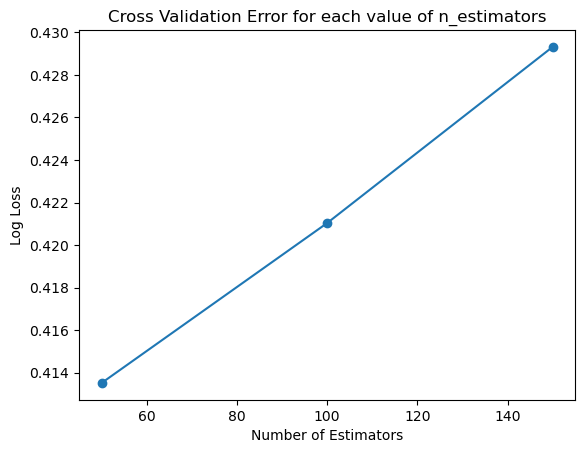

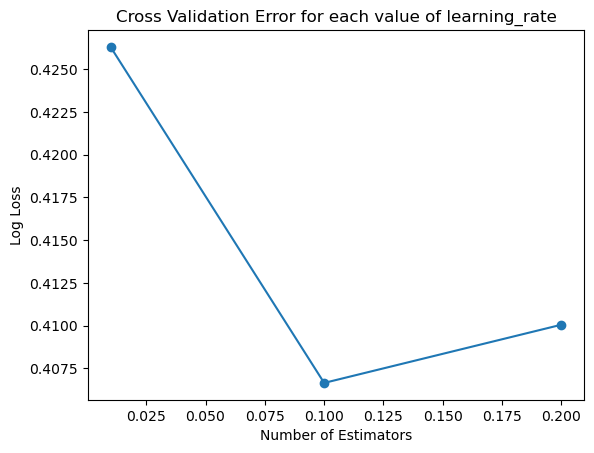

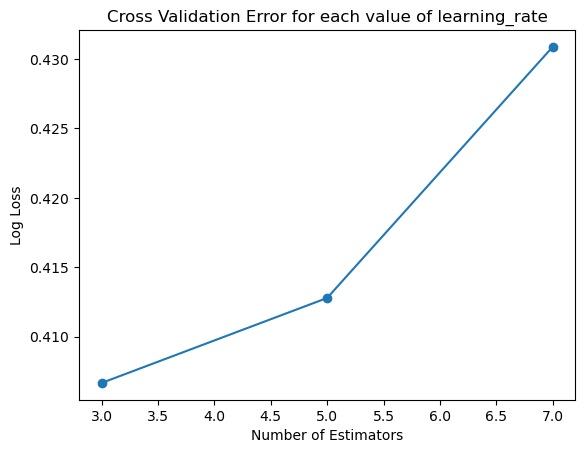

For n_estimators = 50, learning_rate = 0.01, max_depth = 3, log loss is: 0.47195623110686996
For n_estimators = 50, learning_rate = 0.01, max_depth = 5, log loss is: 0.44271188703210657
For n_estimators = 50, learning_rate = 0.01, max_depth = 7, log loss is: 0.4382691482443899
For n_estimators = 50, learning_rate = 0.1, max_depth = 3, log loss is: 0.4239042563985718
For n_estimators = 50, learning_rate = 0.1, max_depth = 5, log loss is: 0.4093100469938864
For n_estimators = 50, learning_rate = 0.1, max_depth = 7, log loss is: 0.41470439032740714
For n_estimators = 50, learning_rate = 0.2, max_depth = 3, log loss is: 0.417027008925027
For n_estimators = 50, learning_rate = 0.2, max_depth = 5, log loss is: 0.4046993326525062
For n_estimators = 50, learning_rate = 0.2, max_depth = 7, log loss is: 0.4143632846676884
For n_estimators = 100, learning_rate = 0.01, max_depth = 3, log loss is: 0.4584059076020903
For n_estimators = 100, learning_rate = 0.01, max_depth = 5, log loss is: 0.4314407

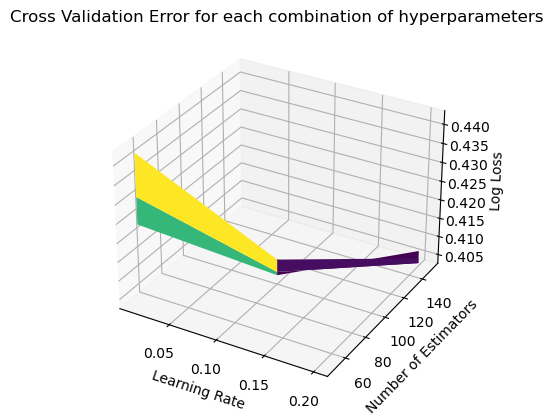

For n_estimators = 100, learning_rate = 0.2, max_depth = 5, log loss is: 0.24752475898054693
For n_estimators = 100, learning_rate = 0.2, max_depth = 5, log loss is: 0.4033786461401323
For n_estimators = 100, learning_rate = 0.2, max_depth = 5, log loss is: 0.4261622471232071
Number of misclassified points: 0.21
***************Performance metric***************
Accuracy: 79.00%
-------------------- Confusion matrix --------------------


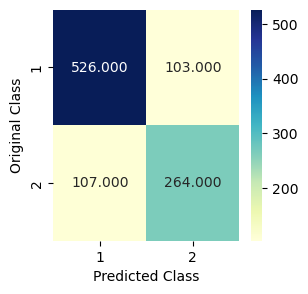

-------------------- Precision matrix (Column Sum=1) --------------------
Precision: 0.7193


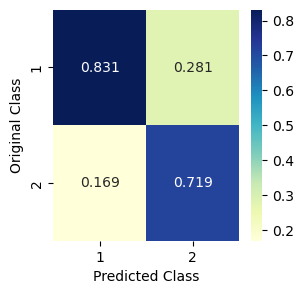

-------------------- Recall matrix (Row Sum=1) --------------------
Recall: 0.7116


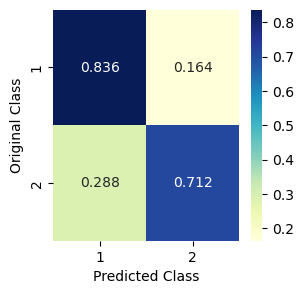

-------------------- F1 Score --------------------
F1 Score: 0.7154


In [80]:
n_estimators_values = [50, 100, 150]
learning_rate_values = [0.01, 0.1, 1.0]
max_depth_values = [3, 5, 7]

xgb_bow_accuracy, xgb_bow_precision, xgb_bow_recall, xgb_bow_f1, xgb_bow_train_log_loss, xgb_bow_cv_log_loss, xgb_bow_test_log_loss, xgb_bow_misclassified_points = xgboost_model(X_train_bow.values, y_train, X_cv_bow.values, y_cv, X_test_bow.values, y_test, n_estimators_values, learning_rate_values, max_depth_values)

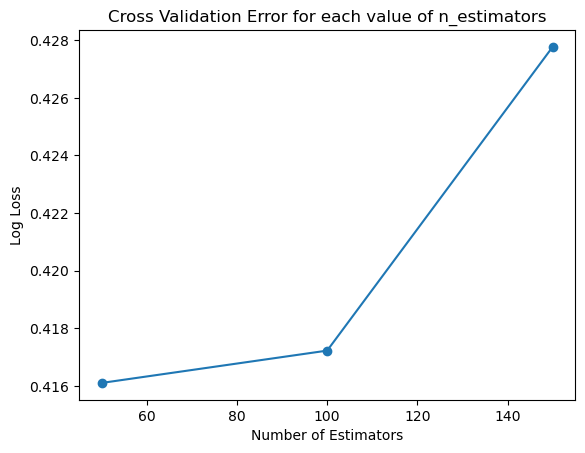

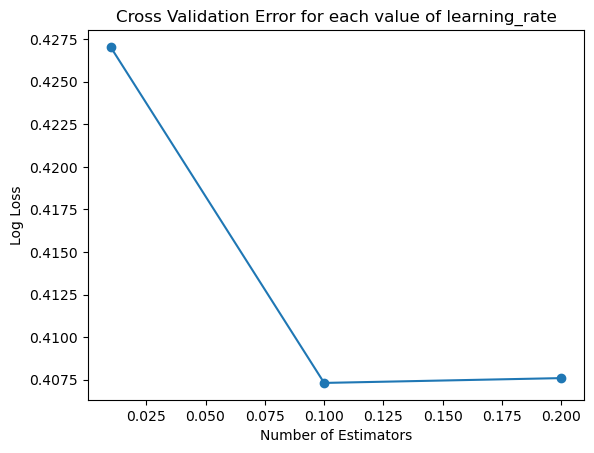

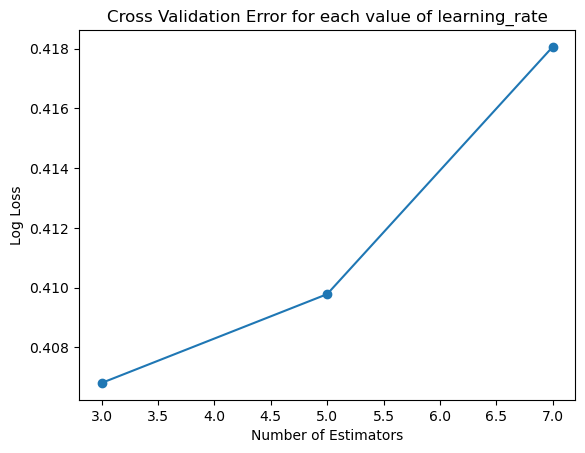

For n_estimators = 50, learning_rate = 0.01, max_depth = 3, log loss is: 0.47281978474392206
For n_estimators = 50, learning_rate = 0.01, max_depth = 5, log loss is: 0.443057379143861
For n_estimators = 50, learning_rate = 0.01, max_depth = 7, log loss is: 0.43958158070241526
For n_estimators = 50, learning_rate = 0.1, max_depth = 3, log loss is: 0.4268054807617434
For n_estimators = 50, learning_rate = 0.1, max_depth = 5, log loss is: 0.40948199639138866
For n_estimators = 50, learning_rate = 0.1, max_depth = 7, log loss is: 0.41322258805602
For n_estimators = 50, learning_rate = 0.2, max_depth = 3, log loss is: 0.41675123855246954
For n_estimators = 50, learning_rate = 0.2, max_depth = 5, log loss is: 0.4055698654985058
For n_estimators = 50, learning_rate = 0.2, max_depth = 7, log loss is: 0.41491480109662077
For n_estimators = 100, learning_rate = 0.01, max_depth = 3, log loss is: 0.45886162064743674
For n_estimators = 100, learning_rate = 0.01, max_depth = 5, log loss is: 0.430753

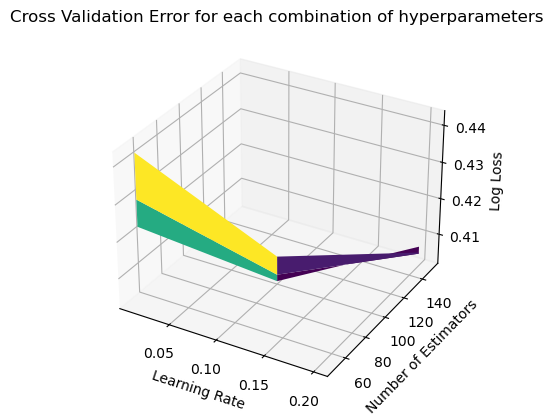

For n_estimators = 150, learning_rate = 0.1, max_depth = 5, log loss is: 0.26622888477878737
For n_estimators = 150, learning_rate = 0.1, max_depth = 5, log loss is: 0.4025335154631689
For n_estimators = 150, learning_rate = 0.1, max_depth = 5, log loss is: 0.4246675387686666
Number of misclassified points: 0.209
***************Performance metric***************
Accuracy: 79.10%
-------------------- Confusion matrix --------------------


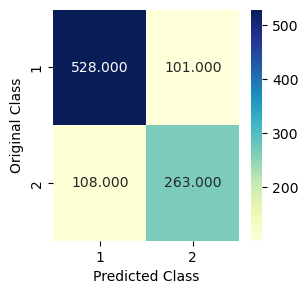

-------------------- Precision matrix (Column Sum=1) --------------------
Precision: 0.7225


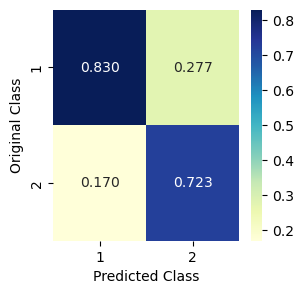

-------------------- Recall matrix (Row Sum=1) --------------------
Recall: 0.7089


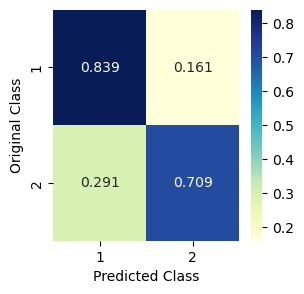

-------------------- F1 Score --------------------
F1 Score: 0.7156


In [81]:
n_estimators_values = [50, 100, 150]
learning_rate_values = [0.01, 0.1, 1.0]
max_depth_values = [3, 5, 7]

xgb_tfidf_accuracy, xgb_tfidf_precision, xgb_tfidf_recall, xgb_tfidf_f1, xgb_tfidf_train_log_loss, xgb_tfidf_cv_log_loss, xgb_tfidf_test_log_loss, xgb_tfidf_misclassified_points = xgboost_model(X_train_tfidf.values, y_train, X_cv_tfidf.values, y_cv, X_test_tfidf.values, y_test, n_estimators_values, learning_rate_values, max_depth_values)

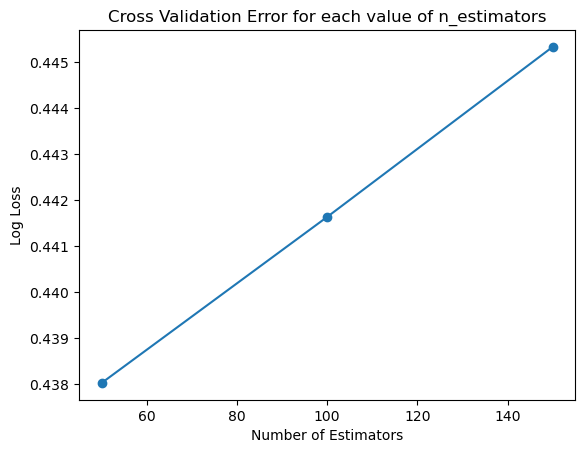

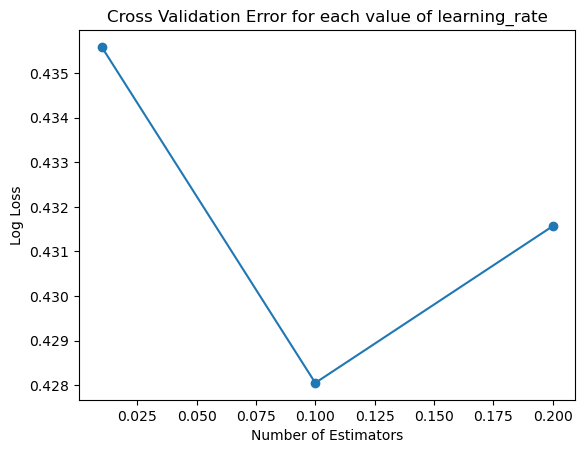

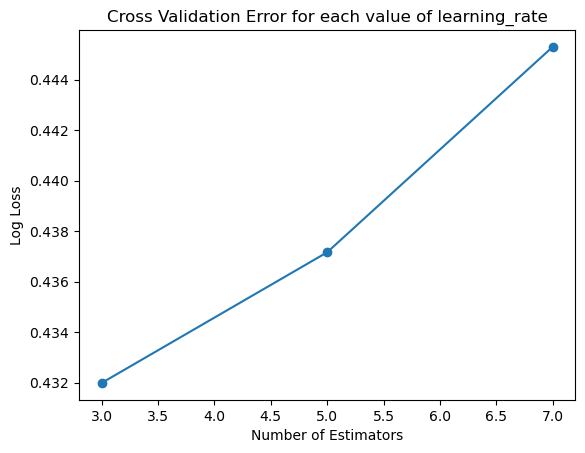

For n_estimators = 50, learning_rate = 0.01, max_depth = 3, log loss is: 0.47514632760395087
For n_estimators = 50, learning_rate = 0.01, max_depth = 5, log loss is: 0.4486546765090166
For n_estimators = 50, learning_rate = 0.01, max_depth = 7, log loss is: 0.44610078835426636
For n_estimators = 50, learning_rate = 0.1, max_depth = 3, log loss is: 0.434615910426768
For n_estimators = 50, learning_rate = 0.1, max_depth = 5, log loss is: 0.42276321383592974
For n_estimators = 50, learning_rate = 0.1, max_depth = 7, log loss is: 0.4199456504017614
For n_estimators = 50, learning_rate = 0.2, max_depth = 3, log loss is: 0.4280744487720555
For n_estimators = 50, learning_rate = 0.2, max_depth = 5, log loss is: 0.42061711978725186
For n_estimators = 50, learning_rate = 0.2, max_depth = 7, log loss is: 0.43725747027114936
For n_estimators = 100, learning_rate = 0.01, max_depth = 3, log loss is: 0.46110085977148757
For n_estimators = 100, learning_rate = 0.01, max_depth = 5, log loss is: 0.4375

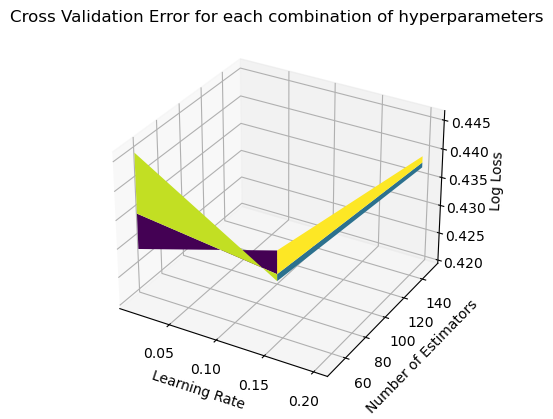

For n_estimators = 50, learning_rate = 0.1, max_depth = 7, log loss is: 0.1931759088559467
For n_estimators = 50, learning_rate = 0.1, max_depth = 7, log loss is: 0.4199456504017614
For n_estimators = 50, learning_rate = 0.1, max_depth = 7, log loss is: 0.44483227368142364
Number of misclassified points: 0.222
***************Performance metric***************
Accuracy: 77.80%
-------------------- Confusion matrix --------------------


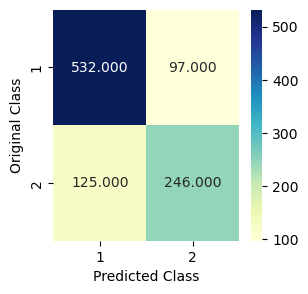

-------------------- Precision matrix (Column Sum=1) --------------------
Precision: 0.7172


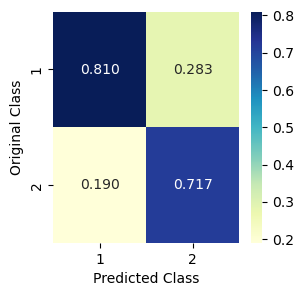

-------------------- Recall matrix (Row Sum=1) --------------------
Recall: 0.6631


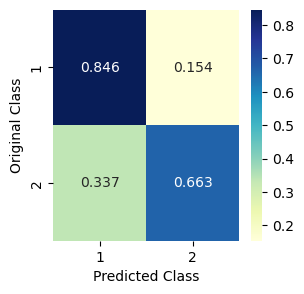

-------------------- F1 Score --------------------
F1 Score: 0.6891


In [82]:
n_estimators_values = [50, 100, 150]
learning_rate_values = [0.01, 0.1, 1.0]
max_depth_values = [3, 5, 7]

xgb_w2v_accuracy, xgb_w2v_precision, xgb_w2v_recall, xgb_w2v_f1, xgb_w2v_train_log_loss, xgb_w2v_cv_log_loss, xgb_w2v_test_log_loss, xgb_w2v_misclassified_points = xgboost_model(X_train_w2v.values, y_train, X_cv_w2v.values, y_cv, X_test_w2v.values, y_test, n_estimators_values, learning_rate_values, max_depth_values)

In [83]:
data = [
    {"Model": "Naive bayes", "Vectorization method": "BOW", "Accuracy": mnb_bow_accuracy, "Precision": mnb_bow_precision, "Recall": mnb_bow_recall, "F1-score": mnb_bow_f1, "Train log loss": mnb_bow_train_log_loss, "CV log loss": mnb_bow_cv_log_loss, "Test log loss": mnb_bow_test_log_loss, "Total misclassified points": mnb_bow_misclassified_points},
    {"Model": "Naive bayes", "Vectorization method": "TFIDF", "Accuracy": mnb_tfidf_accuracy, "Precision": mnb_tfidf_precision, "Recall": mnb_tfidf_recall, "F1-score": mnb_tfidf_f1, "Train log loss": mnb_tfidf_train_log_loss, "CV log loss": mnb_tfidf_cv_log_loss, "Test log loss": mnb_tfidf_test_log_loss, "Total misclassified points": mnb_tfidf_misclassified_points},
    {"Model": "Logistic regression", "Vectorization method": "BOW", "Accuracy": log_reg_sgd_bow_accuracy, "Precision": log_reg_sgd_bow_precision, "Recall": log_reg_sgd_bow_recall, "F1-score": log_reg_sgd_bow_f1, "Train log loss": log_reg_sgd_bow_train_log_loss, "CV log loss": log_reg_sgd_bow_cv_log_loss, "Test log loss": log_reg_sgd_bow_test_log_loss, "Total misclassified points": log_reg_sgd_bow_misclassified_points},
    {"Model": "Logistic regression", "Vectorization method": "TFIDF", "Accuracy": log_reg_sgd_tfidf_accuracy, "Precision": log_reg_sgd_tfidf_precision, "Recall": log_reg_sgd_tfidf_recall, "F1-score": log_reg_sgd_tfidf_f1, "Train log loss": log_reg_sgd_tfidf_train_log_loss, "CV log loss": log_reg_sgd_tfidf_cv_log_loss, "Test log loss": log_reg_sgd_tfidf_test_log_loss, "Total misclassified points": log_reg_sgd_tfidf_misclassified_points},
    {"Model": "Logistic regression", "Vectorization method": "W2V", "Accuracy": log_reg_sgd_w2v_accuracy, "Precision": log_reg_sgd_w2v_precision, "Recall": log_reg_sgd_w2v_recall, "F1-score": log_reg_sgd_w2v_f1, "Train log loss": log_reg_sgd_w2v_train_log_loss, "CV log loss": log_reg_sgd_w2v_cv_log_loss, "Test log loss": log_reg_sgd_w2v_test_log_loss, "Total misclassified points": log_reg_sgd_w2v_misclassified_points},
    {"Model": "Linear SVM", "Vectorization method": "BOW", "Accuracy": linear_svm_sgd_bow_accuracy, "Precision": linear_svm_sgd_bow_precision, "Recall": linear_svm_sgd_bow_recall, "F1-score": linear_svm_sgd_bow_f1, "Train log loss": linear_svm_sgd_bow_train_log_loss, "CV log loss": linear_svm_sgd_bow_cv_log_loss, "Test log loss": linear_svm_sgd_bow_test_log_loss, "Total misclassified points": linear_svm_sgd_bow_misclassified_points},
    {"Model": "Linear SVM", "Vectorization method": "TFIDF", "Accuracy": linear_svm_sgd_tfidf_accuracy, "Precision": linear_svm_sgd_tfidf_precision, "Recall": linear_svm_sgd_tfidf_recall, "F1-score": linear_svm_sgd_tfidf_f1, "Train log loss": linear_svm_sgd_tfidf_train_log_loss, "CV log loss": linear_svm_sgd_tfidf_cv_log_loss, "Test log loss": linear_svm_sgd_tfidf_test_log_loss, "Total misclassified points": linear_svm_sgd_tfidf_misclassified_points},
    {"Model": "Linear SVM", "Vectorization method": "W2V", "Accuracy": linear_svm_sgd_w2v_accuracy, "Precision": linear_svm_sgd_w2v_precision, "Recall": linear_svm_sgd_w2v_recall, "F1-score": linear_svm_sgd_w2v_f1, "Train log loss": linear_svm_sgd_w2v_train_log_loss, "CV log loss": linear_svm_sgd_w2v_cv_log_loss, "Test log loss": linear_svm_sgd_w2v_test_log_loss, "Total misclassified points": linear_svm_sgd_w2v_misclassified_points},
    {"Model": "Decision tree", "Vectorization method": "BOW", "Accuracy": dtree_bow_accuracy, "Precision": dtree_bow_precision, "Recall": dtree_bow_recall, "F1-score": dtree_bow_f1, "Train log loss": dtree_bow_train_log_loss, "CV log loss": dtree_bow_cv_log_loss, "Test log loss": dtree_bow_test_log_loss, "Total misclassified points": dtree_bow_misclassified_points},
    {"Model": "Decision tree", "Vectorization method": "TFIDF", "Accuracy": dtree_tfidf_accuracy, "Precision": dtree_tfidf_precision, "Recall": dtree_tfidf_recall, "F1-score": dtree_tfidf_f1, "Train log loss": dtree_tfidf_train_log_loss, "CV log loss": dtree_tfidf_cv_log_loss, "Test log loss": dtree_tfidf_test_log_loss, "Total misclassified points": dtree_tfidf_misclassified_points},
    {"Model": "Decision tree", "Vectorization method": "W2V", "Accuracy": dtree_w2v_accuracy, "Precision": dtree_w2v_precision, "Recall": dtree_w2v_recall, "F1-score": dtree_w2v_f1, "Train log loss": dtree_w2v_train_log_loss, "CV log loss": dtree_w2v_cv_log_loss, "Test log loss": dtree_w2v_test_log_loss, "Total misclassified points": dtree_w2v_misclassified_points},
    {"Model": "Random forest", "Vectorization method": "BOW", "Accuracy": rf_bow_accuracy, "Precision": rf_bow_precision, "Recall": rf_bow_recall, "F1-score": rf_bow_f1, "Train log loss": rf_bow_train_log_loss, "CV log loss": rf_bow_cv_log_loss, "Test log loss": rf_bow_test_log_loss, "Total misclassified points": rf_bow_misclassified_points},
    {"Model": "Random forest", "Vectorization method": "TFIDF", "Accuracy": rf_tfidf_accuracy, "Precision": rf_tfidf_precision, "Recall": rf_tfidf_recall, "F1-score": rf_tfidf_f1, "Train log loss": rf_tfidf_train_log_loss, "CV log loss": rf_tfidf_cv_log_loss, "Test log loss": rf_tfidf_test_log_loss, "Total misclassified points": rf_tfidf_misclassified_points},
    {"Model": "Random forest", "Vectorization method": "W2V", "Accuracy": rf_w2v_accuracy, "Precision": rf_w2v_precision, "Recall": rf_w2v_recall, "F1-score": rf_w2v_f1, "Train log loss": rf_w2v_train_log_loss, "CV log loss": rf_w2v_cv_log_loss, "Test log loss": rf_w2v_test_log_loss, "Total misclassified points": rf_w2v_misclassified_points},
    {"Model": "Adaboost", "Vectorization method": "BOW", "Accuracy": adaboost_bow_accuracy, "Precision": adaboost_bow_precision, "Recall": adaboost_bow_recall, "F1-score": adaboost_bow_f1, "Train log loss": adaboost_bow_train_log_loss, "CV log loss": adaboost_bow_cv_log_loss, "Test log loss": adaboost_bow_test_log_loss, "Total misclassified points": adaboost_bow_misclassified_points},
    {"Model": "Adaboost", "Vectorization method": "TFIDF", "Accuracy": adaboost_tfidf_accuracy, "Precision": adaboost_tfidf_precision, "Recall": adaboost_tfidf_recall, "F1-score": adaboost_tfidf_f1, "Train log loss": adaboost_tfidf_train_log_loss, "CV log loss": adaboost_tfidf_cv_log_loss, "Test log loss": adaboost_tfidf_test_log_loss, "Total misclassified points": adaboost_tfidf_misclassified_points},
    {"Model": "Adaboost", "Vectorization method": "W2V", "Accuracy": adaboost_w2v_accuracy, "Precision": adaboost_w2v_precision, "Recall": adaboost_w2v_recall, "F1-score": adaboost_w2v_f1, "Train log loss": adaboost_w2v_train_log_loss, "CV log loss": adaboost_w2v_cv_log_loss, "Test log loss": adaboost_w2v_test_log_loss, "Total misclassified points": adaboost_w2v_misclassified_points},
    {"Model": "Gradient boosting", "Vectorization method": "BOW", "Accuracy": gb_bow_accuracy, "Precision": gb_bow_precision, "Recall": gb_bow_recall, "F1-score": gb_bow_f1, "Train log loss": gb_bow_train_log_loss, "CV log loss": gb_bow_cv_log_loss, "Test log loss": gb_bow_test_log_loss, "Total misclassified points": gb_bow_misclassified_points},
    {"Model": "Gradient boosting", "Vectorization method": "TFIDF", "Accuracy": gb_tfidf_accuracy, "Precision": gb_tfidf_precision, "Recall": gb_tfidf_recall, "F1-score": gb_tfidf_f1, "Train log loss": gb_tfidf_train_log_loss, "CV log loss": gb_tfidf_cv_log_loss, "Test log loss": gb_tfidf_test_log_loss, "Total misclassified points": gb_tfidf_misclassified_points},
    {"Model": "Gradient boosting", "Vectorization method": "W2V", "Accuracy": gb_w2v_accuracy, "Precision": gb_w2v_precision, "Recall": gb_w2v_recall, "F1-score": gb_w2v_f1, "Train log loss": gb_w2v_train_log_loss, "CV log loss": gb_w2v_cv_log_loss, "Test log loss": gb_w2v_test_log_loss, "Total misclassified points": gb_w2v_misclassified_points},
    {"Model": "XG Boost", "Vectorization method": "BOW", "Accuracy": xgb_bow_accuracy, "Precision": xgb_bow_precision, "Recall": xgb_bow_recall, "F1-score": xgb_bow_f1, "Train log loss": xgb_bow_train_log_loss, "CV log loss": xgb_bow_cv_log_loss, "Test log loss": xgb_bow_test_log_loss, "Total misclassified points": xgb_bow_misclassified_points},
    {"Model": "XG Boost", "Vectorization method": "TFIDF", "Accuracy": xgb_tfidf_accuracy, "Precision": xgb_tfidf_precision, "Recall": xgb_tfidf_recall, "F1-score": xgb_tfidf_f1, "Train log loss": xgb_tfidf_train_log_loss, "CV log loss": xgb_tfidf_cv_log_loss, "Test log loss": xgb_tfidf_test_log_loss, "Total misclassified points": xgb_tfidf_misclassified_points},
    {"Model": "XG Boost", "Vectorization method": "W2V", "Accuracy": xgb_w2v_accuracy, "Precision": xgb_w2v_precision, "Recall": xgb_w2v_recall, "F1-score": xgb_w2v_f1, "Train log loss": xgb_w2v_train_log_loss, "CV log loss": xgb_w2v_cv_log_loss, "Test log loss": xgb_w2v_test_log_loss, "Total misclassified points": xgb_w2v_misclassified_points},
]

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Print the DataFrame
df

Model Vectorization method  Accuracy  Precision    Recall  \
0           Naive bayes                  BOW     0.680   0.585284  0.471698   
1           Naive bayes                TFIDF     0.680   0.585284  0.471698   
2   Logistic regression                  BOW     0.704   0.781955  0.280323   
3   Logistic regression                TFIDF     0.681   0.750000  0.210243   
4   Logistic regression                  W2V     0.675   0.664286  0.250674   
5            Linear SVM                  BOW     0.695   0.655660  0.374663   
6            Linear SVM                TFIDF     0.701   0.790323  0.264151   
7            Linear SVM                  W2V     0.700   0.775194  0.269542   
8         Decision tree                  BOW     0.755   0.708609  0.576819   
9         Decision tree                TFIDF     0.752   0.702970  0.574124   
10        Decision tree                  W2V     0.726   0.677656  0.498652   
11        Random forest                  BOW     0.757   0.672043  0.673854   
12        Random forest                TFIDF     0.760   0.680441  0.665768   
13        Random forest                  W2V     0.736   0.657817  0.601078   
14             Adaboost                  BOW     0.757   0.667539  0.687332   
15             Adaboost                TFIDF     0.758   0.664962  0.700809   
16             Adaboost                  W2V     0.758   0.682720  0.649596   
17    Gradient boosting                  BOW     0.777   0.703297  0.690027   
18    Gradient boosting                TFIDF     0.775   0.703911  0.679245   
19    Gradient boosting                  W2V     0.772   0.699164  0.676550   
20             XG Boost                  BOW     0.790   0.719346  0.711590   
21             XG Boost                TFIDF     0.791   0.722527  0.708895   
22             XG Boost                  W2V     0.778   0.717201  0.663073   

    F1-score  Train log loss  CV log loss  Test log loss  \
0   0.522388        0.611606     0.601088       0.618555   
1   0.522388        0.611674     0.601093       0.618674   
2   0.412698        0.601516     0.603322       0.609122   
3   0.328421        0.605501     0.605121       0.612254   
4   0.363992        0.602190     0.600952       0.610831   
5   0.476844        0.604065     0.608232       0.611981   
6   0.395960        0.603445     0.604995       0.610980   
7   0.400000        0.607846     0.608366       0.614805   
8   0.635958        0.416315     0.461951       0.549191   
9   0.632047        0.416799     0.464696       0.553889   
10  0.574534        0.427209     0.537472       0.591808   
11  0.672948        0.324655     0.463132       0.471193   
12  0.673025        0.317939     0.464751       0.473379   
13  0.628169        0.167199     0.486157       0.487269   
14  0.677291        0.404189     0.631590       0.631230   
15  0.682415        0.400386     0.631116       0.631361   
16  0.665746        0.385704     0.667338       0.669707   
17  0.696599        0.223425     0.402277       0.421828   
18  0.691358        0.242617     0.409039       0.430204   
19  0.687671        0.109978     0.555458       0.633919   
20  0.715447        0.247525     0.403379       0.426162   
21  0.715646        0.266229     0.402534       0.424668   
22  0.689076        0.193176     0.419946       0.444832   

    Total misclassified points  
0                        0.320  
1                        0.320  
2                        0.296  
3                        0.319  
4                        0.325  
5                        0.305  
6                        0.299  
7                        0.300  
8                        0.245  
9                        0.248  
10                       0.274  
11                       0.243  
12                       0.240  
13                       0.264  
14                       0.243  
15                       0.242  
16                       0.242  
17                       0.223  
18                       0.225  
19                  